In [88]:
# import h5 reader
import h5py
import numpy as np
import pandas as pd
import time
from os import listdir
from os.path import isfile, join
import pickle
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib
import emcee
from matplotlib.ticker import LinearLocator
import scipy.optimize as opt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import imageio

work_path = "/home/shengduo/pylith-developer/build/debug/pylith-nonRegSlipLawWithVaryingB/examples/bar_shearwave/quad4/"
h5_path = work_path + "output/fault/"

In [2]:
# Class RunABatch
class RunABatch:
    # Constructor
    def __init__(self, input_set, work_path, FourierTerms = 16):
        # Initialize data paths and batch parameters
        self.work_path = work_path
        self.input_set = [tuple(i) for i in input_set]
        self.h5_path = work_path + "output/fault/"
        self.FourierTerms = FourierTerms
        
        # Store all cases in the h5_path
        self.existingCasesFile = self.h5_path + "CaseList.csv"
        
        # Flag for whether cases have been run
        self.casesExcuted = False
        
        # Get existing cases
        self.getExistingCasesOfInputSet()
        
        # Get input_set_toRun
        self.input_set_toRun = list(set(self.input_set) - self.existingCases)
        
        # Run cases
        self.runCases(self.input_set_toRun)
        
        # Get obsevations
        self.Observations = self.getObservations(self.input_set)
    
    # Inline function gets [A, B] list
    def getAAndB(self, fileName):
        A_idx = fileName.find('A')
        B_idx = fileName.find('B')
        slash_idx = fileName.find('-')
        
        # Change this part !! Before applying to new name convention
        A = float(fileName[A_idx + 1 : B_idx - 1])
        B = float(fileName[B_idx + 1 : slash_idx])
        return (A, B)
    
    
    # Function get_existing_files_set
    def getExistingCasesOfInputSet(self):
        # Get all .h5 file names as a list
        myPath = self.h5_path
        onlyFiles = [f for f in listdir(myPath) if (isfile(join(myPath, f)) and f[-3 : ] == '.h5')]
        self.existingCases = set([self.getAAndB(f) for f in onlyFiles])
        
    # Function runCases
    def runCases(self, input_set):
        shell_path = self.work_path + "RunJobsJP.sh"
        shellRead = open(shell_path, 'r')
        list_of_lines = shellRead.readlines()
        shellRead.close()

        AA = [ele[0] for ele in input_set]
        BB = [ele[1] for ele in input_set]

        list_of_lines[9] = "AA=" + str(tuple(AA)).replace(',', '') + "\n"
        list_of_lines[10] = "BB=" + str(tuple(BB)).replace(',', '') + "\n"

        shellWrite = open(shell_path, 'w')
        shellWrite.writelines(list_of_lines)
        shellWrite.close()

        # Run the cases
        !source $shell_path
        
        self.casesExcuted = True
        
        # Return from shell
        return
    
    
    # Function getObservations for the input_set
    def getObservations(self, input_set):
        # Initialize Observations
        Observations = []
        
        # Check if the cases have been excuted
        if self.casesExcuted == False:
            return Observations
        
        # Loop through all Inputs
        for input_ele in input_set:
            # Open the file
            h5_file = self.h5_path + "A" + str(input_ele[0]) + "_B" + str(input_ele[1]) + "-fault.h5"
            f = h5py.File(h5_file, 'r')

            # Get time
            time = np.array(f['time']).reshape([-1])
            time = time - np.min(time)
            nOfTSteps = time.shape[0]

            # Get Slip rates
            SlipRates = np.array(f['vertex_fields']['slip_rate'])
            Vx = SlipRates[:, :, 0].transpose()
            Vy = SlipRates[:, :, 1].transpose()
            nOfNodes = Vx.shape[0]

            # Find the Fourier coefficients
            FourierTerms = self.FourierTerms
            T = np.max(time)

            # Compute the Fourier terms
            Ks = np.array(range(FourierTerms))
            coskPiTt = np.cos(Ks.reshape([-1, 1]) * np.pi / T * time)
            VxcoskPiTt = np.concatenate([coskPiTt * Vxi.reshape([1, -1]) for Vxi in Vx], 0)

            # Compute the fourier coefficients
            # print('time.shape: ', time.shape)
            observation = np.trapz(VxcoskPiTt, x=time)

            # Append the result from this file
            Observations.append(observation)
        
        Observations = np.array(Observations)
        return Observations
    
    

# Class BayersianInv

In [93]:
# Define Bayersian Inv that solves a Bayersian inversion problem
class BayersianInvGrid:
    # Constructor
    def __init__(self, u_low, u_high, u, y, work_path, FourierTerms = 32, 
                 atol = 1.0e-6, si_eta = 0.5, n_gridPts = 3, MCMCsteps = 1000, save_path = "./"):
        # Set X has to be compact in R^k
        self.u_low = u_low
        self.u_high = u_high
        
        # For each iteration, needs a region to build the grid points
        self.u_lows = [u_low]
        self.u_highs = [u_high]
        
        # The true value of u, as well as the observation y to be inverted
        self.u = u
        self.y = y
        
        # Other parameters
        self.input_dim = len(u_low)
        self.output_dim = len(y)
        self.work_path = work_path
        self.FourierTerms = FourierTerms
        self.atol = atol
        self.si_eta = si_eta
        self.n_gridPts = n_gridPts
        self.MCMCsteps = MCMCsteps
        self.save_path = save_path
        
        # Keep records of the sampled points and the corresponding observations after iteration
        self.U = np.empty([0, self.input_dim])
        self.O = np.empty([0, self.output_dim])
        self.iterations = 0
        
        # Keep record of GaussianProcess Emulators, average errors on the sampled points, 
        # empirical means and stdvs of the posterior, and the proportion of samples
        # in the new rectangle after each iteration
        self.GPs = []
        self.avg_errors = []
        self.mean = []
        self.stdv = []
        self.proportions = []
        self.newCenters = []
        
    # Get the accumulative probability function
    def log_prob(self, u, y):
        # Apply hard constraints
        u_reshape = u.reshape([-1, self.input_dim])
        normal_idx = np.all(np.concatenate([u_reshape >= self.u_low, u_reshape <= self.u_high], axis = 1), axis = 1)
       
        # First prior is uniform distribution
        res = np.ones(len(u_reshape))
        res[~normal_idx] = -np.inf
        
        # Add all posteriors in each iteration (since this is log of probability density)
        if (np.sum(normal_idx) > 0):
            for i in range(self.iterations):
                res[normal_idx] += -0.5 / self.si_eta ** 2 * (
                    np.sum(
                        (y - self.GPs[i].predict(u_reshape[normal_idx])) ** 2, 
                        axis = 1
                    )
                )
        
        # Return the log_probability at the current iteration
        return res
    
    # Compute statistics: sample and calculate mean and stdv, update new u_lows and u_highs
    def compute_stats(self, n_samples, threshold, n_steps = 1_000):
        # Sample for more points to update the empirical statistics
        sampler = emcee.EnsembleSampler(n_samples, 
                                        self.input_dim, 
                                        self.log_prob, args=[self.y], 
                                        vectorize = True)

        # Initialize uniformly as the starting point
        p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

        # Get the result
        sampler.run_mcmc(p0, n_steps)
        samples = sampler.get_last_sample().coords
        
        # Get the mean and stdv
        self.mean.append(np.mean(samples, axis = 0))
        self.stdv.append(np.std(samples, axis = 0))
        
        # Update u_lows and u_highs
        u_lengths = self.u_highs[-1] - self.u_lows[-1]
        
        fun = lambda u: -self.log_prob(u, self.y)
        newCenter = opt.minimize(fun, x0 = self.mean[-1], bounds = [self.u_low, self.u_high]).x
        self.newCenters.append(newCenter)
        
        # Decide the next grid region
        trial = 1
        proportion = 0.
        while (trial < 4) and (proportion < threshold):
            # Get new low and high
            this_u_low = np.maximum(self.mean[-1] - u_lengths * 0.5 * (1 - 0.5 ** trial), self.u_low)
            this_u_high = np.minimum(self.mean[-1] + u_lengths * 0.5 * (1 - 0.5 ** trial), self.u_high)
            # this_u_low = np.maximum(newCenter - u_lengths * 0.5 * (1 - 0.5 ** trial), self.u_low)
            # this_u_high = np.minimum(newCenter + u_lengths * 0.5 * (1 - 0.5 ** trial), self.u_high)
            
            # Count how many samples are in the new region
            proportion = np.sum(
                np.all(
                    np.concatenate([samples >= this_u_low, samples <= this_u_high], axis = 1), 
                    axis = 1
                )
            ) / n_samples

            # Update trial
            trial += 1
        
        # Update u_low and u_high
        self.u_lows.append(this_u_low)
        self.u_highs.append(this_u_high)
        self.proportions.append(proportion)
        
    # Get average error of a batch
    def get_avg_error_of_a_batch(self, myBatch):
        return np.mean(np.sum((myBatch.Observations - self.y) ** 2, axis = 1))
    
    # Run one iteration
    def runOneIteration(self, n_gridPts, n_stat_samples, threshold):
        # Construct the samples
        gridPts = np.linspace(self.u_lows[-1], self.u_highs[-1], n_gridPts).transpose()
        mesh = np.meshgrid(*gridPts)
        
        # Generate the mesh
        mesh = [mesh[i].reshape(-1) for i in range(len(mesh))]
        self.samples = np.stack(mesh, axis = 1)
        
        # Run the forward map with the samples
        myBatch = RunABatch(self.samples, self.work_path, FourierTerms = self.FourierTerms)
        self.U = np.append(self.U, self.samples, axis = 0)
        self.O = np.append(self.O, myBatch.Observations, axis = 0)

        # Get a new Gaussian process
        myGP = GP_predictor(self.samples, myBatch.Observations)

        # Update the recorded variables of the process
        self.GPs.append(myGP)
        self.iterations += 1
        self.avg_errors.append(self.get_avg_error_of_a_batch(myBatch))
        # self.maxMinDistRatio.append(MaxMinDistRatio(self.samples))
        
        # Update stats
        self.compute_stats(n_stat_samples, threshold)
        
        # Converging flag False
        return False
    
    # Run function
    def run(self, namePreFix, n_iter_max = 10, n_stat_samples = 1000, threshold = 0.8):
        for i in range(n_iter_max):
            # In each iteration
            print("="*30, " Iteration ", str(self.iterations), " ", "="*30)
            
            # Run one iteration
            start_time = time.time()
            converged = self.runOneIteration(self.n_gridPts, n_stat_samples, threshold)
            end_time = time.time()
            print("Time cost: ", str(end_time - start_time), " s")
            print("Average error in this iteration: ", self.avg_errors[-1])
            print("Probability of points in the next rectangle: ", self.proportions[-1])
            print("Next rectangle size: ", self.u_highs[-1] - self.u_lows[-1])
            print("Next center: ", self.newCenters[-1])
            print("Mean of the posterior after this iteration: ", self.mean[-1])
            print("Stdv of the posterior after this iteration: ", self.stdv[-1])
            
        # Save the current model to files
        self.save(namePreFix)
        
    # Save the model to files
    def save(self, namePreFix):
        savePath = self.save_path + "models/" + namePreFix + "GridA{0}_B{1}.pickle".format(self.u[0], self.u[1])
        with open(savePath, 'wb') as file:
            pickle.dump(self, file)
    
    # Plot the regression process into a gif file
    def plotGIF(self):
        plotSeries(self, self.u, self.y, self.save_path)

        
# ===================================== Other Auxiliary functions ==========================================
# Function MaxMinDistRatio, compute the ratio of maximum to minimum distance among pts, 
# for the gaussian process to converge with a reasonable length-scaled kernel, 
# this value should not be too large
def MaxMinDistRatio(pts):
    matrix = [[np.linalg.norm(pts[i] - pts[j]) for j in range(i + 1, len(pts))] for i in range(len(pts))]
    vec = [x for y in matrix for x in y]
    return max(vec) / min(vec)


# Calculate the corresponding (to y) log likelihood of iter_step on u
def log_prob_best(self, iter_step, u, y):
    # Apply hard constraints
    normal_idx = np.all(np.concatenate([u >= self.u_low, u <= self.u_high], axis = 1), axis = 1)

    # First prior is uniform distribution
    res = np.ones(len(u))
    res[~normal_idx] = -np.inf

    # Add all posteriors in each iteration
    if (np.sum(normal_idx) > 0):
        for i in range(iter_step + 1):
            res[normal_idx] += -0.5 / self.si_eta ** 2 * (
                np.sum(
                    (y - self.GPs[i].predict(u[normal_idx])) ** 2, 
                    axis = 1
                )
            )

    # Return the log_probability at the current iteration
    return res

# Plot the given regression process on (analytical_u, analytical_y) and save the GIF
def plotSeries(self, analytical_u, analytical_y, save_path, dpi_value = 300):
    # Calculate U_plot
    minU = self.u_low
    maxU = self.u_high
    nOfGridPoints = 100
    n_samples = self.samples.shape[0]
    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    
    gifName = save_path + "figures/GridA{0}_B{1}.gif".format(analytical_u[0], analytical_u[1])
    
    writer = imageio.get_writer(gifName, mode='I', duration = 1.0)
    
    # Plot the series
    for i in range(0, self.iterations):
        plt.figure(figsize = (7, 6), dpi = dpi_value)
        YPlotGridFat = log_prob_best(self, i, UPlotGridFat, analytical_y)
        YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
        YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])
        cp = plt.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))
        
        # Give the color bar
        cbar = plt.colorbar(cp)
        plt.clim([-5., 0.])
        cbar.set_label('$-\\Phi(u)$', fontsize = 20)
        
        # Scatter the sample points
        plt.scatter(self.U[ :(i + 1) * n_samples, 0], 
                    self.U[ :(i + 1) * n_samples, 1], s = 1, color = 'white')
        plt.scatter(analytical_u[0], analytical_u[1], s = 15, color = 'red')
        plt.xlabel('$u_1$', fontsize = 20)
        plt.ylabel('$u_2$', fontsize = 20)
        plt.title("The " + str(i) + " th iteration")
        figName = save_path + "figures/shit" + str(i) + ".png"
        plt.savefig(figName, dpi = dpi_value)
        
        # Save the figures into a gif
        image = imageio.imread(figName)
        writer.append_data(image)
        !rm $figName
    writer.close()



In [83]:
# Load from file
def loadInvModel(model_path):
    with open(model_path, 'rb') as file:
        myInv = pickle.load(file)
    return myInv

# Test an inversion

In [28]:
# Generate test batch
u_low = np.array([0.002, 0.004])
u_high = u_low + 0.01

# Generate input set
AA = np.linspace(0.002, 0.01, 5)
BB = np.linspace(0.004, 0.012, 5)[np.random.permutation(5)]
test_input_set = np.array([[AA[i], BB[i]] for i in range(len(AA))])
fTerms = 32

testBatch = RunABatch(test_input_set, work_path, FourierTerms = fTerms)
print("Test input set: \n", test_input_set)

Running case A0.008_B0.01
Finished in 5 s!

Running case A0.006_B0.004
Finished in 6 s!

Running case A0.01_B0.006
Finished in 5 s!

/home/shengduo/InverseProblems/GPRWorkingField
Test input set: 
 [[0.002 0.012]
 [0.004 0.008]
 [0.006 0.004]
 [0.008 0.01 ]
 [0.01  0.006]]


In [94]:
# Run an inversion test:
testCase_idx = 1
u = testBatch.input_set[testCase_idx]
y = testBatch.Observations[testCase_idx]
myInv = BayersianInvGrid(u_low, u_high, u, y, work_path, FourierTerms = fTerms, n_gridPts = 4)
# # Save to file
# import pickle

# #save it
# with open(f'./models/myInvA4_B6.pickle', 'wb') as file:
#     pickle.dump(myInv, file) 

In [96]:
myInv.run(namePreFix = "Mean", n_iter_max = 10, n_stat_samples = 10_000)

==============================  Iteration  0   ==============================
Running case A0.005333333333333334_B0.010666666666666668
Finished in 6 s!

Running case A0.008666666666666666_B0.010666666666666668
Finished in 5 s!

Running case A0.012_B0.010666666666666668
Finished in 5 s!

Running case A0.005333333333333334_B0.007333333333333334
Finished in 5 s!

Running case A0.008666666666666666_B0.014
Finished in 5 s!

Running case A0.005333333333333334_B0.004
Finished in 5 s!

Running case A0.012_B0.007333333333333334
Finished in 5 s!

Running case A0.008666666666666666_B0.007333333333333334
Finished in 6 s!

Running case A0.002_B0.010666666666666668
Finished in 5 s!

Running case A0.008666666666666666_B0.004
Finished in 5 s!

Running case A0.002_B0.007333333333333334
Finished in 5 s!

/home/shengduo/InverseProblems/GPRWorkingField


/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-03. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  89.00953578948975  s
Average error in this iteration:  5745.7935268668425
Probability of points in the next rectangle:  0.7633
Next rectangle size:  [0.00875 0.00875]
Next center:  [0.004 0.012]
Mean of the posterior after this iteration:  [0.00691595 0.00897437]
Stdv of the posterior after this iteration:  [0.00288867 0.00287923]
==============================  Iteration  1   ==============================
Running case A0.011290954717632265_B0.007516037239031178
Finished in 5 s!

Running case A0.0025409547176322633_B0.004599370572364512
Finished in 5 s!

Running case A0.0025409547176322633_B0.007516037239031178
Finished in 6 s!

Running case A0.011290954717632265_B0.010432703905697845
Finished in 5 s!

Running case A0.0025409547176322633_B0.010432703905697845
Finished in 5 s!

Running case A0.0025409547176322633_B0.013349370572364513
Finished in 5 s!

Running case A0.011290954717632265_B0.013349370572364513
Finished in 5 s!

Running case A0.008374288050965597_B0.0045993705

Running case A0.0061990615138299825_B0.008604042118209705
Finished in 5 s!

Running case A0.008153000315913315_B0.009581011519251371
Finished in 6 s!

/home/shengduo/InverseProblems/GPRWorkingField
Time cost:  155.90561437606812  s
Average error in this iteration:  2353.4279755338266
Probability of points in the next rectangle:  0.0003
Next rectangle size:  [0.00256454 0.00256454]
Next center:  [0.00231624 0.01321622]
Mean of the posterior after this iteration:  [0.00736405 0.00900223]
Stdv of the posterior after this iteration:  [0.00335274 0.0027216 ]
==============================  Iteration  6   ==============================
Running case A0.00864632010831265_B0.010284502398206637
Finished in 5 s!

Running case A0.006936623656489733_B0.010284502398206637
Finished in 5 s!

Running case A0.006936623656489733_B0.007719957720472263
Finished in 6 s!

Running case A0.0077914718824011915_B0.008574805946383721
Finished in 5 s!

Running case A0.006081775430578275_B0.008574805946383721
Finis

In [97]:
myInv.newCenters

[array([0.004, 0.012]),
 array([0.004, 0.012]),
 array([0.00229377, 0.01343352]),
 array([0.00231649, 0.01321585]),
 array([0.00231649, 0.01321584]),
 array([0.00231624, 0.01321622]),
 array([0.00231654, 0.01321576]),
 array([0.0023165 , 0.01321582]),
 array([0.0023167 , 0.01321551]),
 array([0.00231663, 0.01321561])]

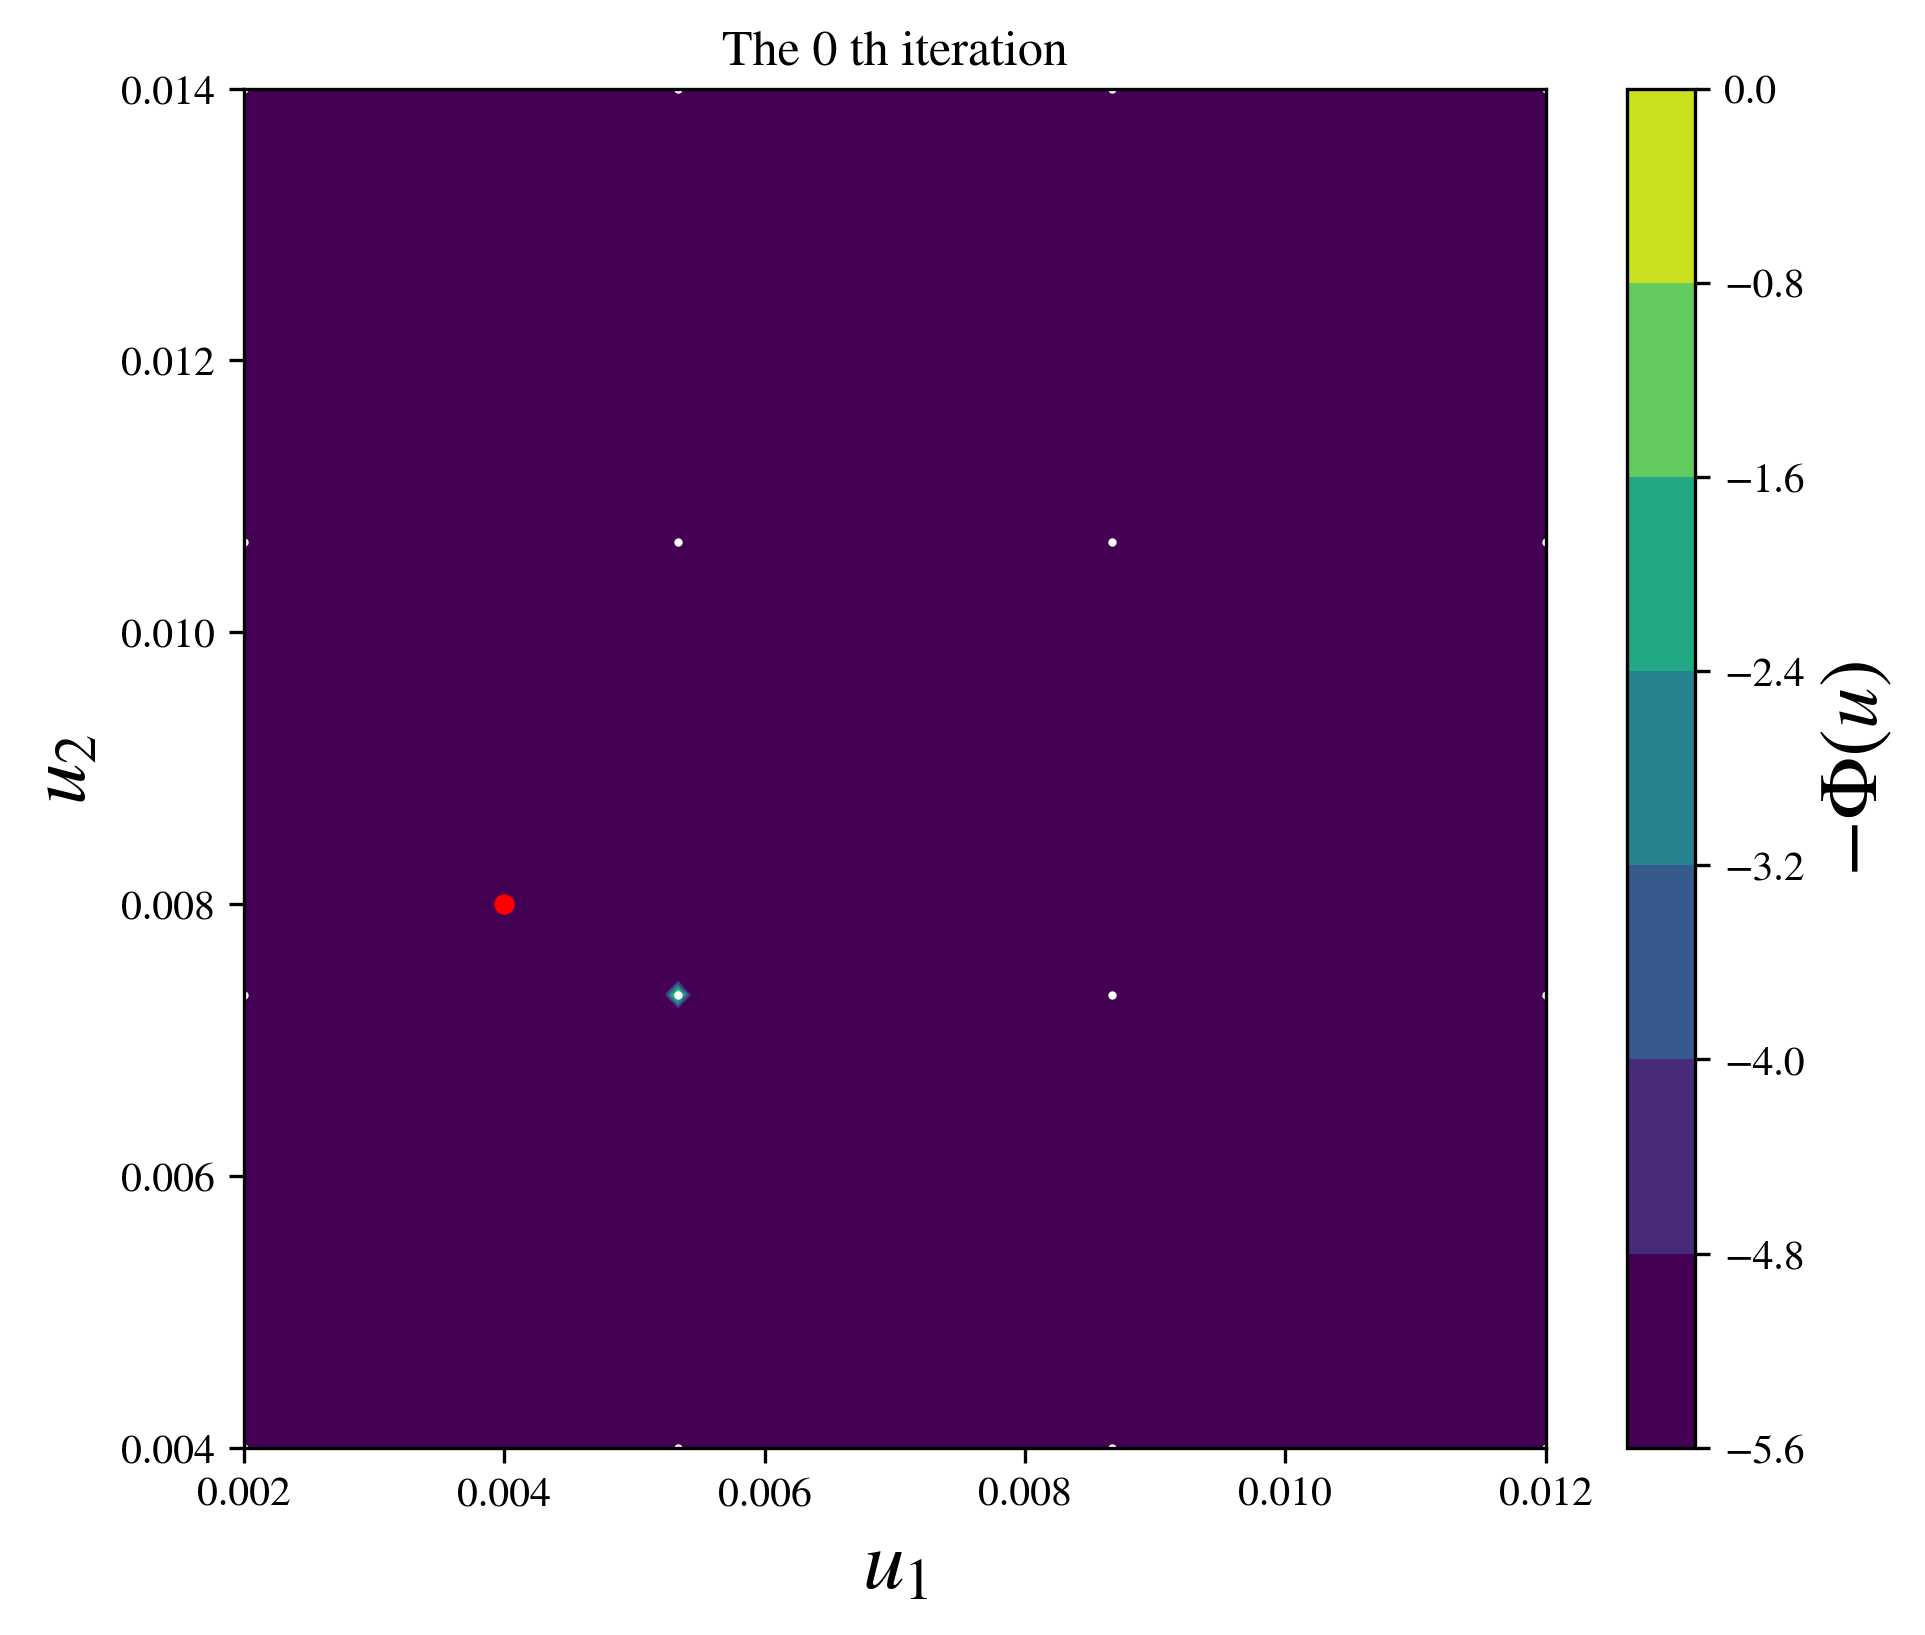

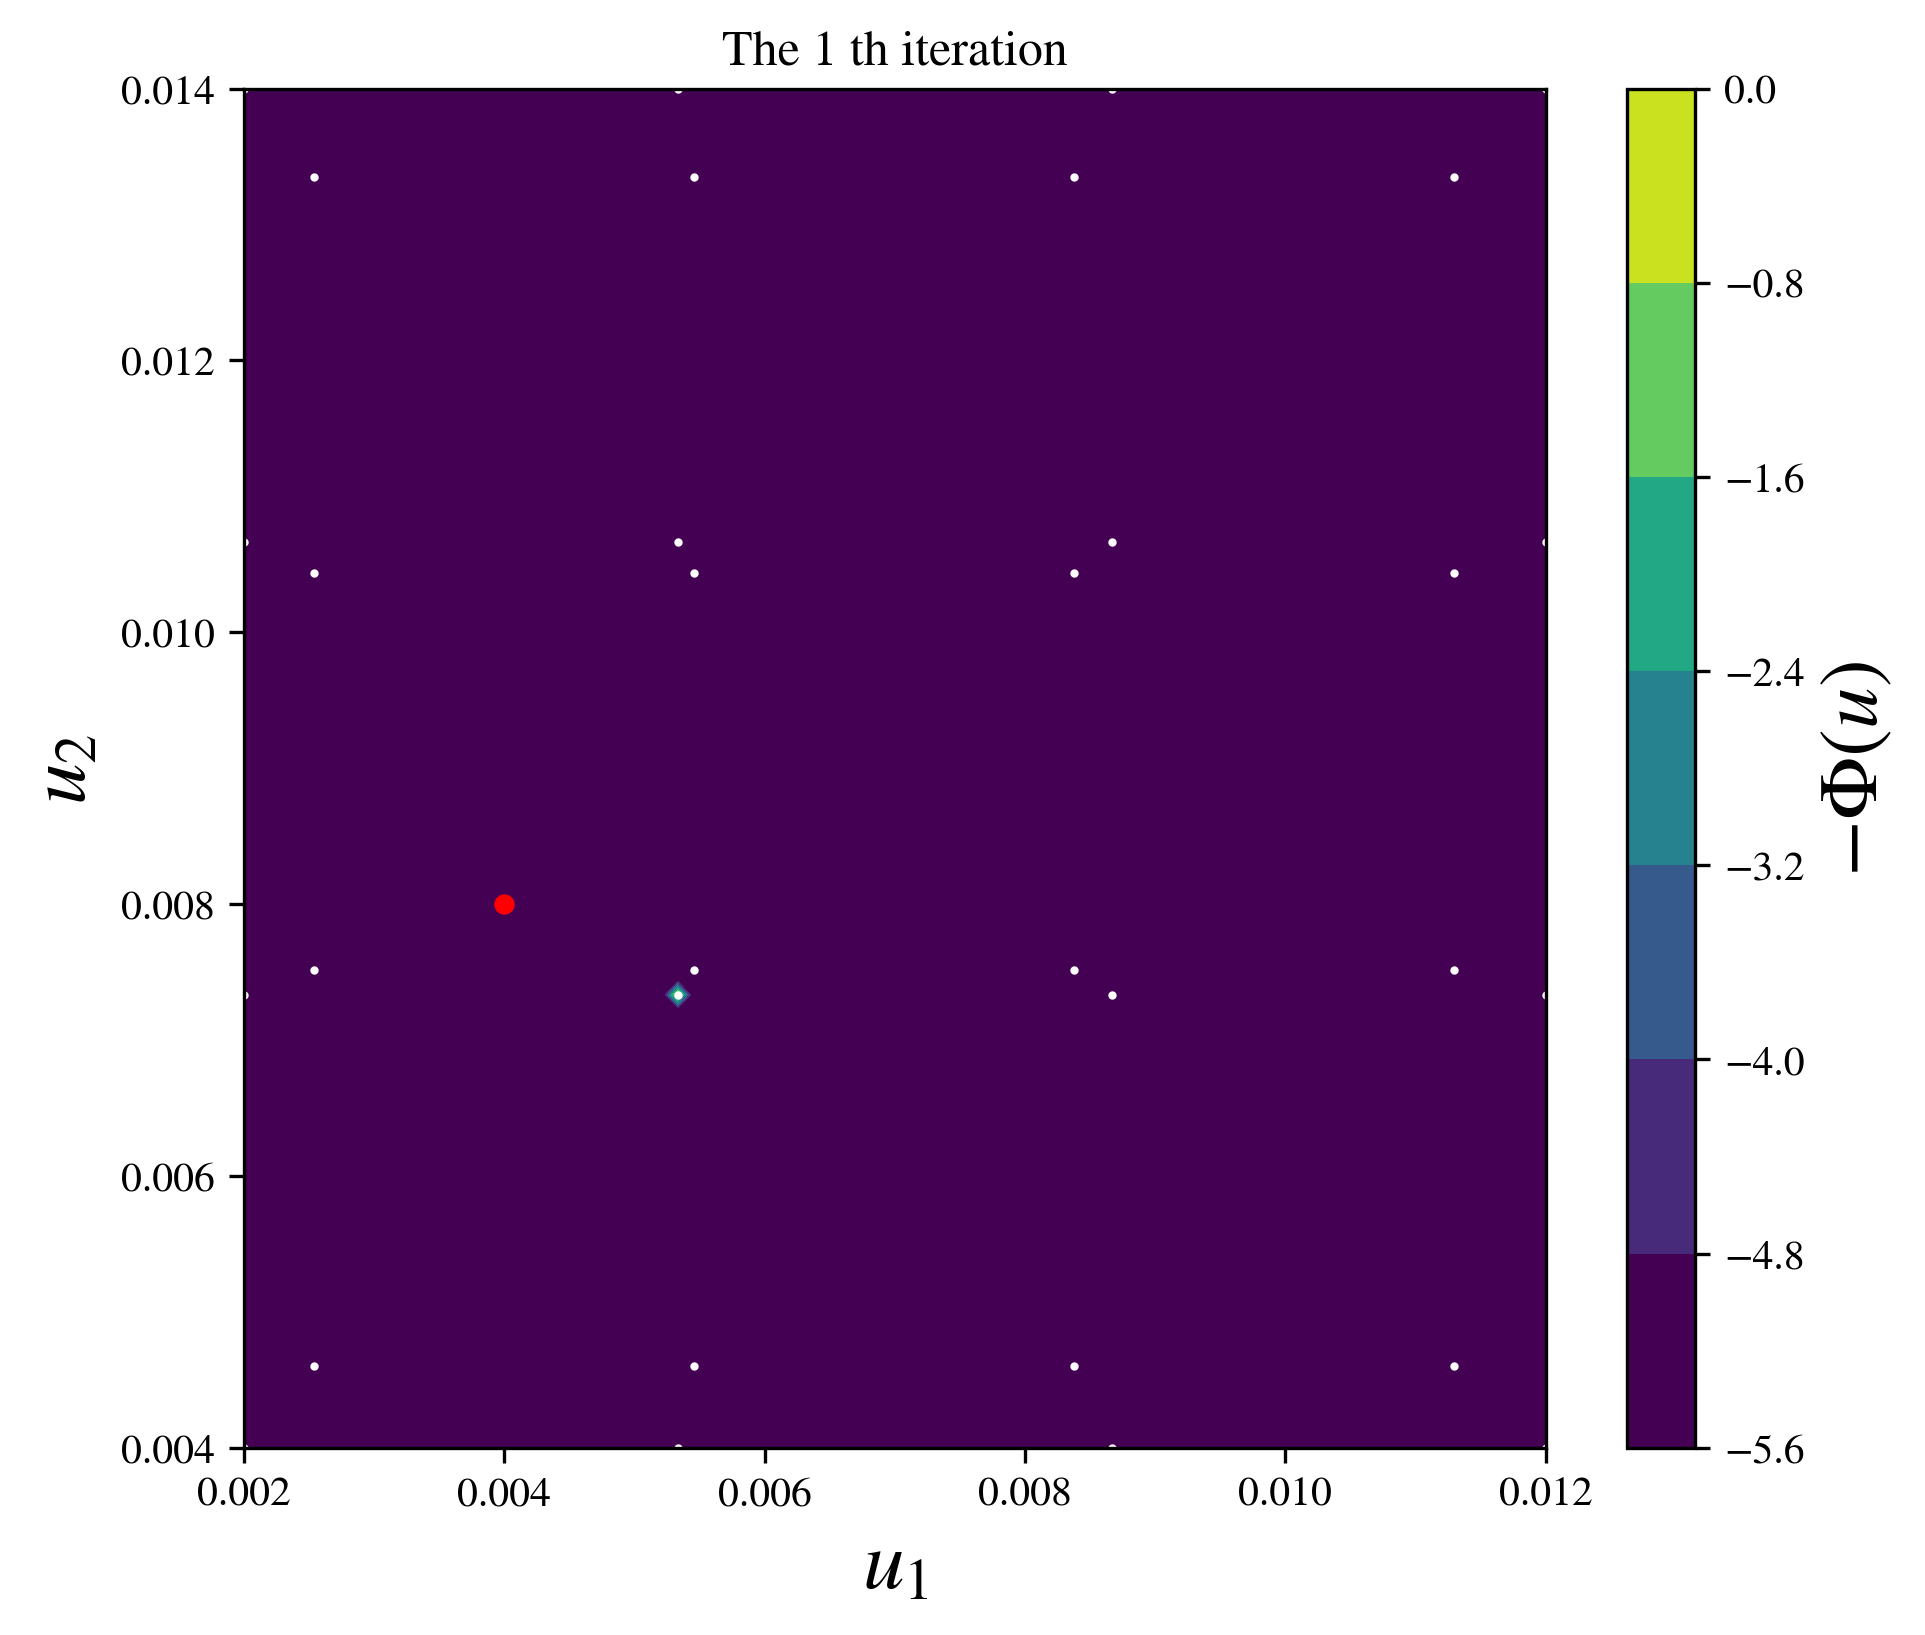

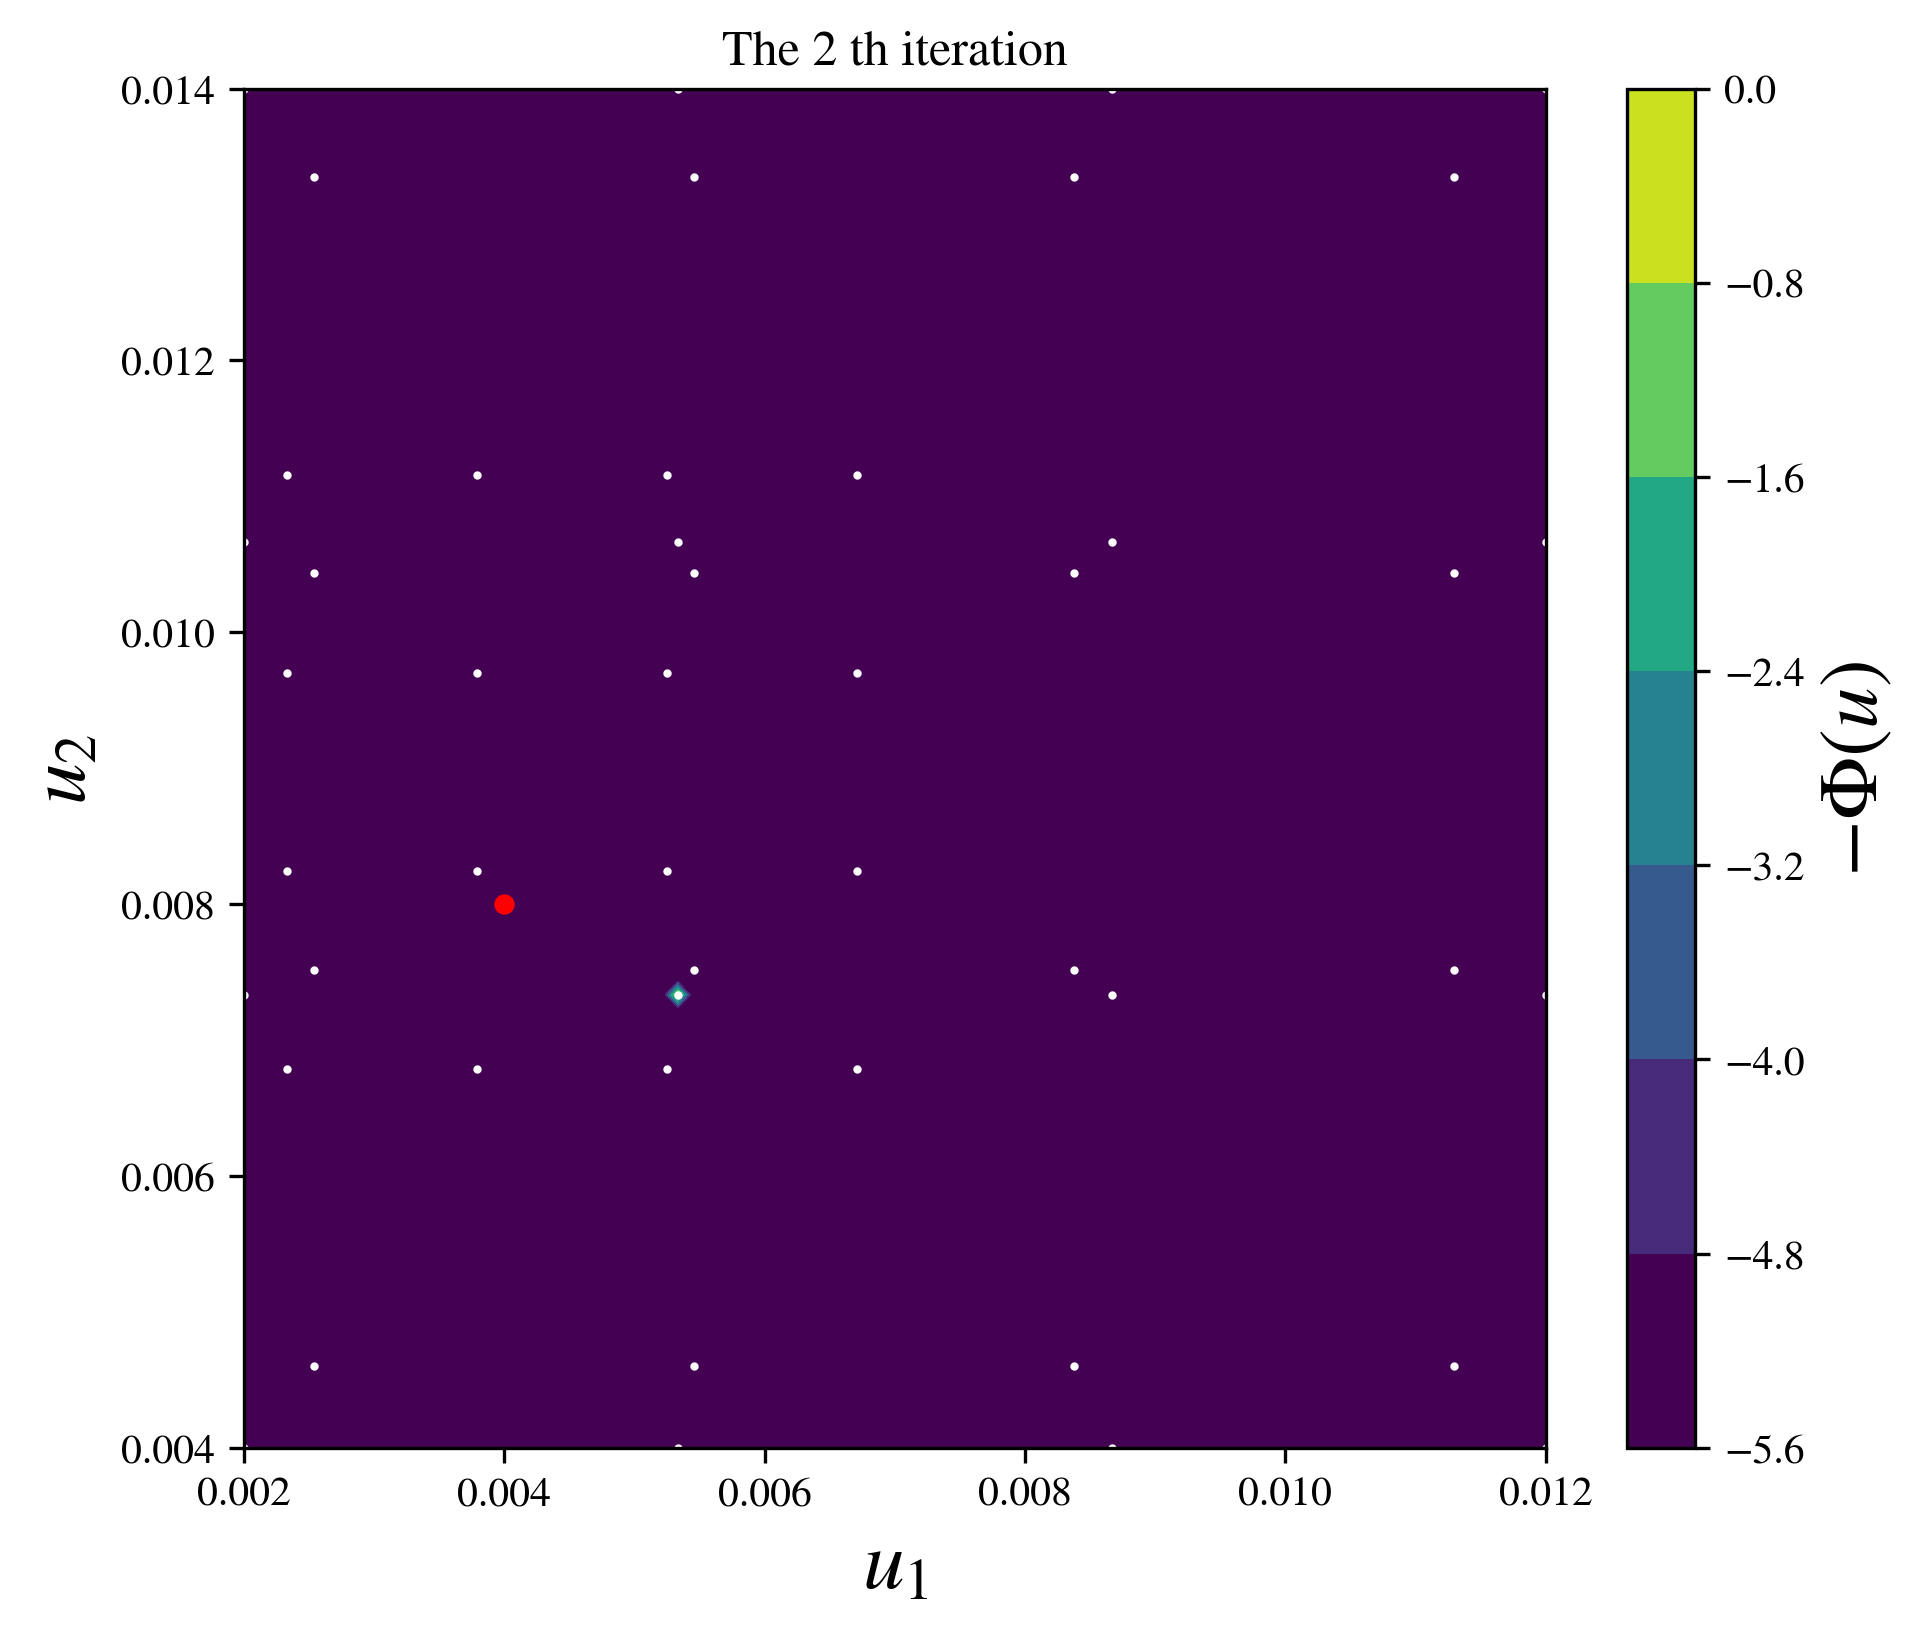

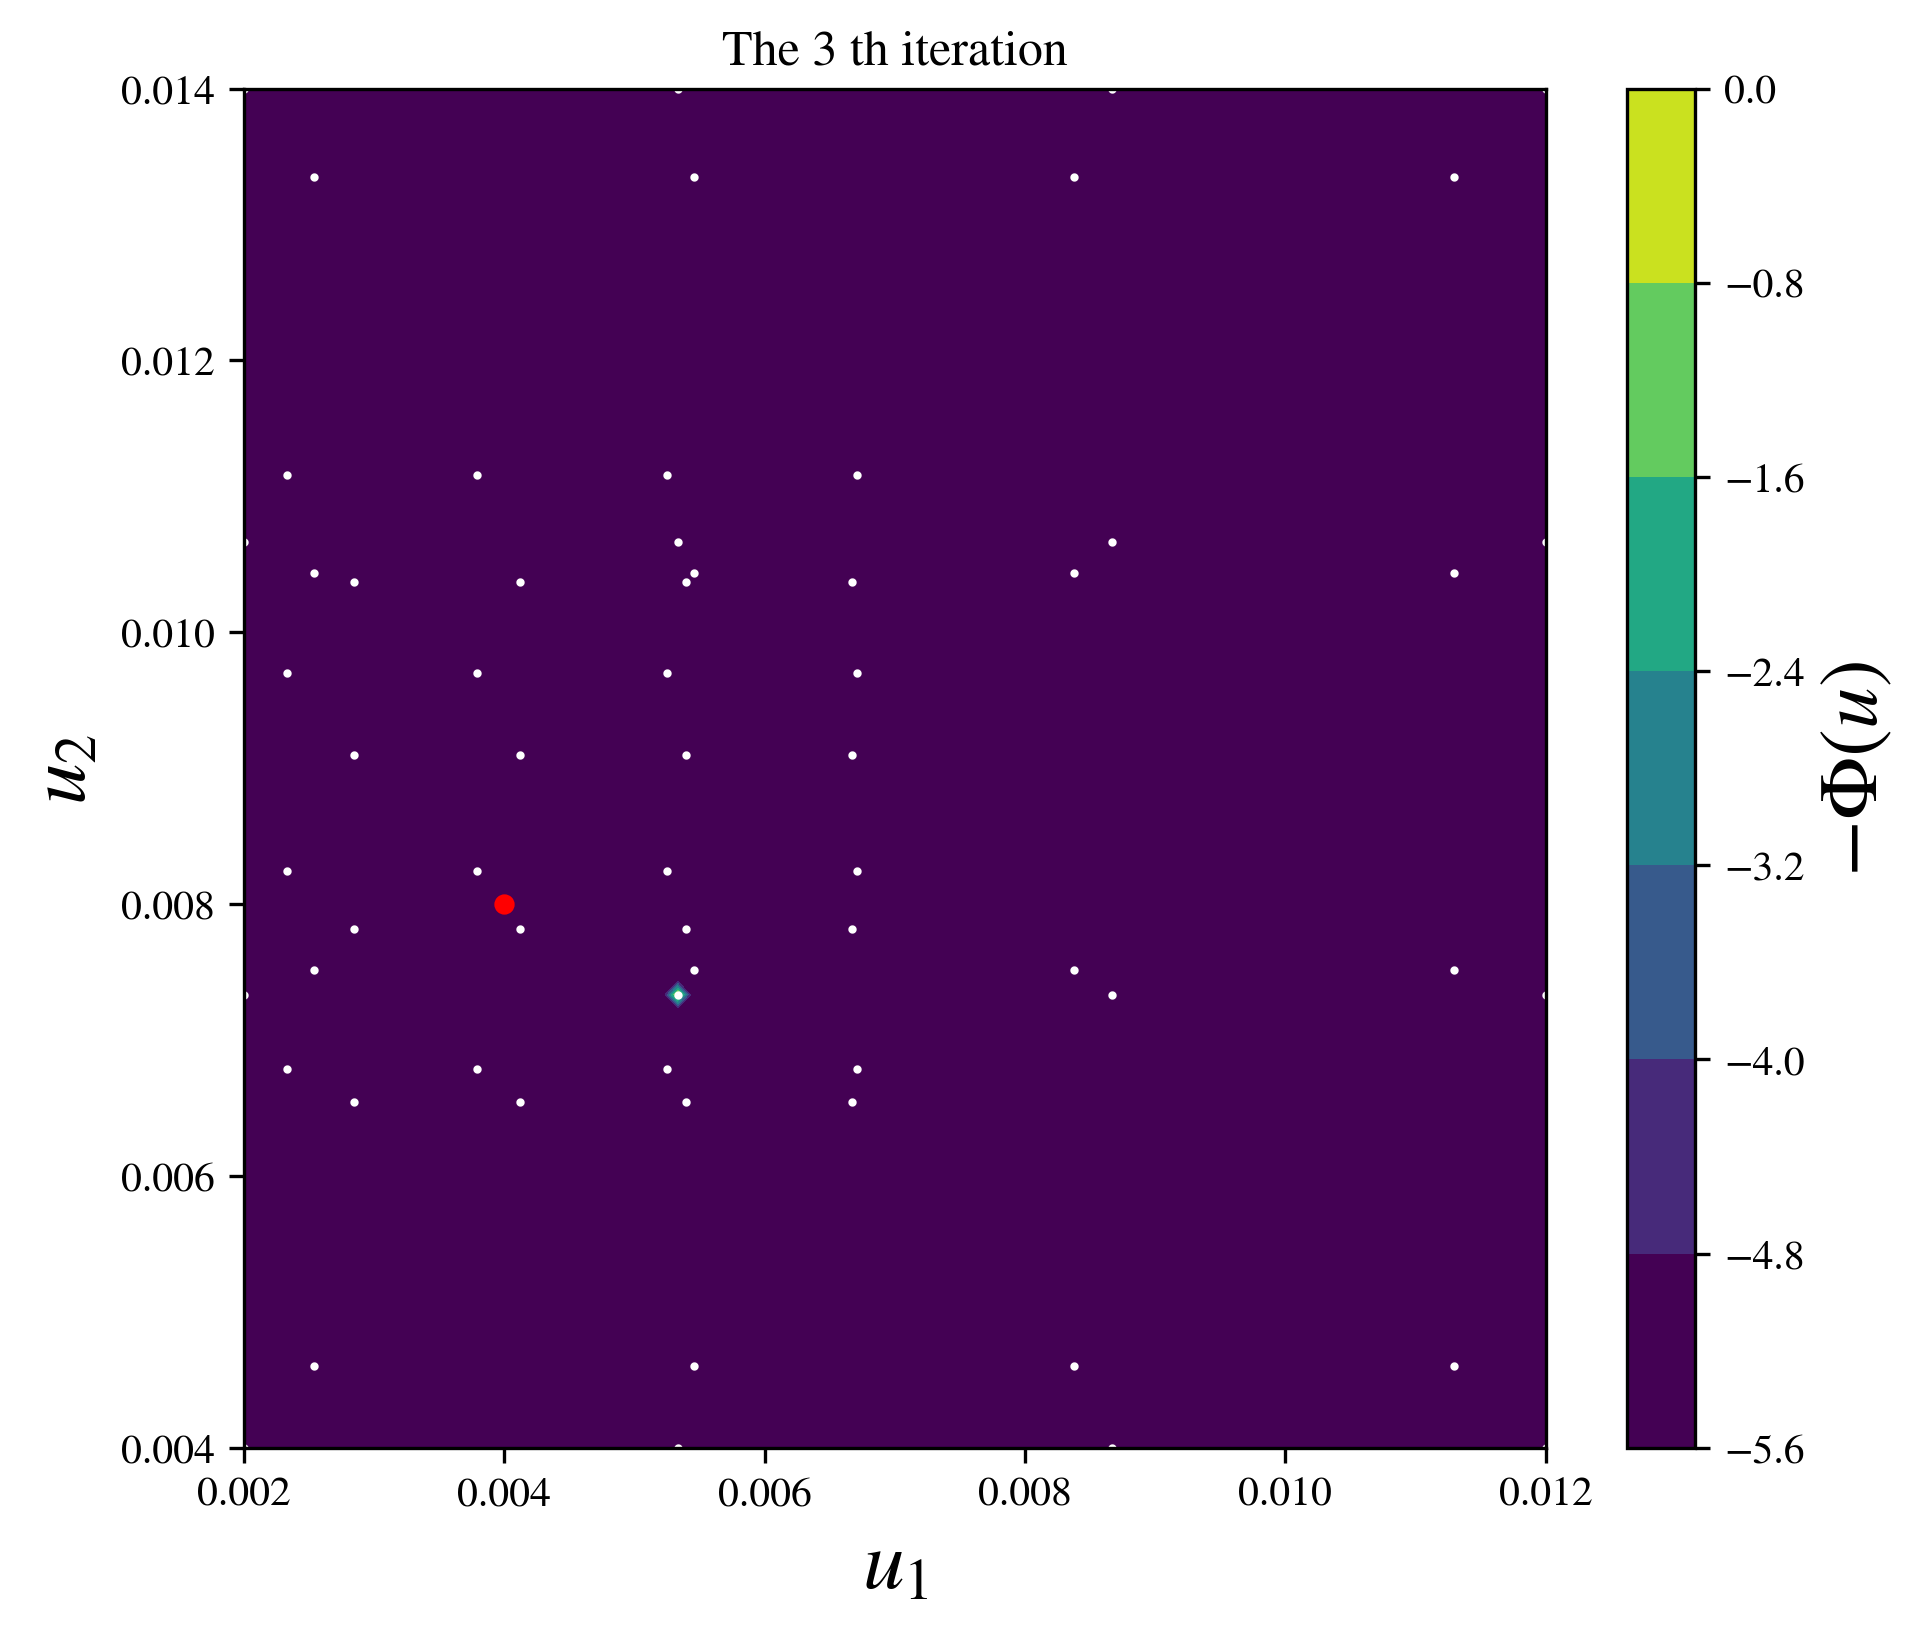

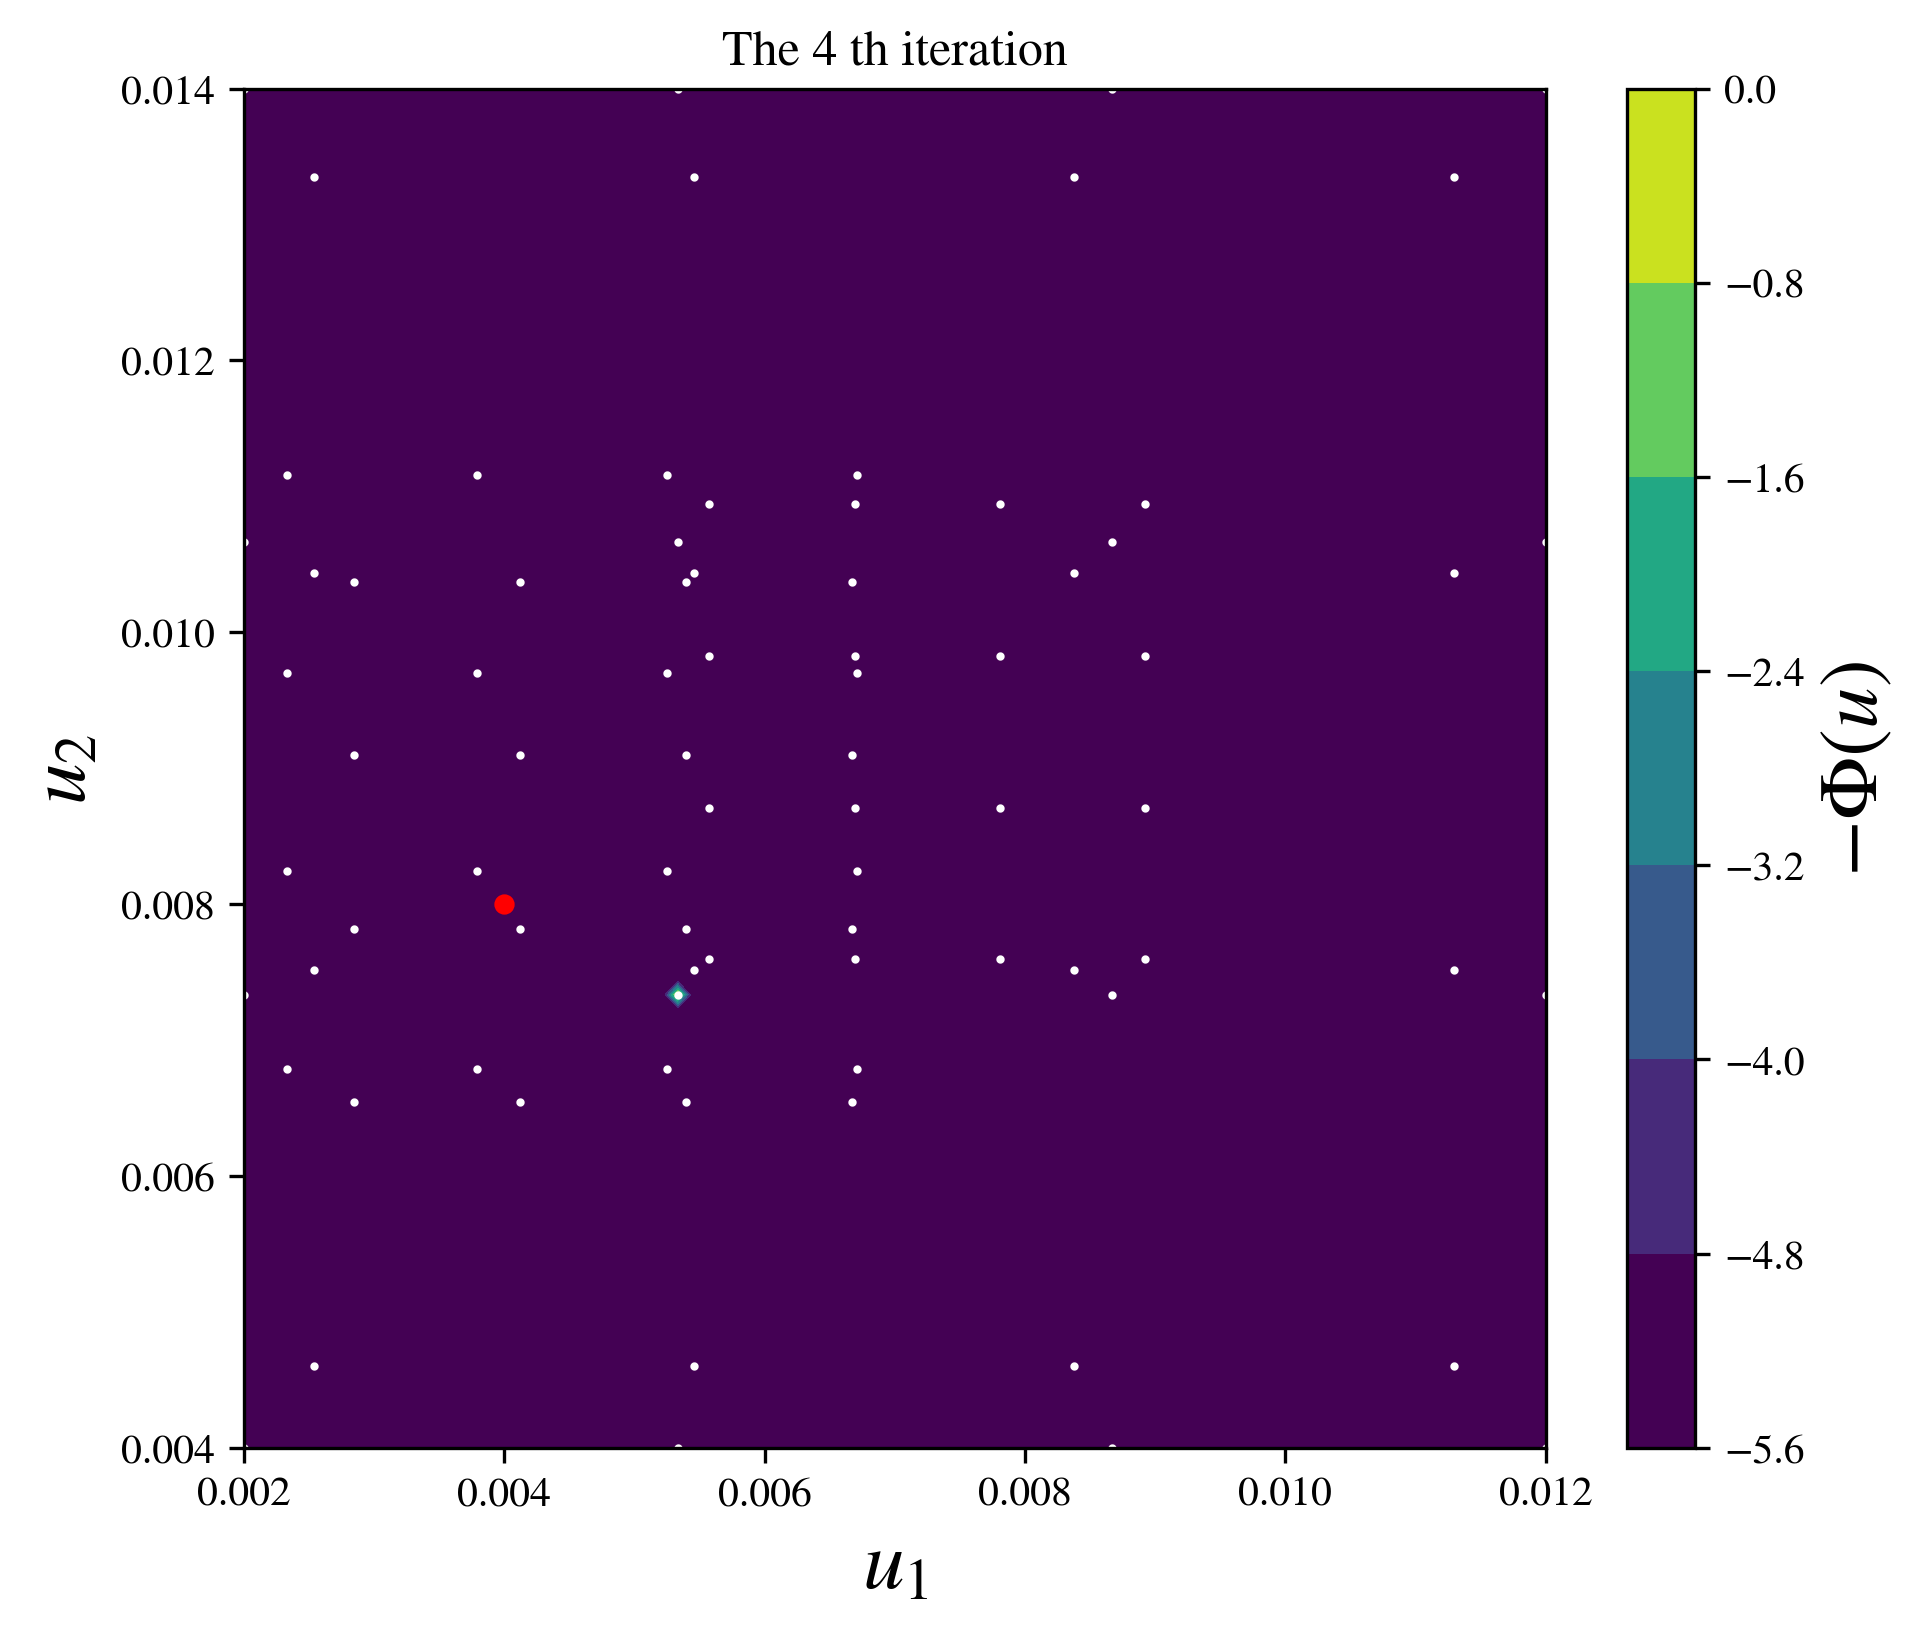

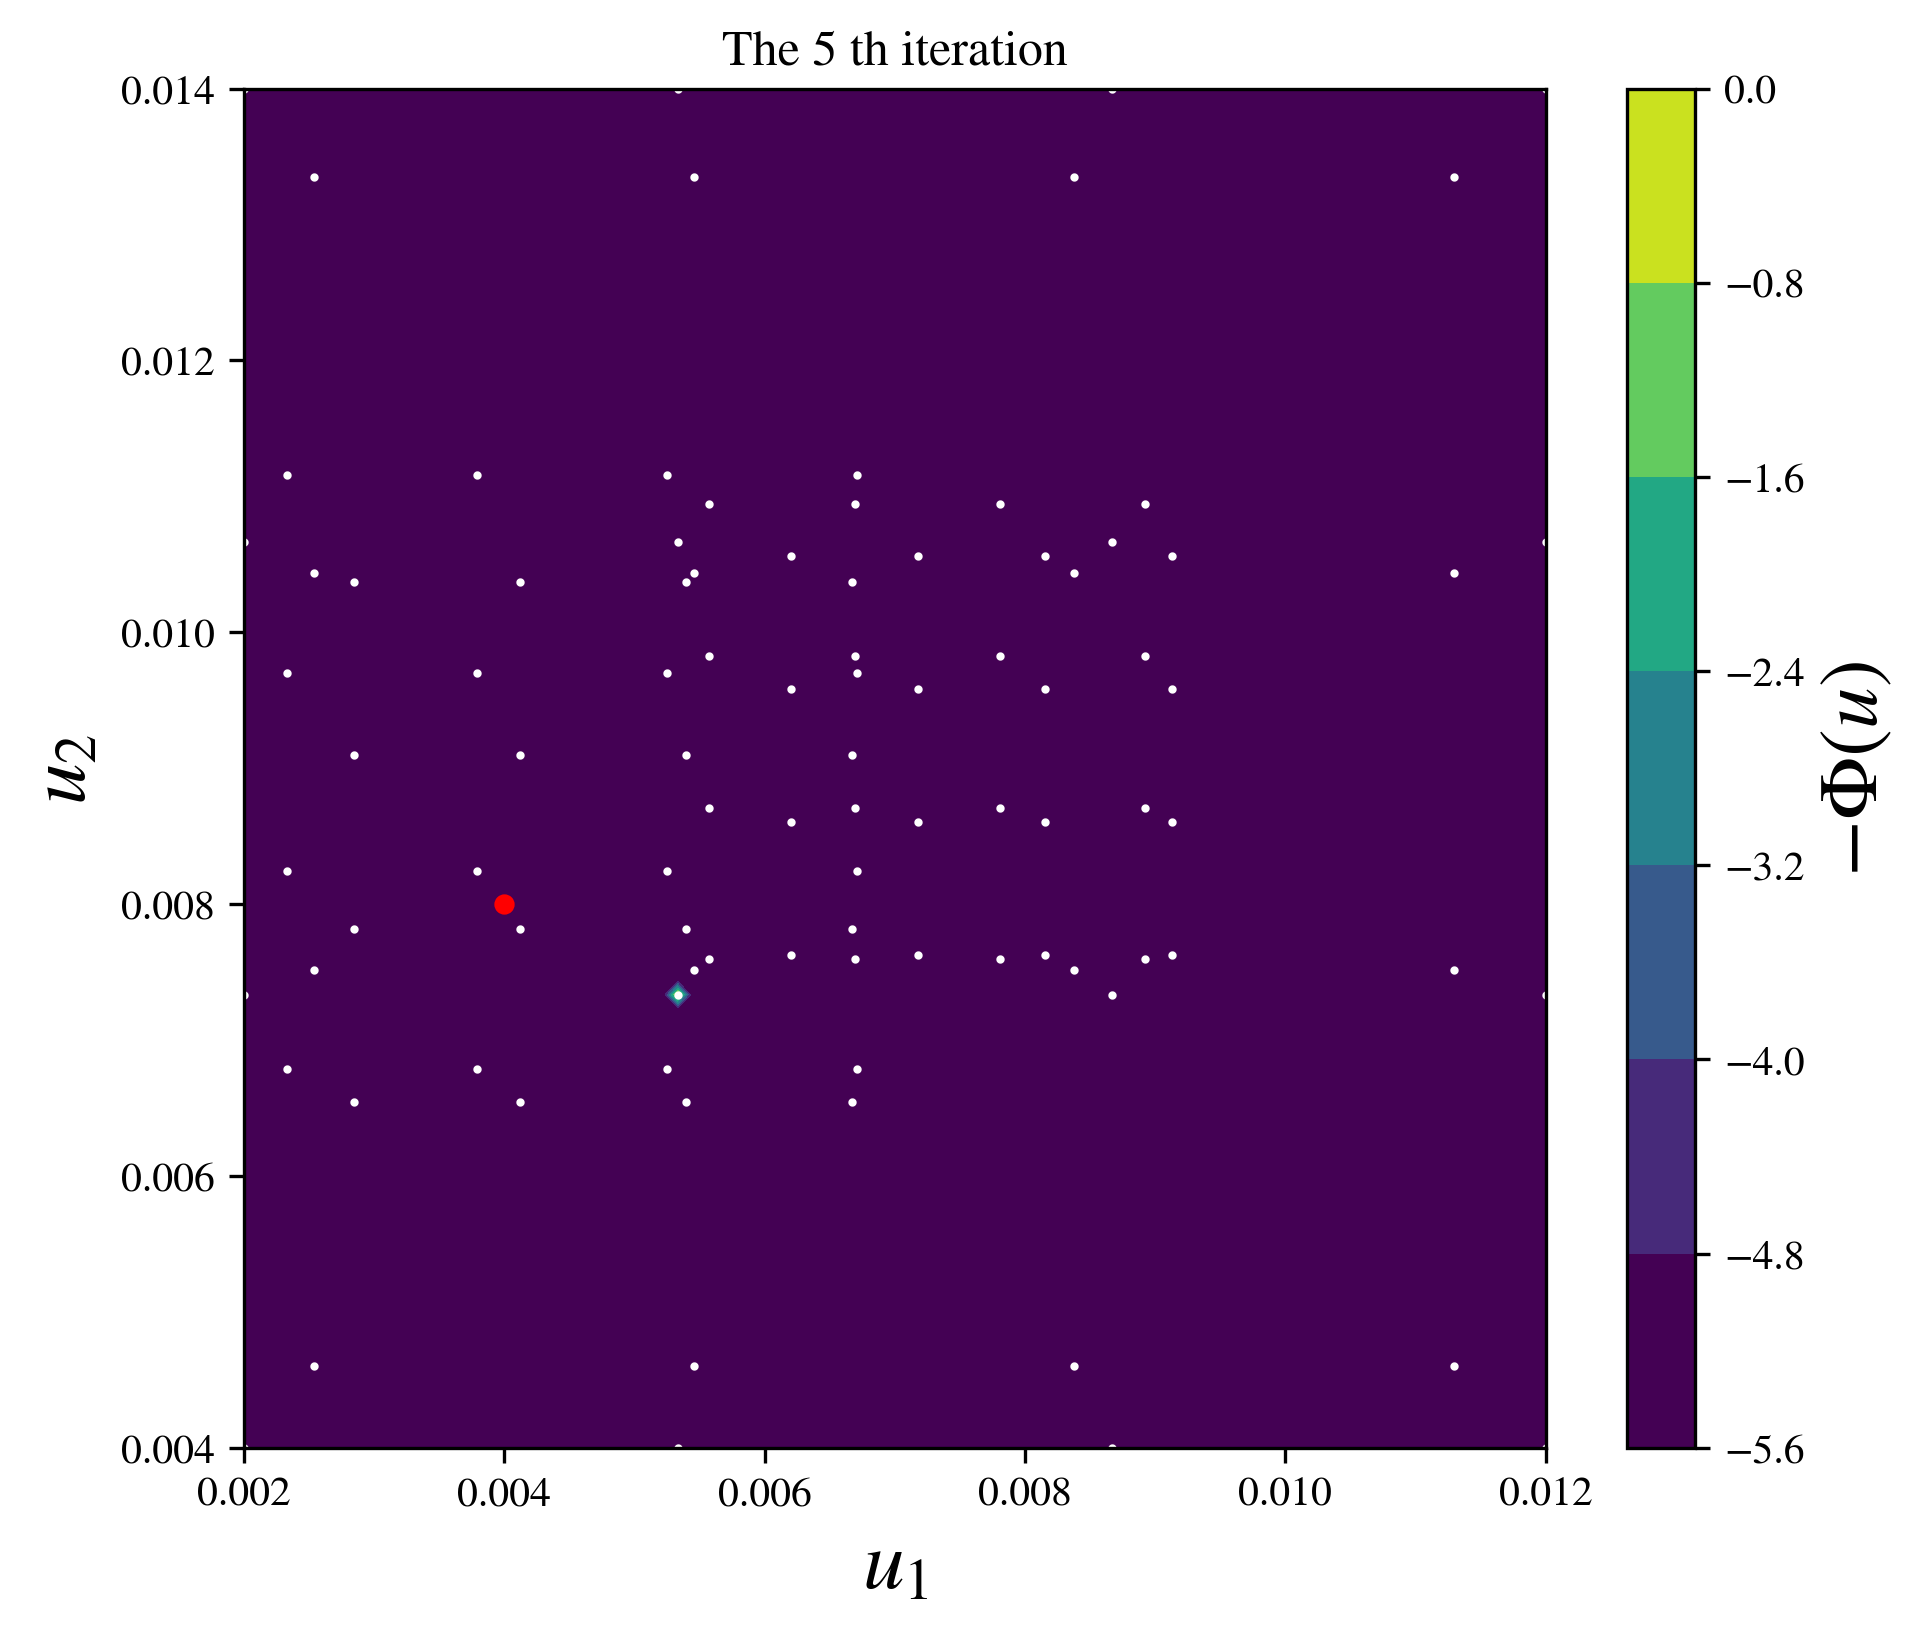

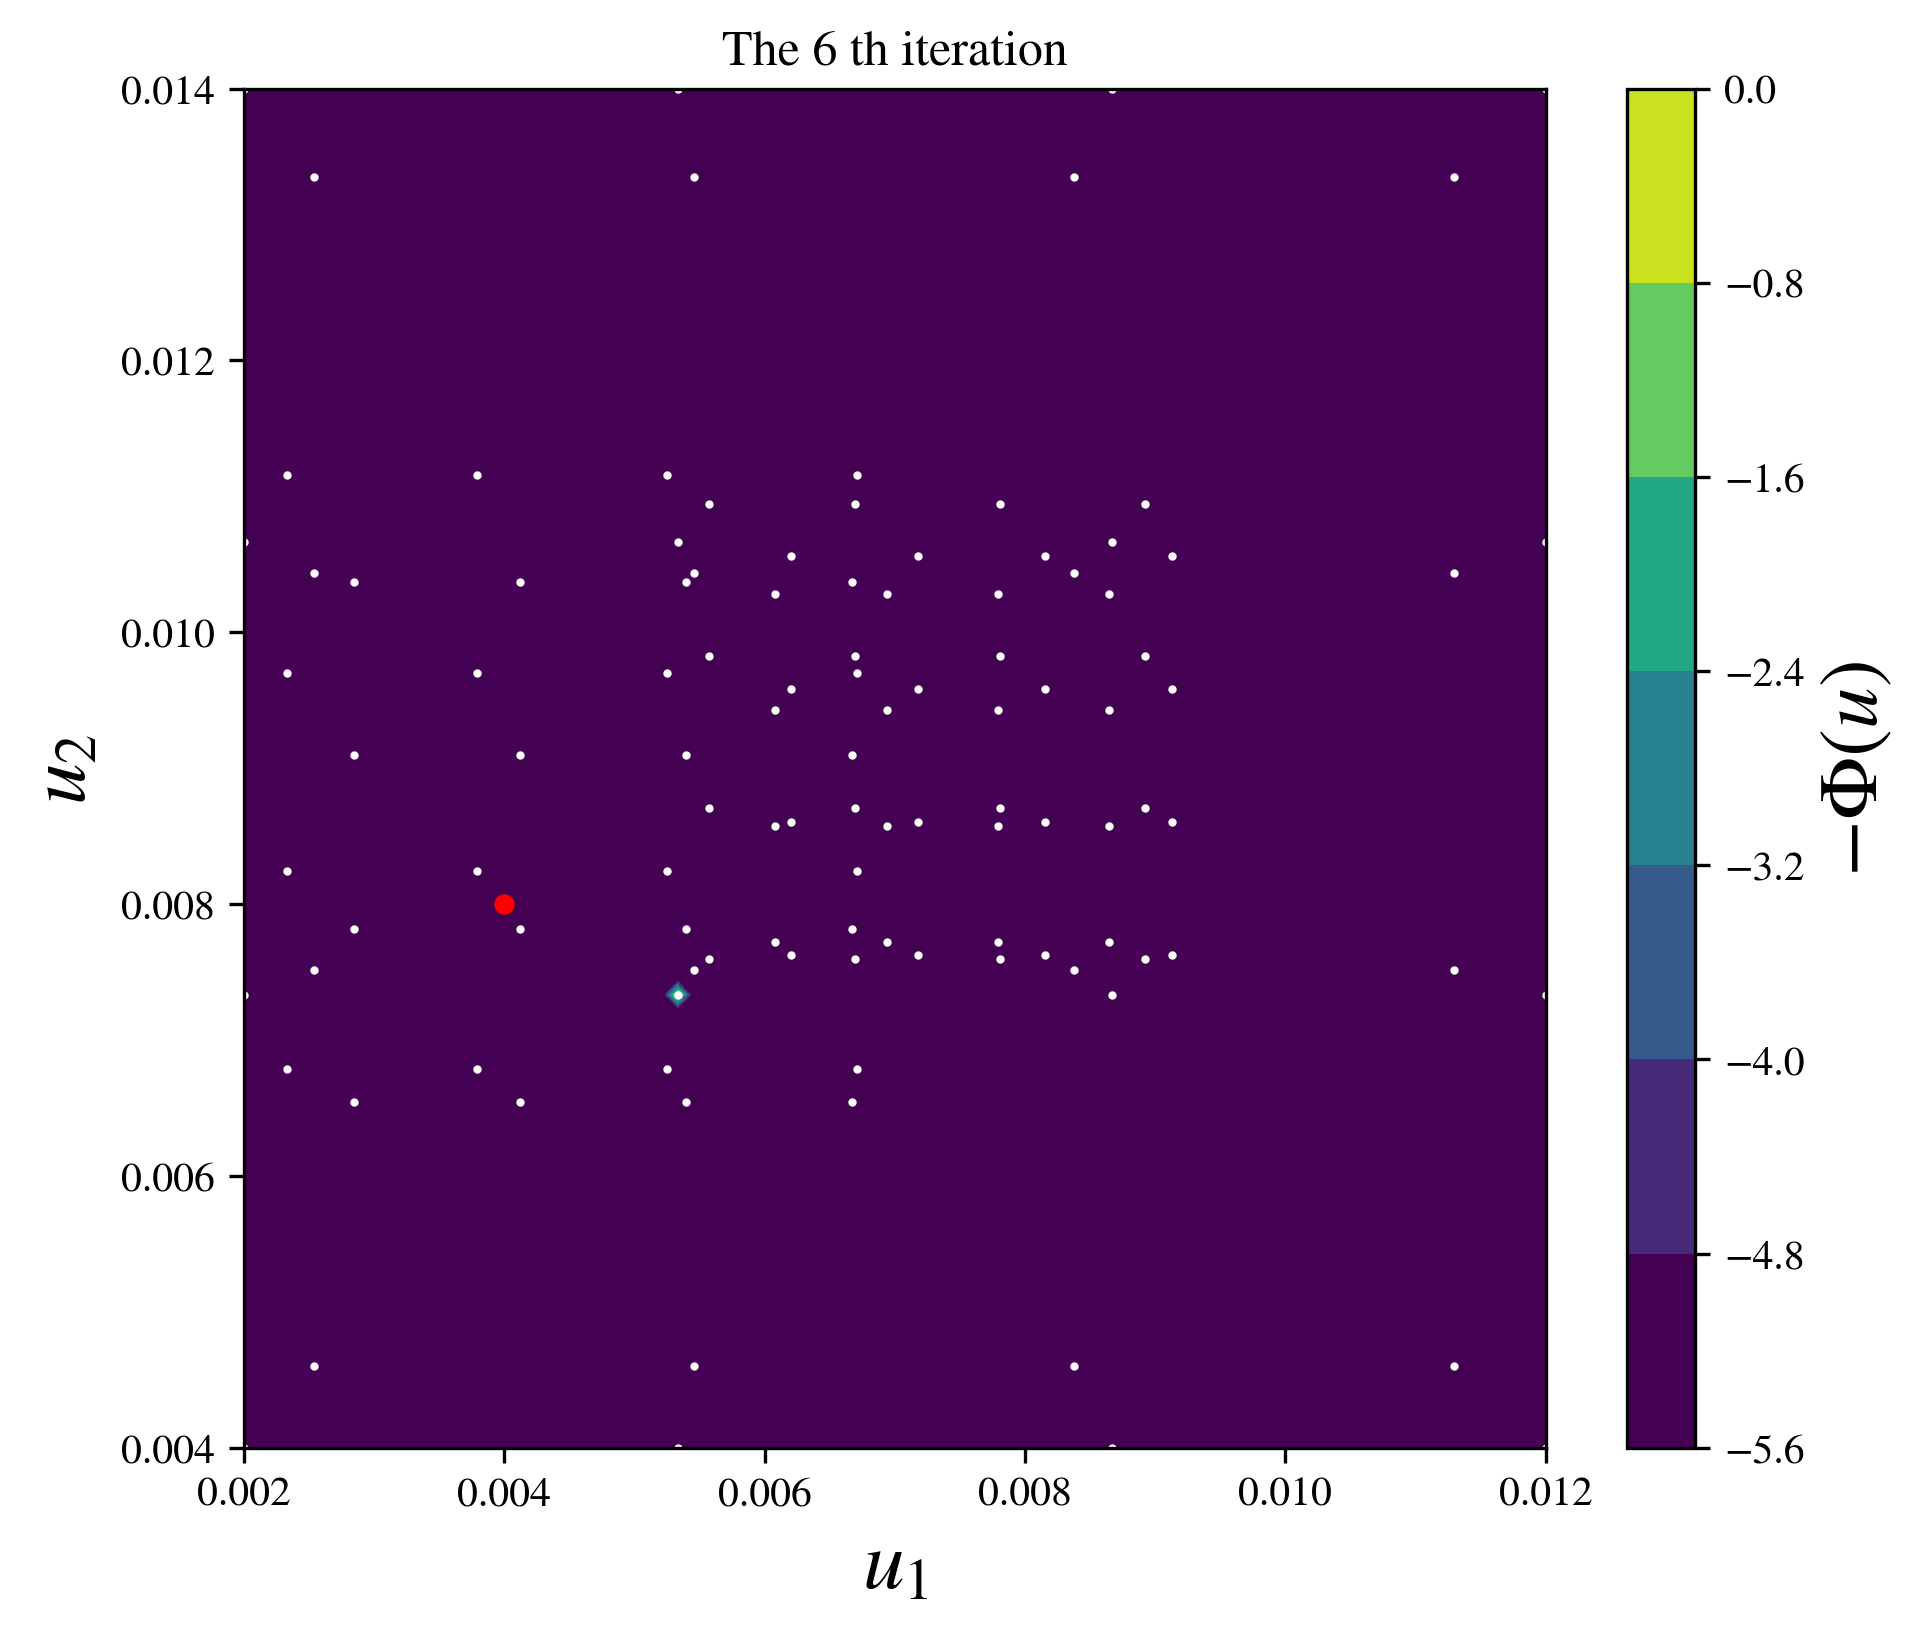

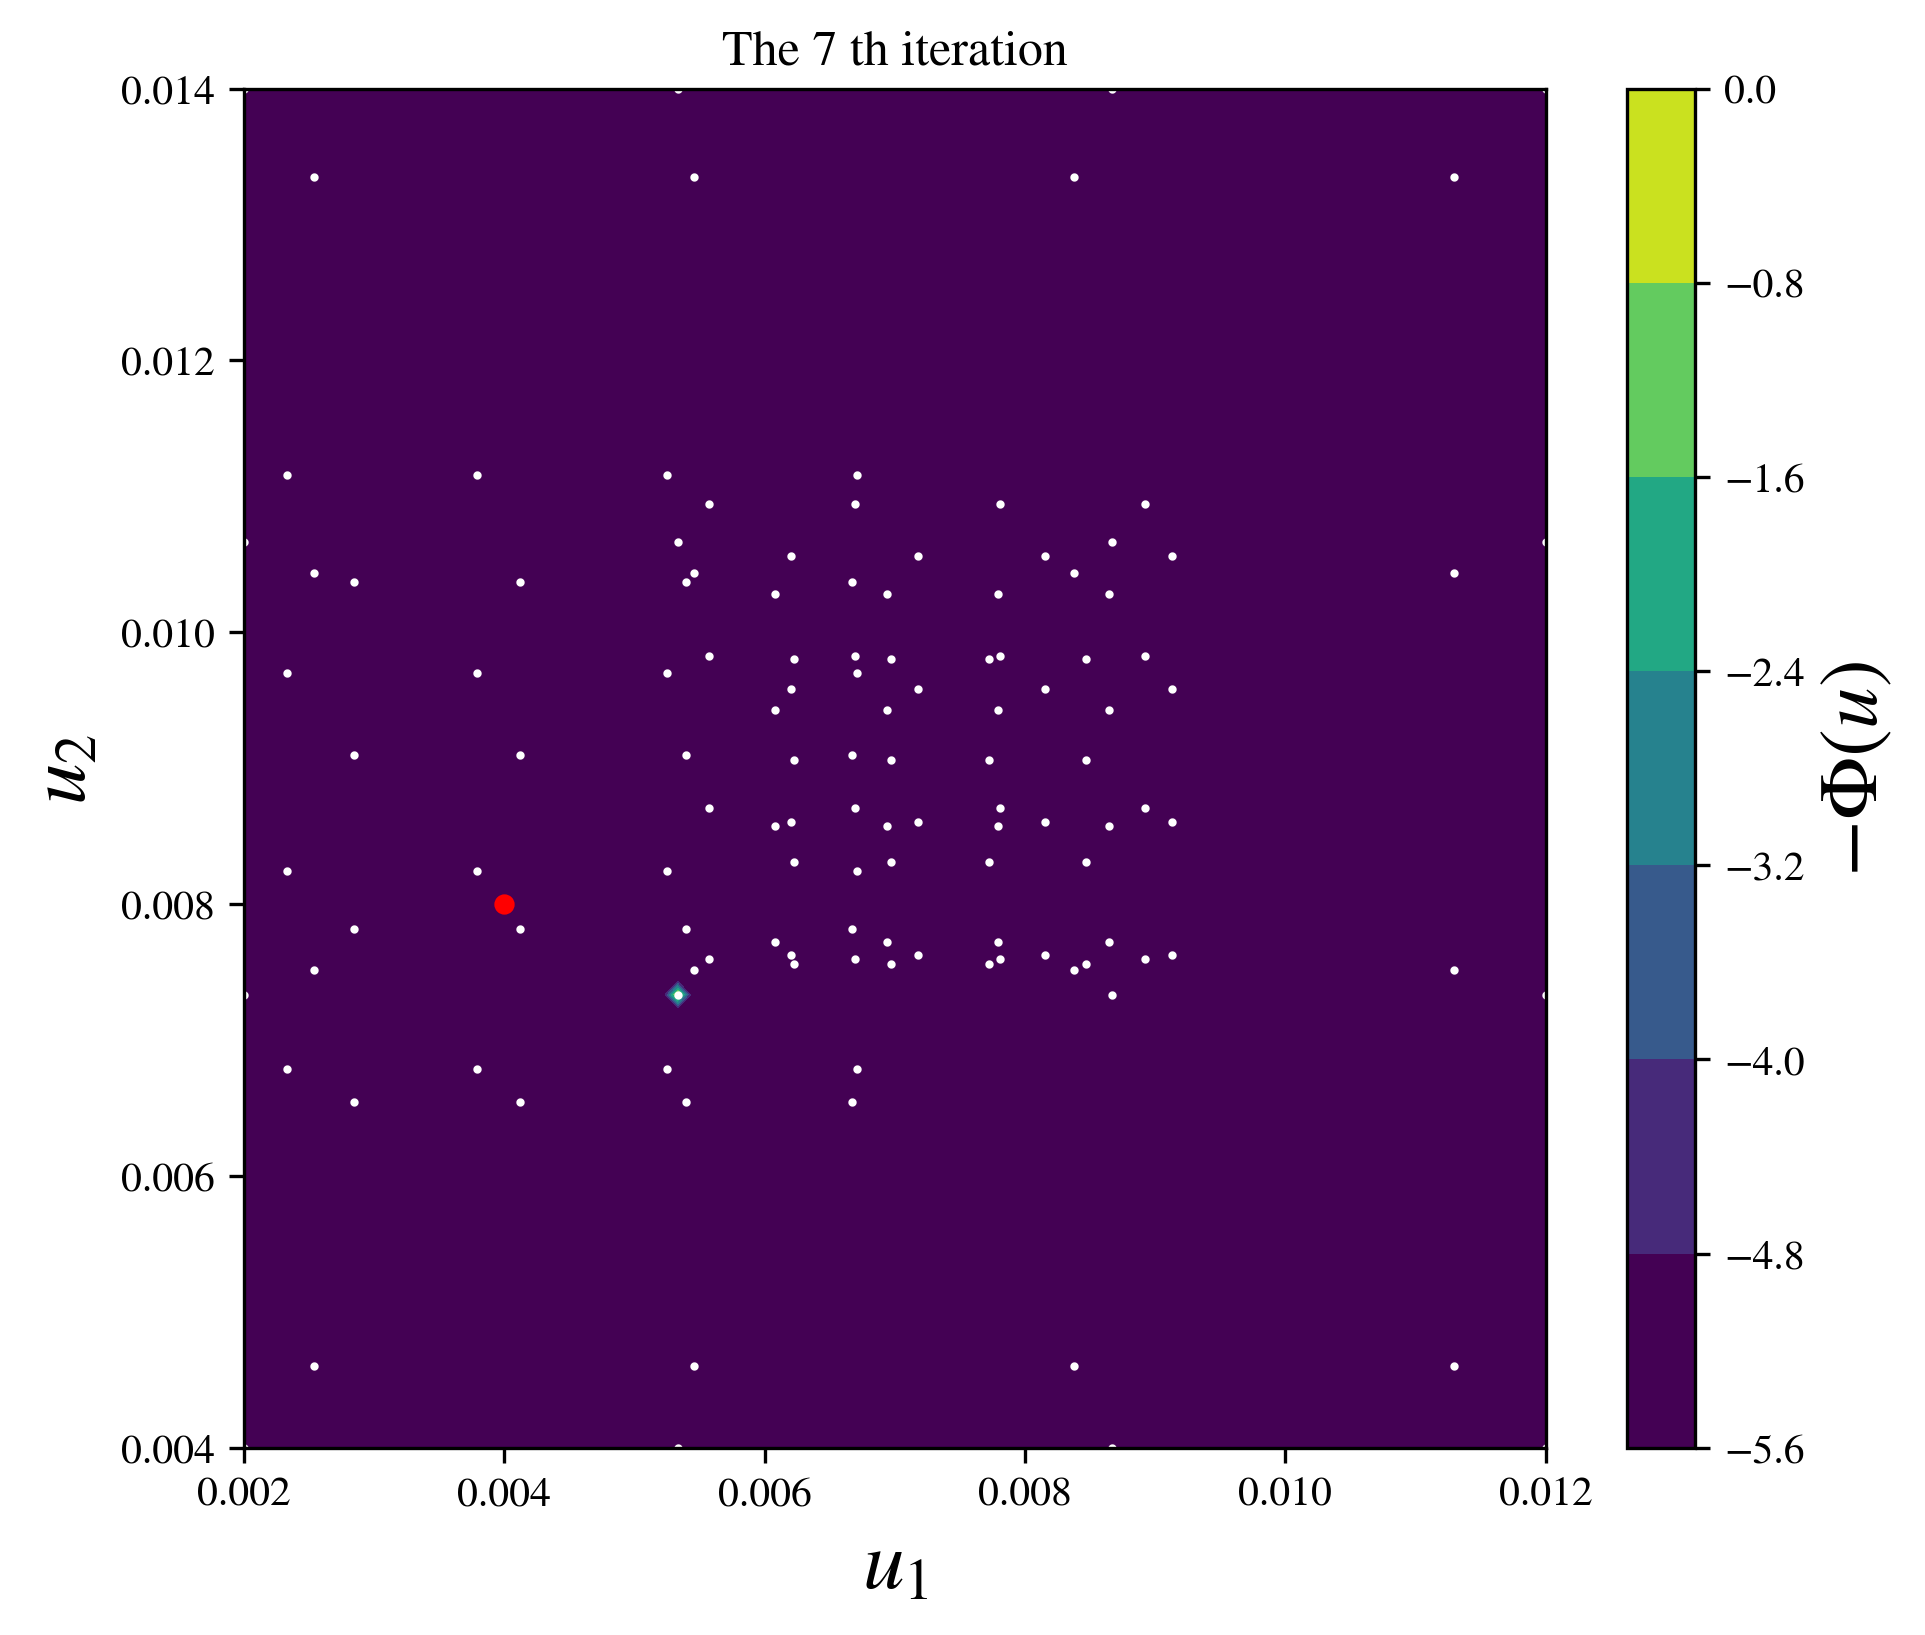

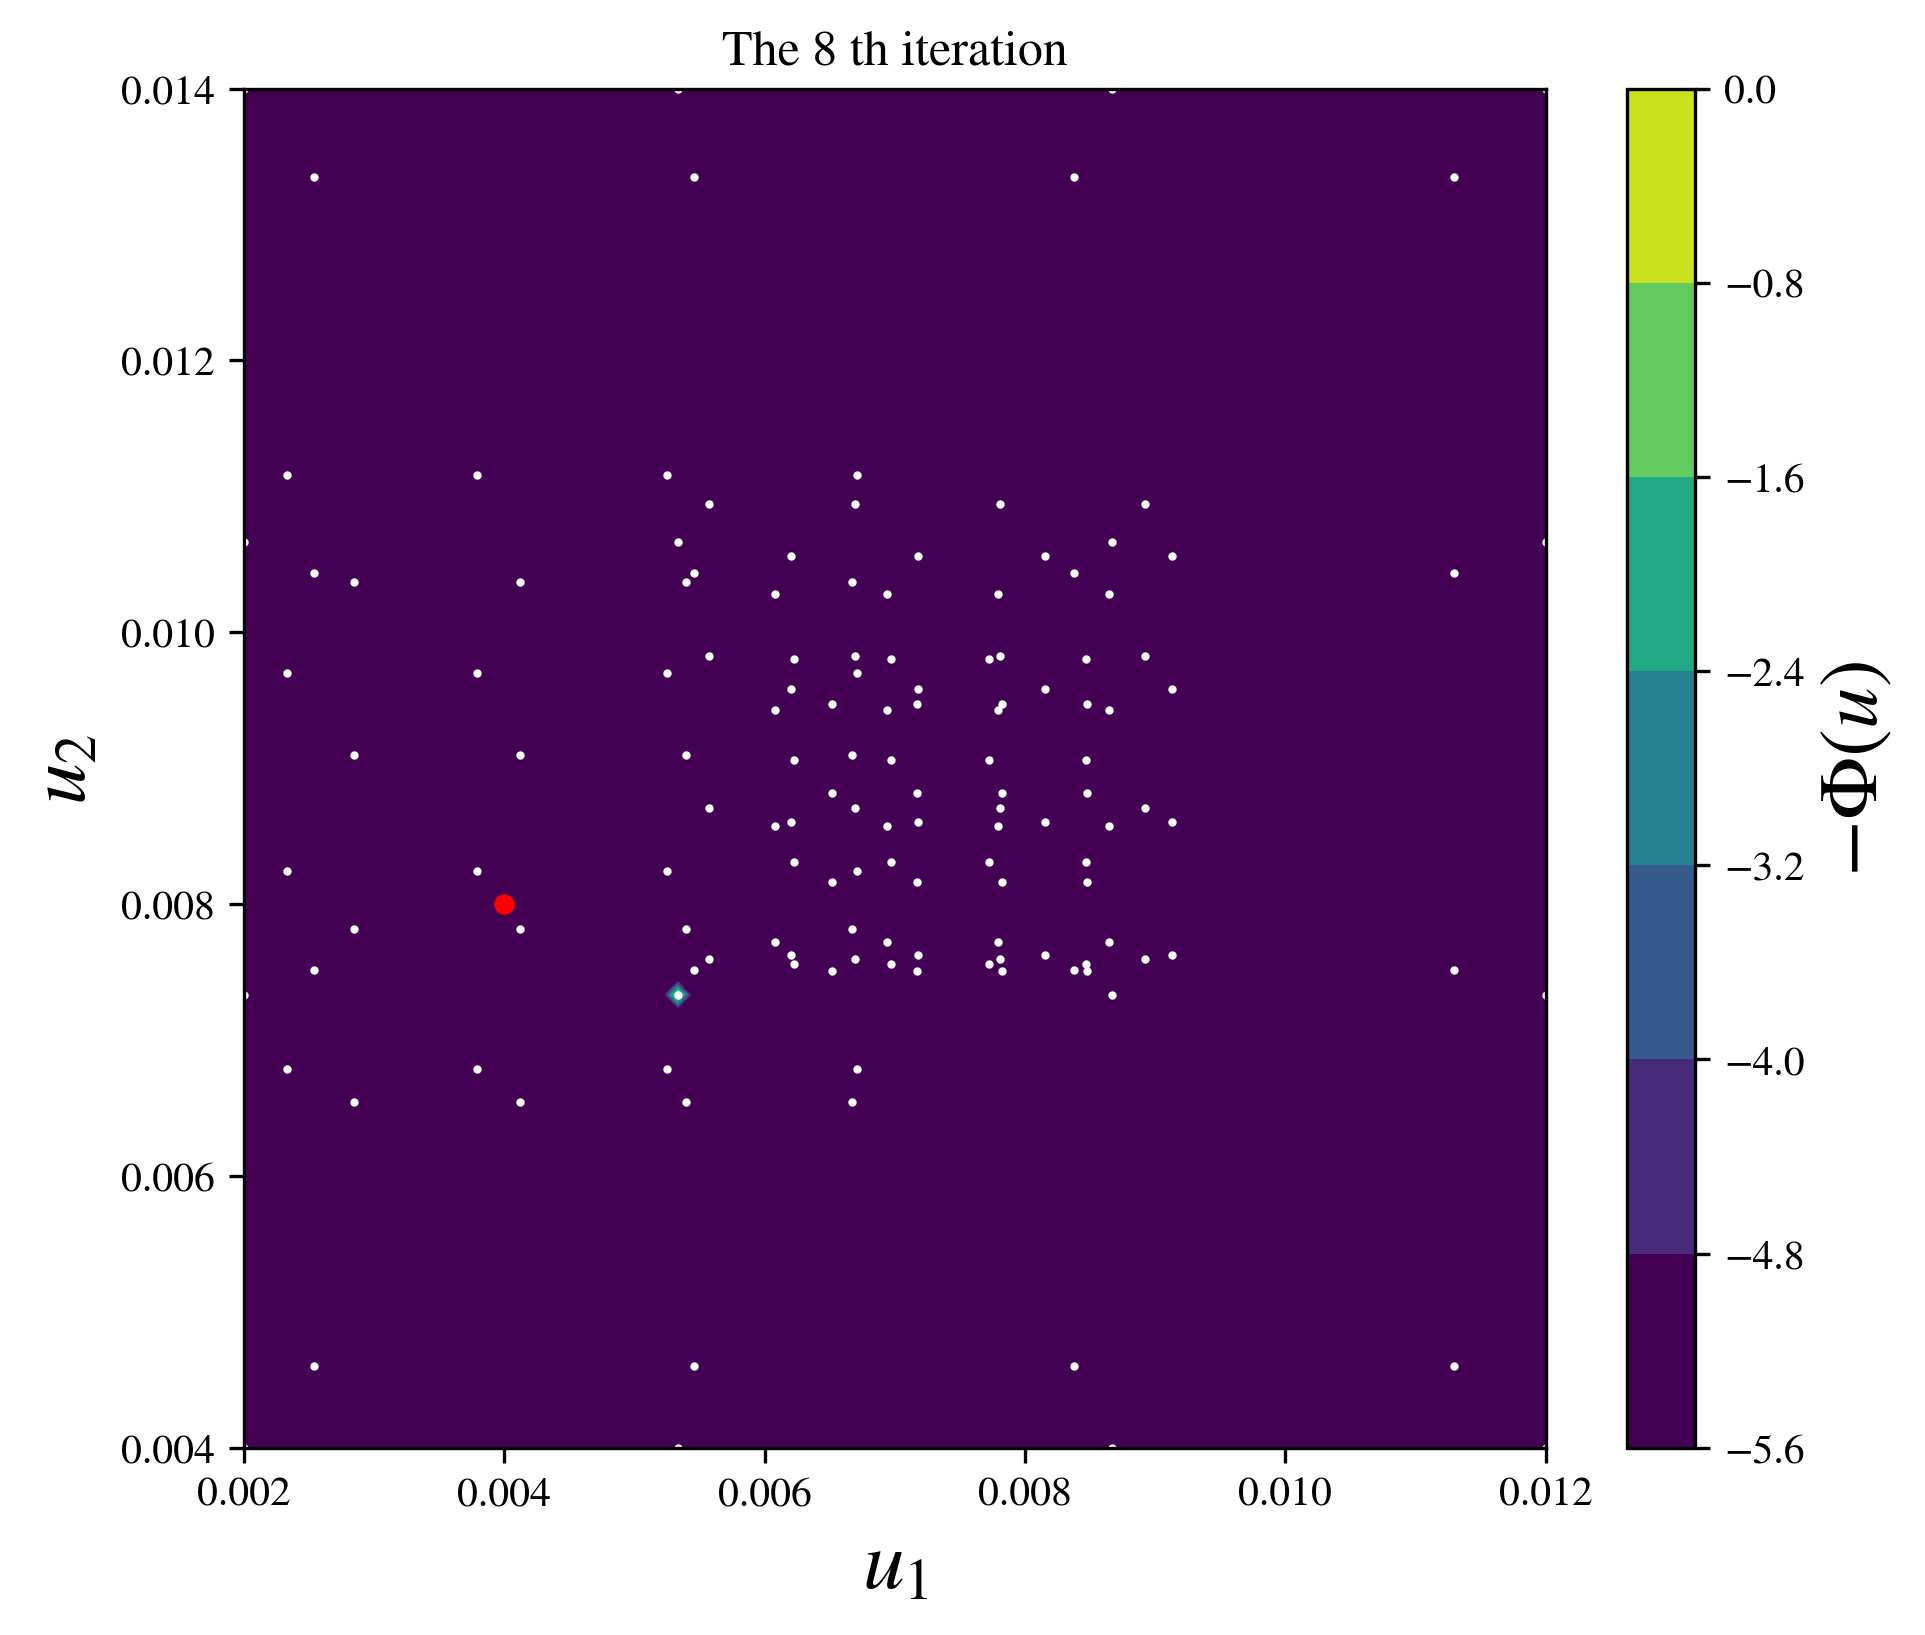

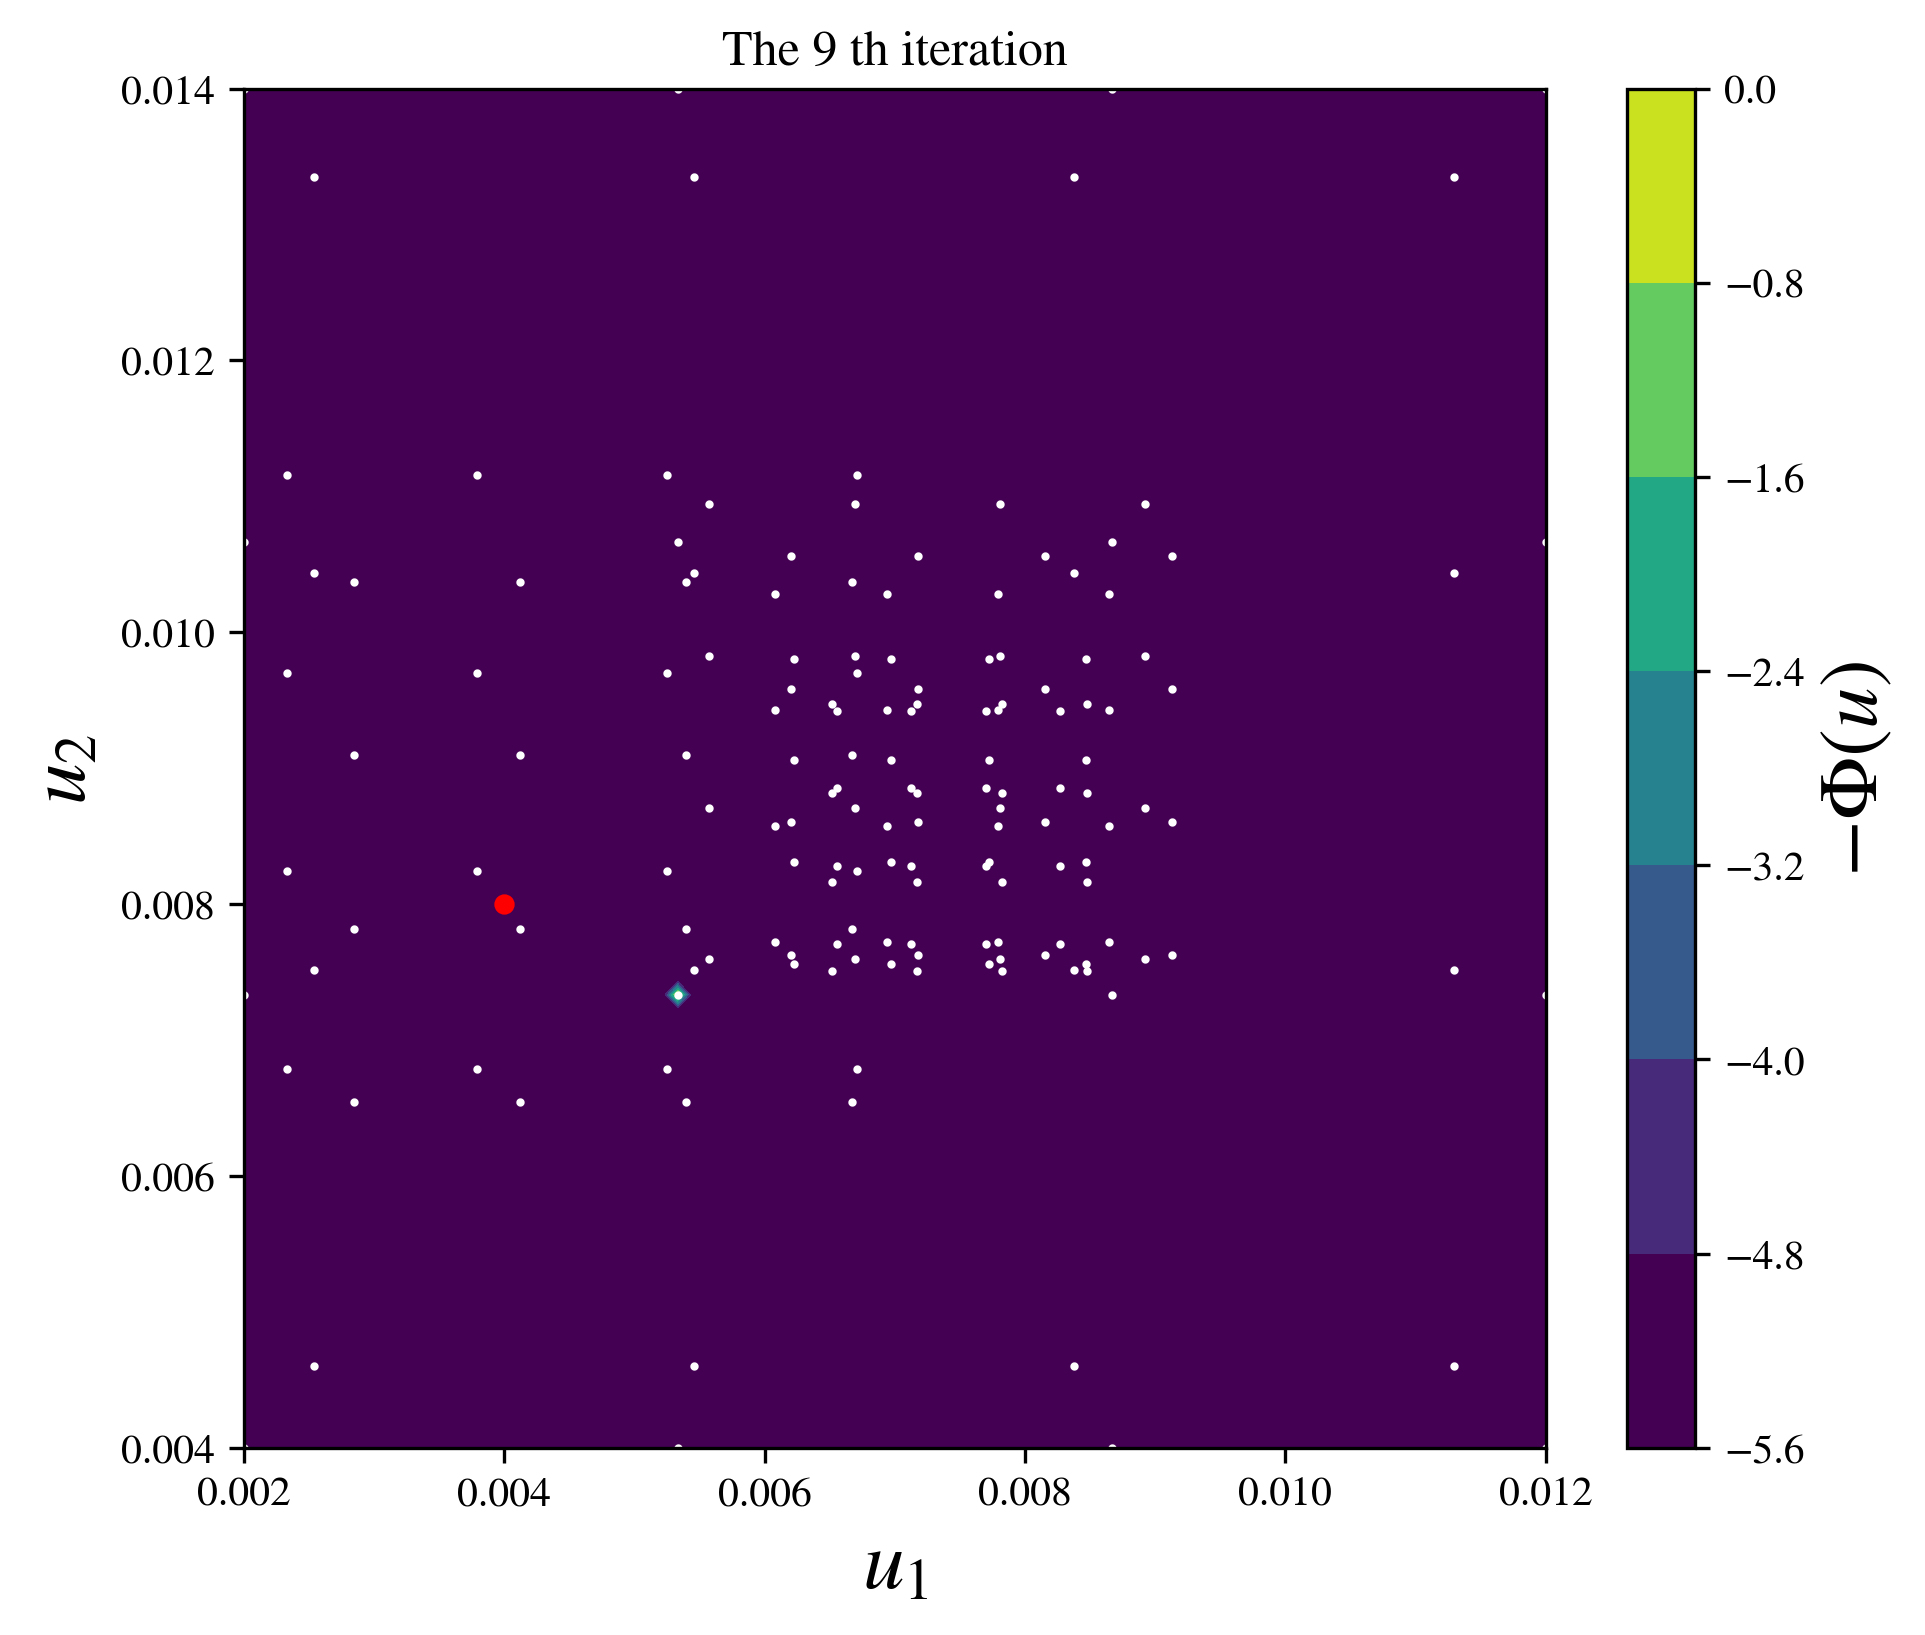

In [98]:
myInv.plotGIF()

In [669]:
# Run another 10 iterations
myInv.run(n_iter_max = 10)

==============================  Iteration  10   ==============================
eta_times, MaxMinDistRatio:  6 1.4890050034444144e+02
Running case A0.007726298838598189_B0.004099786065870086
Finished in 5 s!

Running case A0.009933576245099596_B0.005467182681028729
Finished in 5 s!

Running case A0.007631668887039629_B0.00408877780111573
Finished in 6 s!

Running case A0.009928042363567011_B0.005053155123200017
Finished in 5 s!

Running case A0.007594074927871309_B0.004093784884240049
Finished in 6 s!

Running case A0.009987706220013095_B0.005205393868838193
Finished in 5 s!

Running case A0.009864922825612972_B0.005320055059290592
Finished in 5 s!

Running case A0.0074583921319527355_B0.00416555726765884
Finished in 6 s!

Running case A0.010048378244994993_B0.005049503880207782
Finished in 5 s!

Running case A0.010021544456314648_B0.004946660051202907
Finished in 5 s!

Running case A0.009897882835096518_B0.0051972547771771075
Finished in 6 s!

Running case A0.00996660013408564_B0.00528

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  165.70064544677734  s
Average error in this iteration:  1.6311554146553277e+02
Maximum to minimum distance in the sample points:  148.90050034444144
Mean of the posterior after this iteration:  [0.0077055  0.00569293]
Stdv of the posterior after this iteration:  [0.0021319  0.00259671]
==============================  Iteration  11   ==============================
eta_times, MaxMinDistRatio:  6 263.3511091150065
Running case A0.0076865965136074_B0.004292524175037893
Finished in 5 s!

Running case A0.00993308028367723_B0.005355487413850588
Finished in 5 s!

Running case A0.007615630630436629_B0.0043042237722148765
Finished in 6 s!

Running case A0.009972643111327582_B0.005152710497857723
Finished in 5 s!

Running case A0.010000313378554788_B0.005205656940282946
Finished in 5 s!

Running case A0.006225244094918465_B0.013935286973329736
Finished in 6 s!

Running case A0.007631926897786193_B0.004096097729286501
Finished in 5 s!

Running case A0.007508067578422862_B0.004006928923

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  174.78107452392578  s
Average error in this iteration:  7.34476594192134e+02
Maximum to minimum distance in the sample points:  263.3511091150065
Mean of the posterior after this iteration:  [0.00837667 0.00477916]
Stdv of the posterior after this iteration:  [0.00110437 0.00226209]
==============================  Iteration  12   ==============================
eta_times, MaxMinDistRatio:  6 2.0621854440282036e+02
Running case A0.010012060132013268_B0.004920893286861886
Finished in 5 s!

Running case A0.00984291808641446_B0.0053755514762180295
Finished in 5 s!

Running case A0.007540733890284714_B0.004296727427369802
Finished in 6 s!

Running case A0.009920501119423343_B0.005155588731382943
Finished in 5 s!

Running case A0.00782273695289891_B0.0044944324734745335
Finished in 6 s!

Running case A0.00998581388687124_B0.00525487752577539
Finished in 5 s!

Running case A0.009978303370792118_B0.005222224462165601
Finished in 5 s!

Running case A0.00996713021810944_B0.00513766984

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  179.1553032398224  s
Average error in this iteration:  1.8132755271727234e+02
Maximum to minimum distance in the sample points:  206.21854440282036
Mean of the posterior after this iteration:  [0.00862386 0.005652  ]
Stdv of the posterior after this iteration:  [0.0013181  0.00249064]
==============================  Iteration  13   ==============================
eta_times, MaxMinDistRatio:  6 2034.0120967303612
Running case A0.009952746922517535_B0.005252091035591522
Finished in 5 s!

Running case A0.00991947987022776_B0.005042790351164142
Finished in 5 s!

Running case A0.009984680245273278_B0.005144955913939884
Finished in 5 s!

Running case A0.00769662888424653_B0.004171579969387265
Finished in 5 s!

Running case A0.00624605140324888_B0.013930180538892518
Finished in 5 s!

Running case A0.007836211271723193_B0.004130043855281543
Finished in 6 s!

Running case A0.009987072470298808_B0.0050818496380318785
Finished in 5 s!

Running case A0.009853398979807972_B0.005188178200

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  179.4357624053955  s
Average error in this iteration:  4.346911902731699e+02
Maximum to minimum distance in the sample points:  2034.0120967303612
Mean of the posterior after this iteration:  [0.00739155 0.00668051]
Stdv of the posterior after this iteration:  [0.00159787 0.00376711]
==============================  Iteration  14   ==============================
eta_times, MaxMinDistRatio:  4 81.28634588373353
Running case A0.00984771802548571_B0.005323023181216344
Finished in 6 s!

Running case A0.007844283455622365_B0.004196579710211771
Finished in 5 s!

Running case A0.009951381780944428_B0.005410048765670182
Finished in 5 s!

Running case A0.009778914534674372_B0.005409872220311106
Finished in 6 s!

Running case A0.009944938847190334_B0.005231006720482528
Finished in 5 s!

Running case A0.007557542965277971_B0.004075083931119003
Finished in 6 s!

Running case A0.007850656646121659_B0.004231605732224278
Finished in 5 s!

Running case A0.007769879859758138_B0.0040999687552

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  166.81294012069702  s
Average error in this iteration:  7.395707742085709e+01
Maximum to minimum distance in the sample points:  88.30909235550462
Mean of the posterior after this iteration:  [0.0096798  0.00503494]
Stdv of the posterior after this iteration:  [0.00180844 0.00103935]
==============================  Iteration  17   ==============================
eta_times, MaxMinDistRatio:  6 2.120463859000862e+02
Running case A0.007731342948522915_B0.004068511193340574
Finished in 6 s!

Running case A0.00985478459239935_B0.005091237493704532
Finished in 5 s!

Running case A0.0076970908752293015_B0.004052061901108317
Finished in 5 s!

Running case A0.009917561341094746_B0.005463545797201836
Finished in 5 s!

Running case A0.009886535704873562_B0.005088698716008428
Finished in 5 s!

Running case A0.007764590977635461_B0.004219026438580294
Finished in 6 s!

Running case A0.0078060839039330535_B0.00407912399755114
Finished in 5 s!

Running case A0.007593506738283217_B0.00409888

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Time cost:  197.45496678352356  s
Average error in this iteration:  8.56141566991758e+01
Maximum to minimum distance in the sample points:  212.0463859000862
Mean of the posterior after this iteration:  [0.00956586 0.00508212]
Stdv of the posterior after this iteration:  [0.00174365 0.00110766]
==============================  Iteration  18   ==============================
eta_times, MaxMinDistRatio:  6 2.3421672112162187e+02
Running case A0.007752555409363301_B0.004052868582118417
Finished in 5 s!

Running case A0.009740470629997082_B0.005456308336590794
Finished in 6 s!

Running case A0.007462890471806323_B0.004114225550097842
Finished in 5 s!

Running case A0.007669030448366276_B0.004162716738065691
Finished in 5 s!

Running case A0.007744566650201538_B0.004219614974048135
Finished in 5 s!

Running case A0.00775021976925341_B0.00417945519414489
Finished in 5 s!

Running case A0.007653149986672115_B0.004106132691363035
Finished in 6 s!

Running case A0.007785448545834526_B0.0040502737

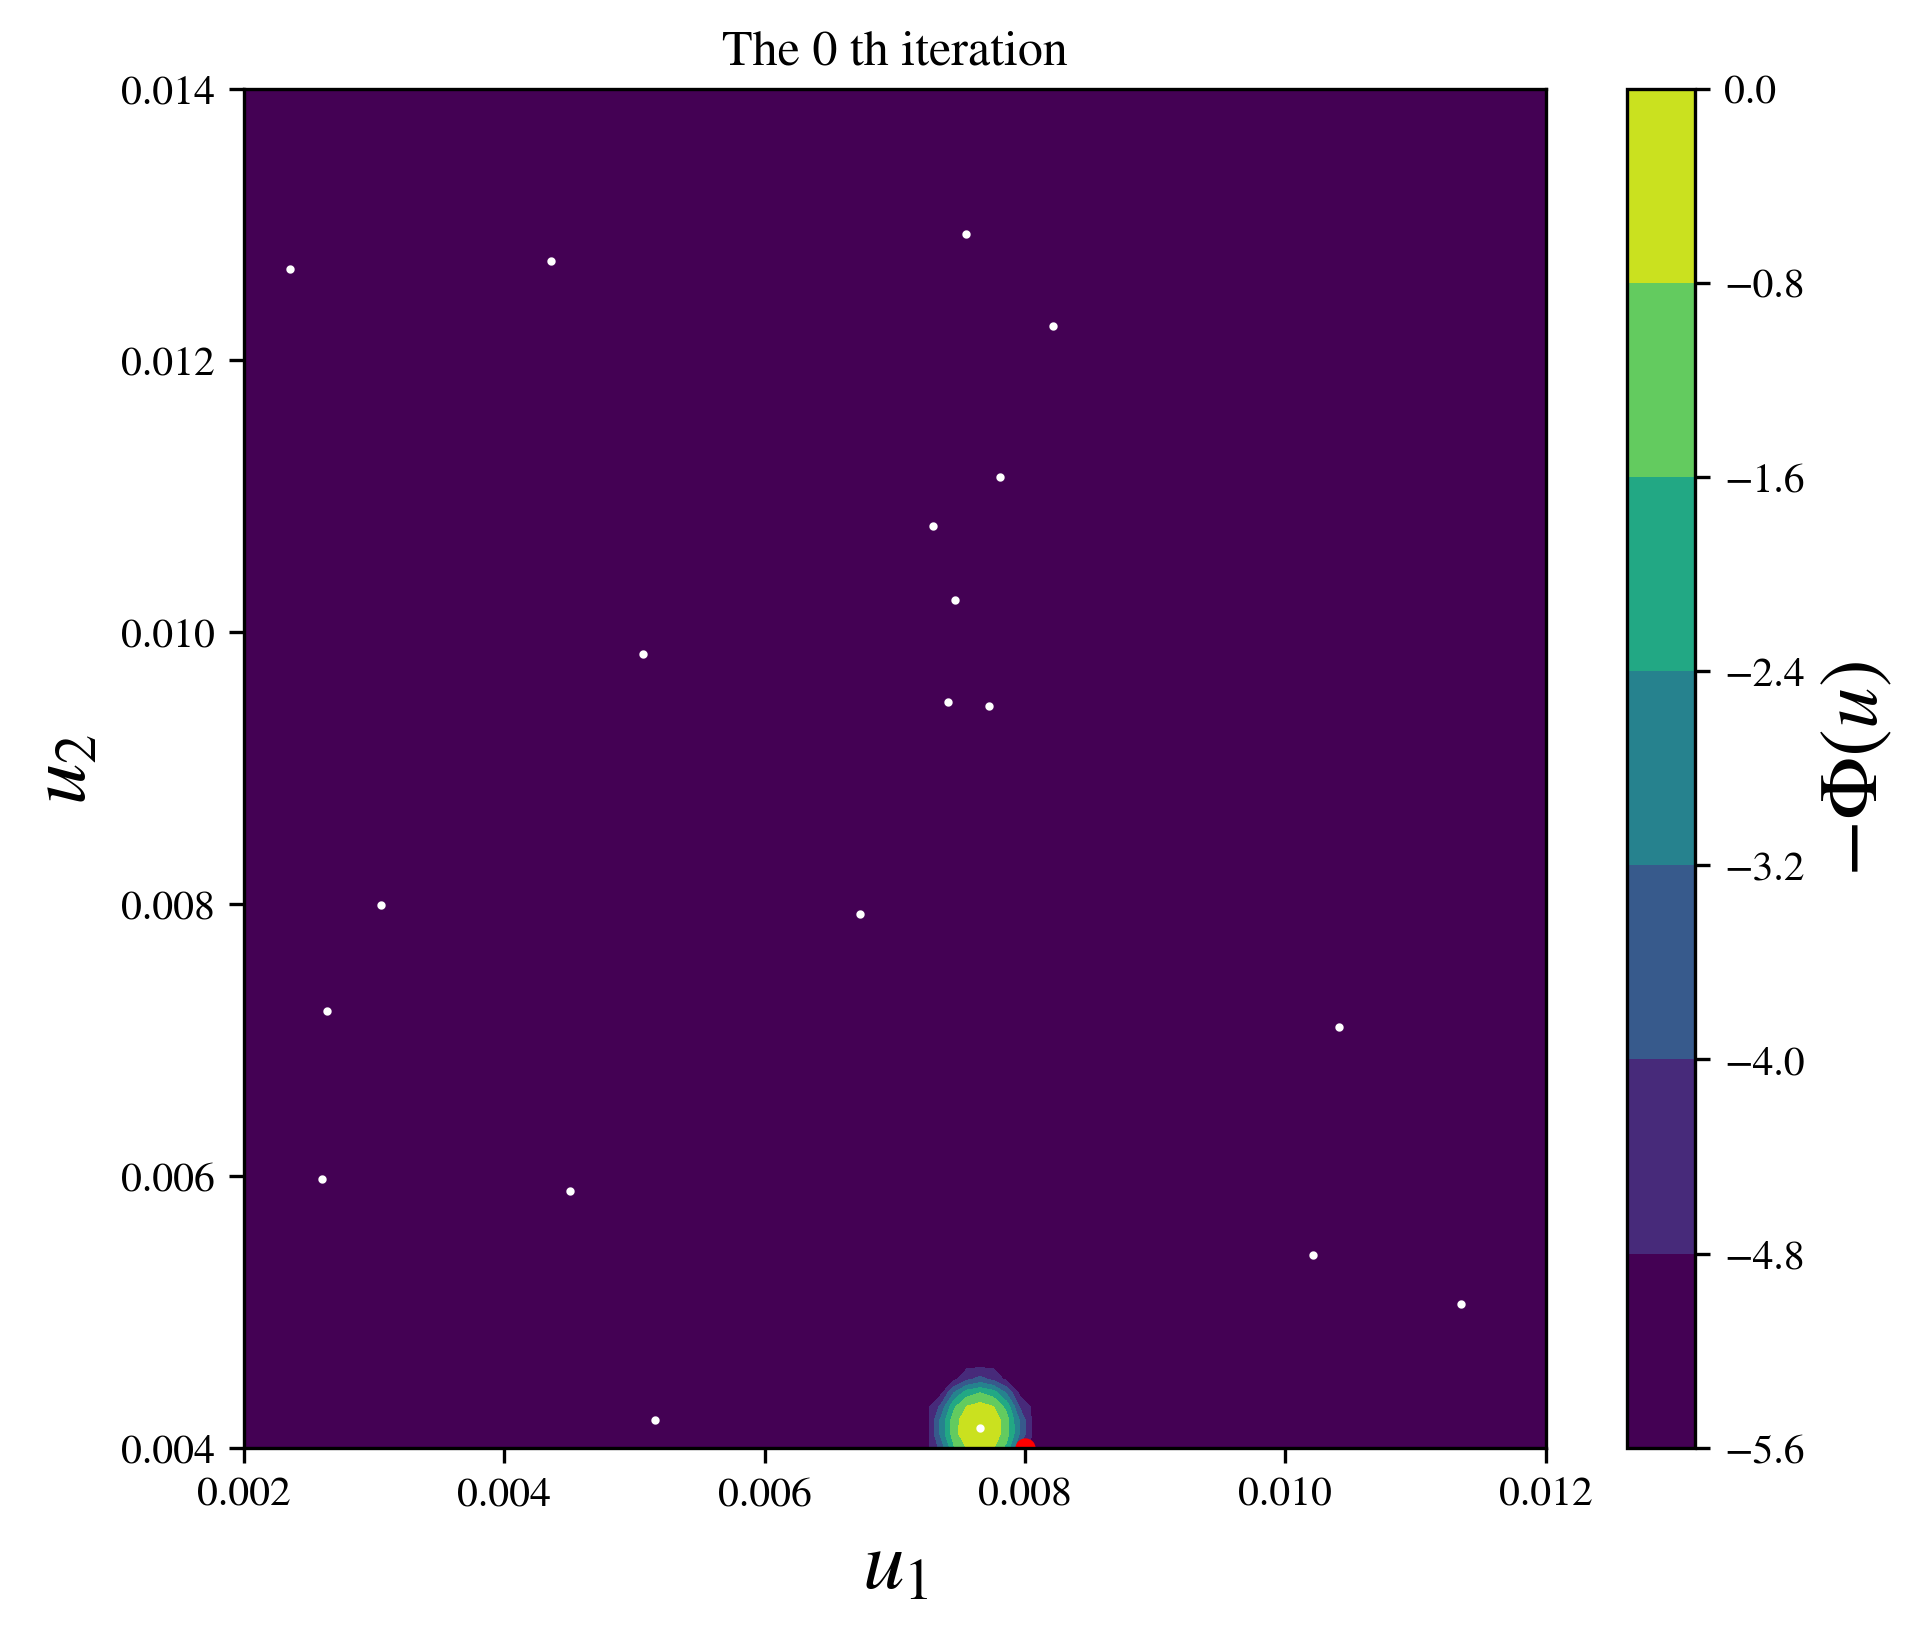

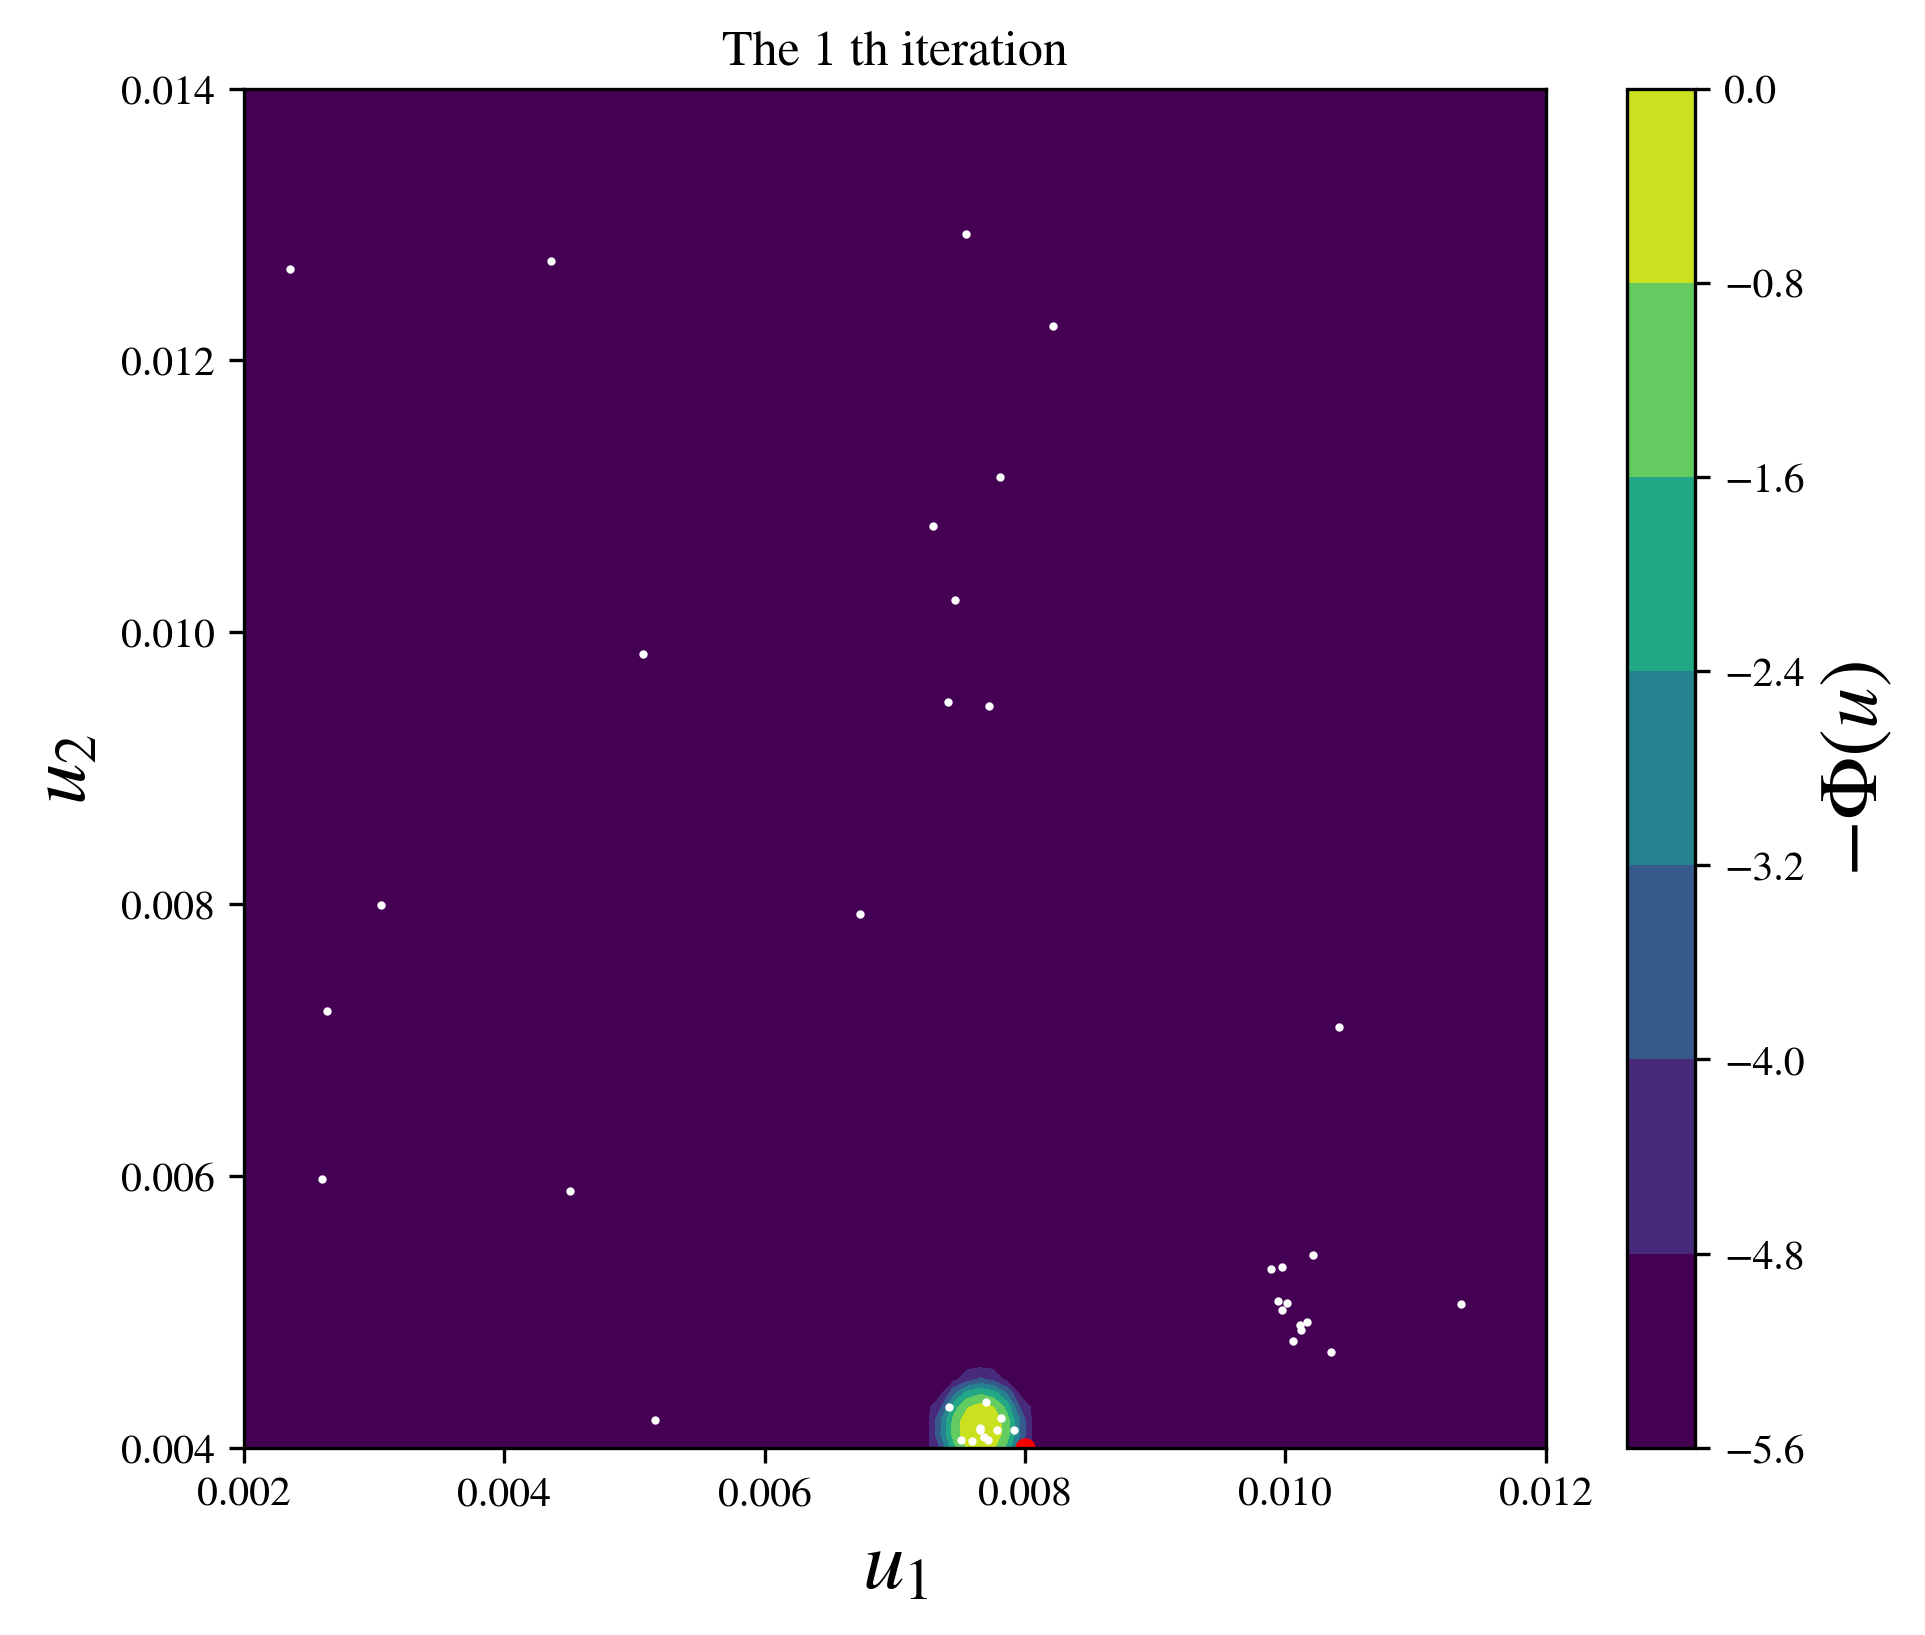

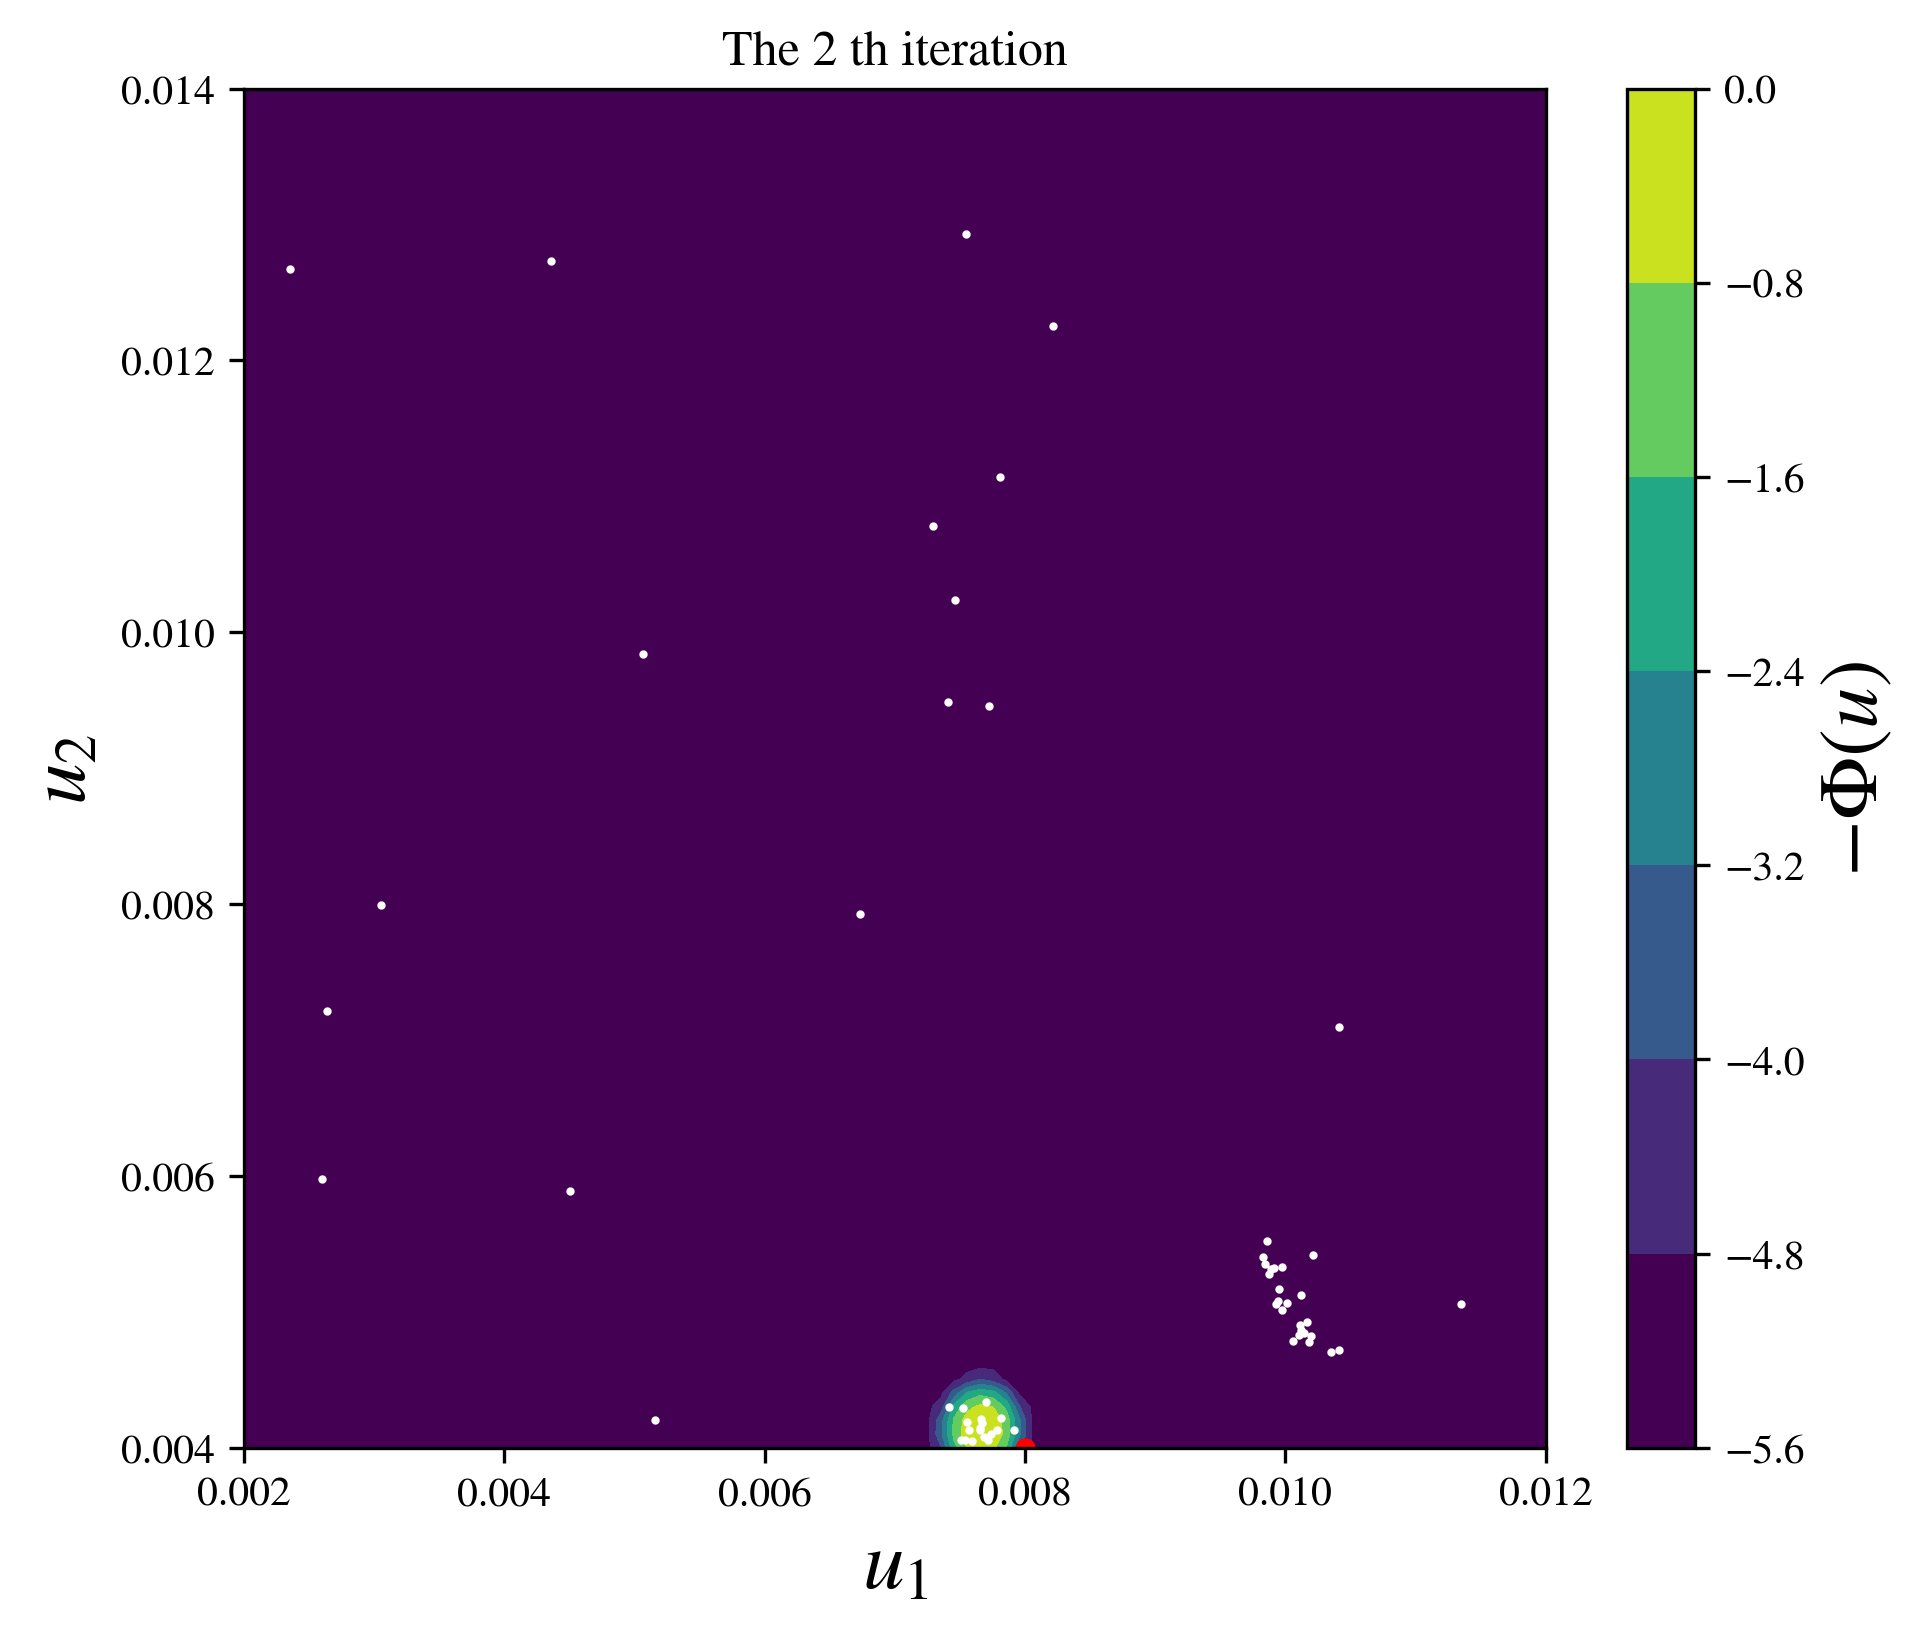

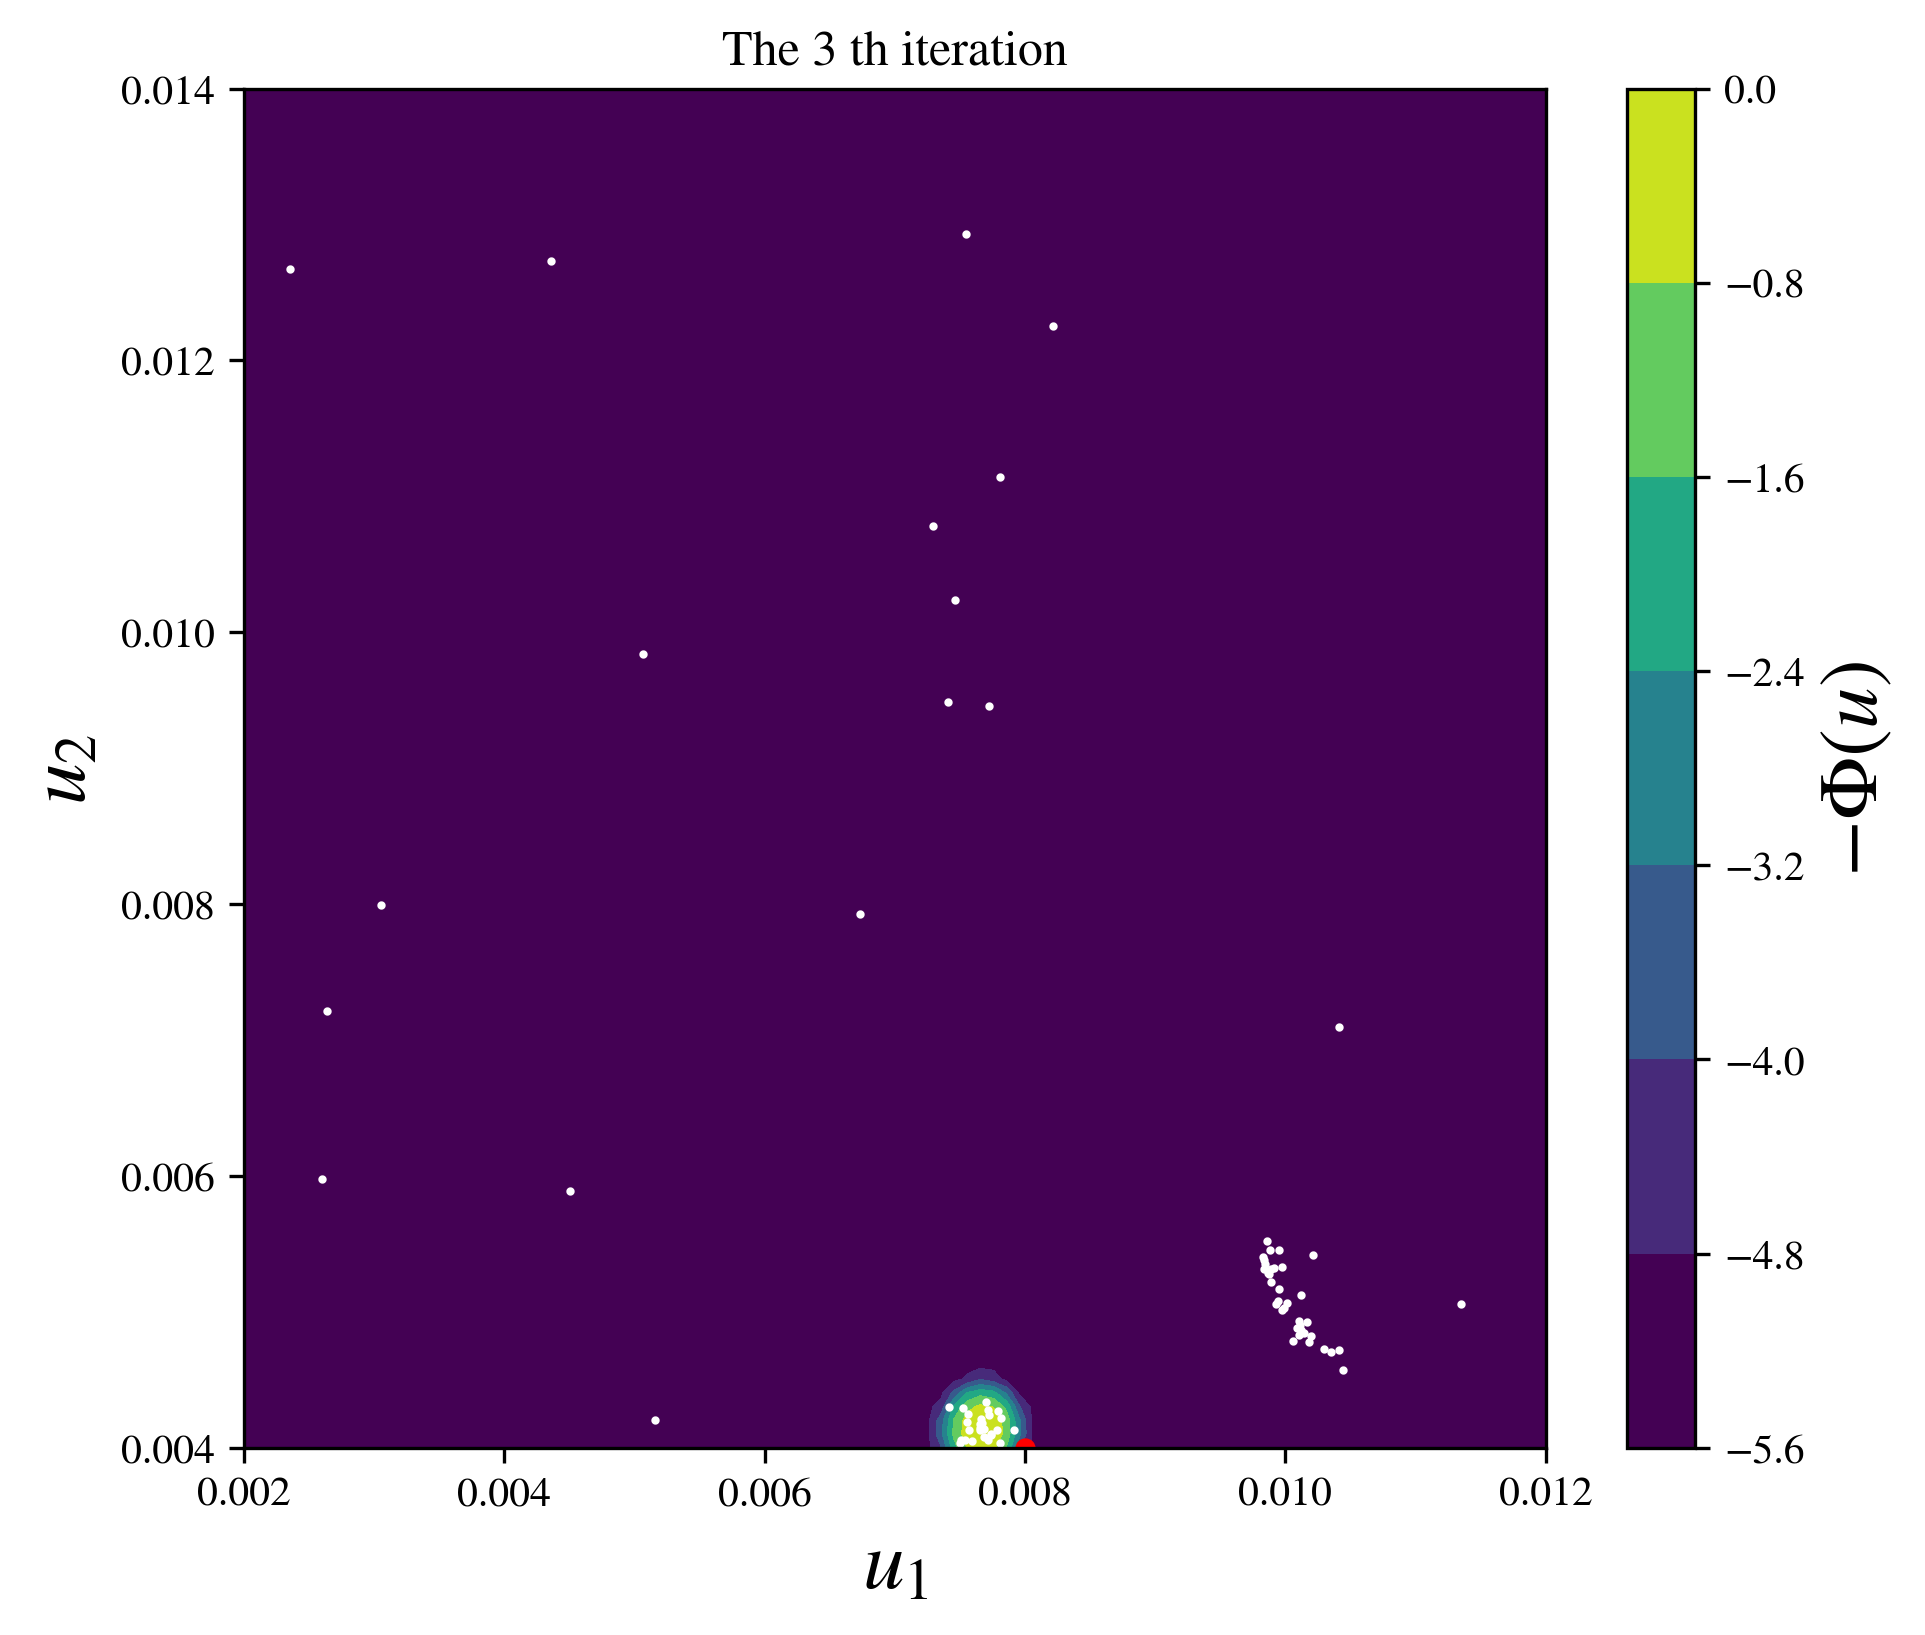

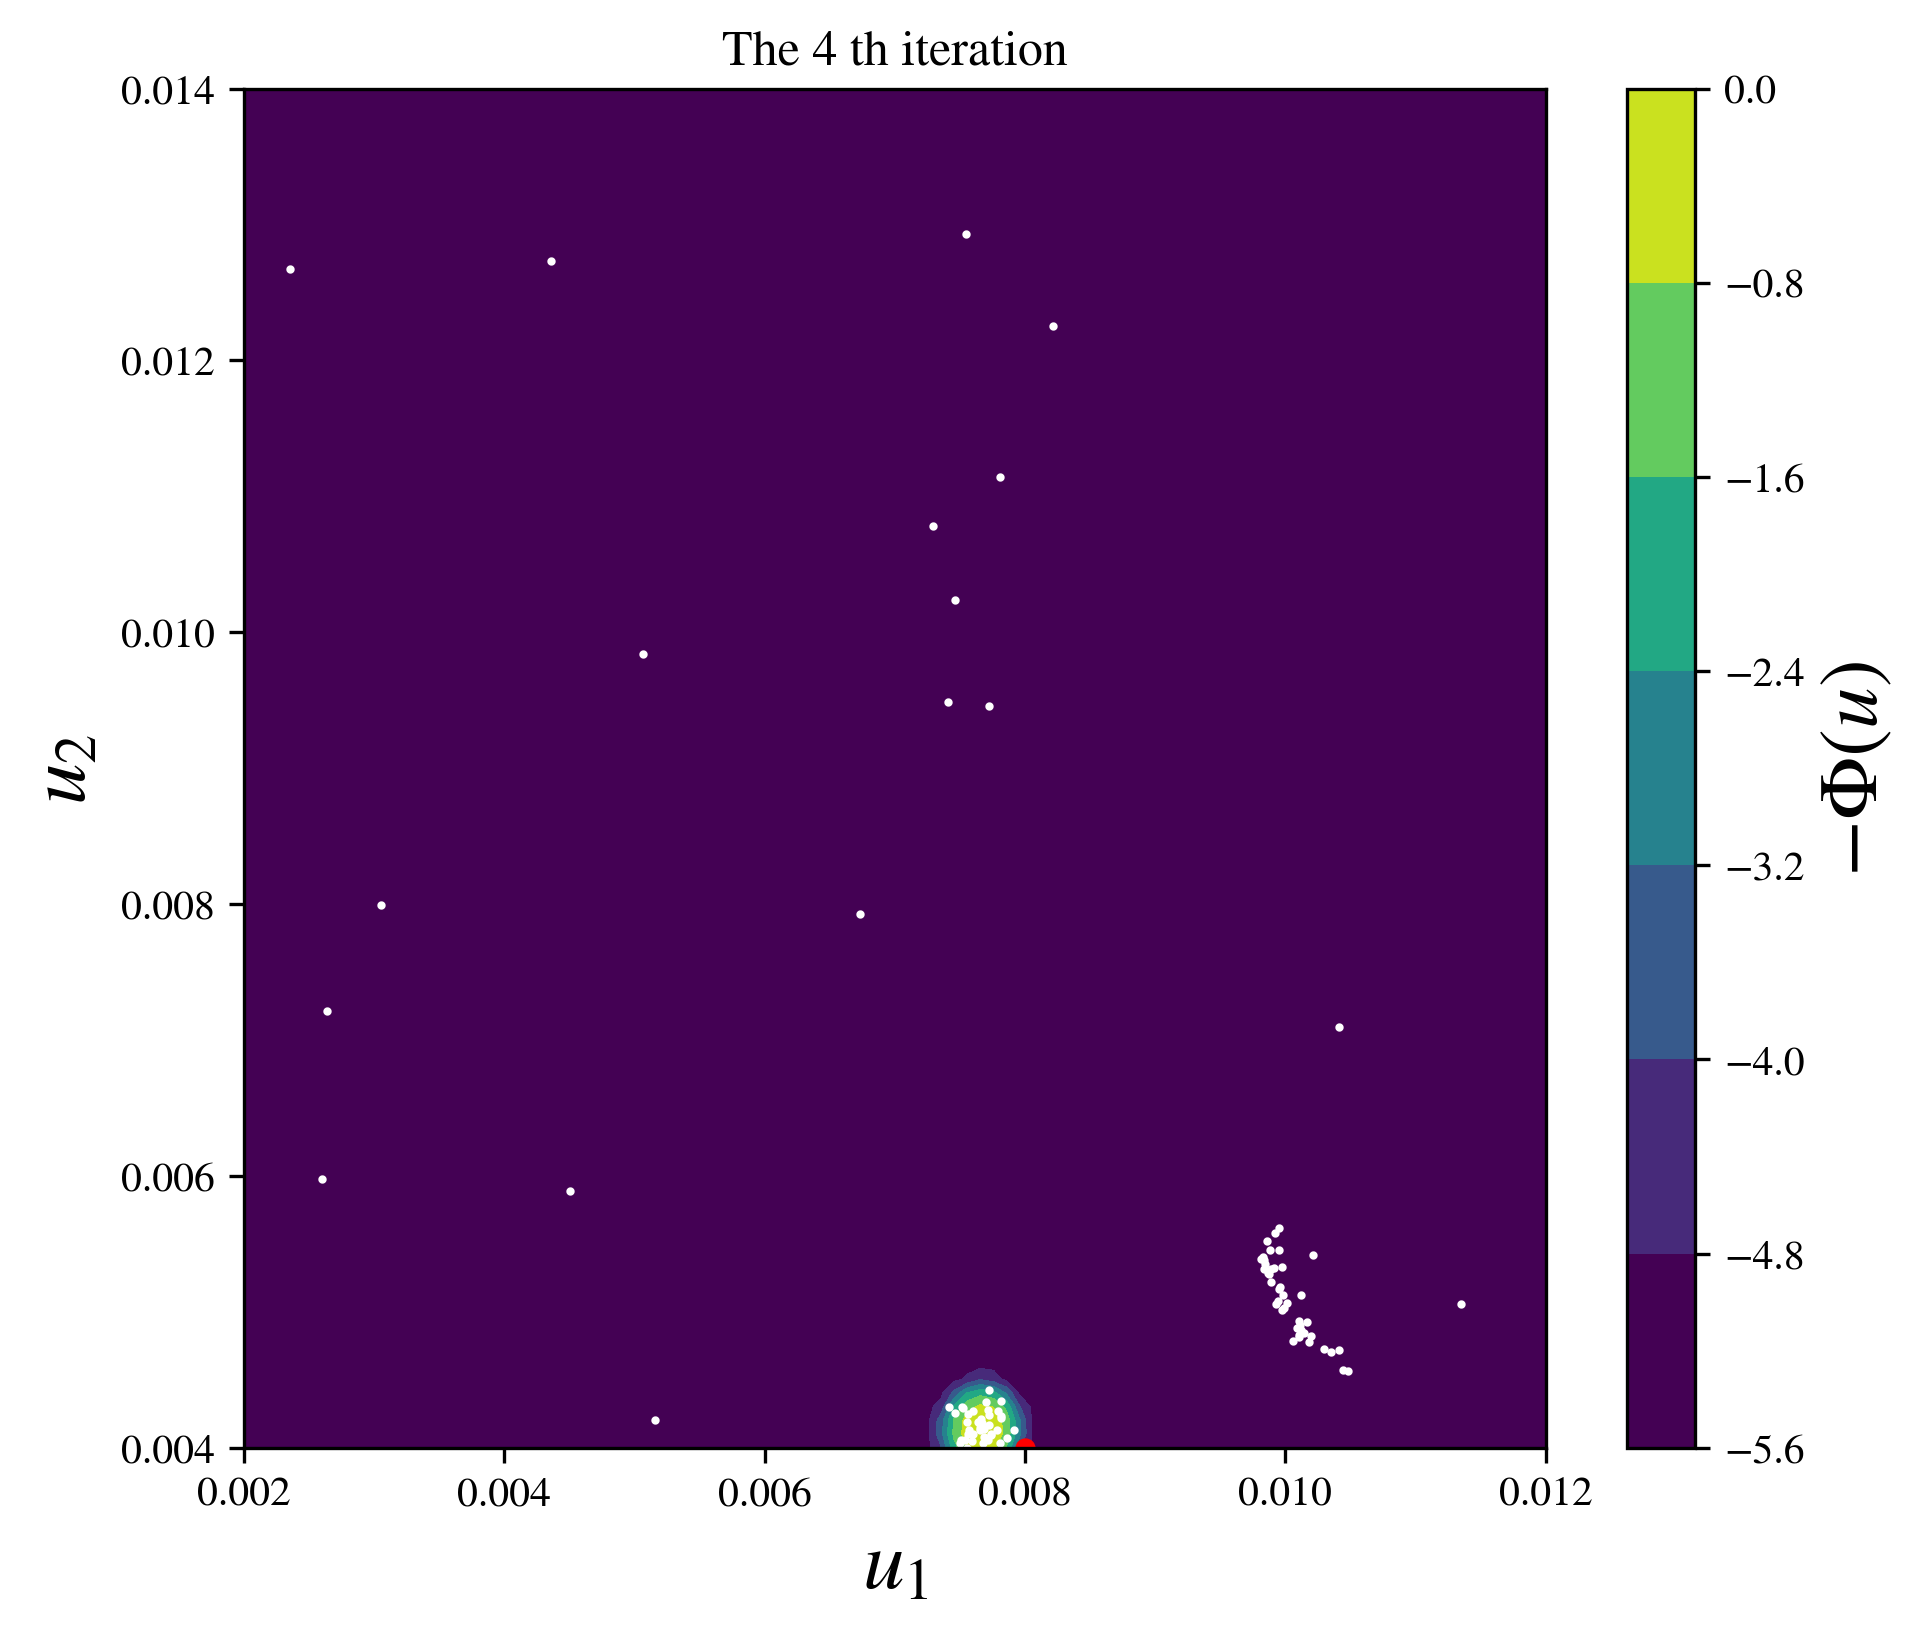

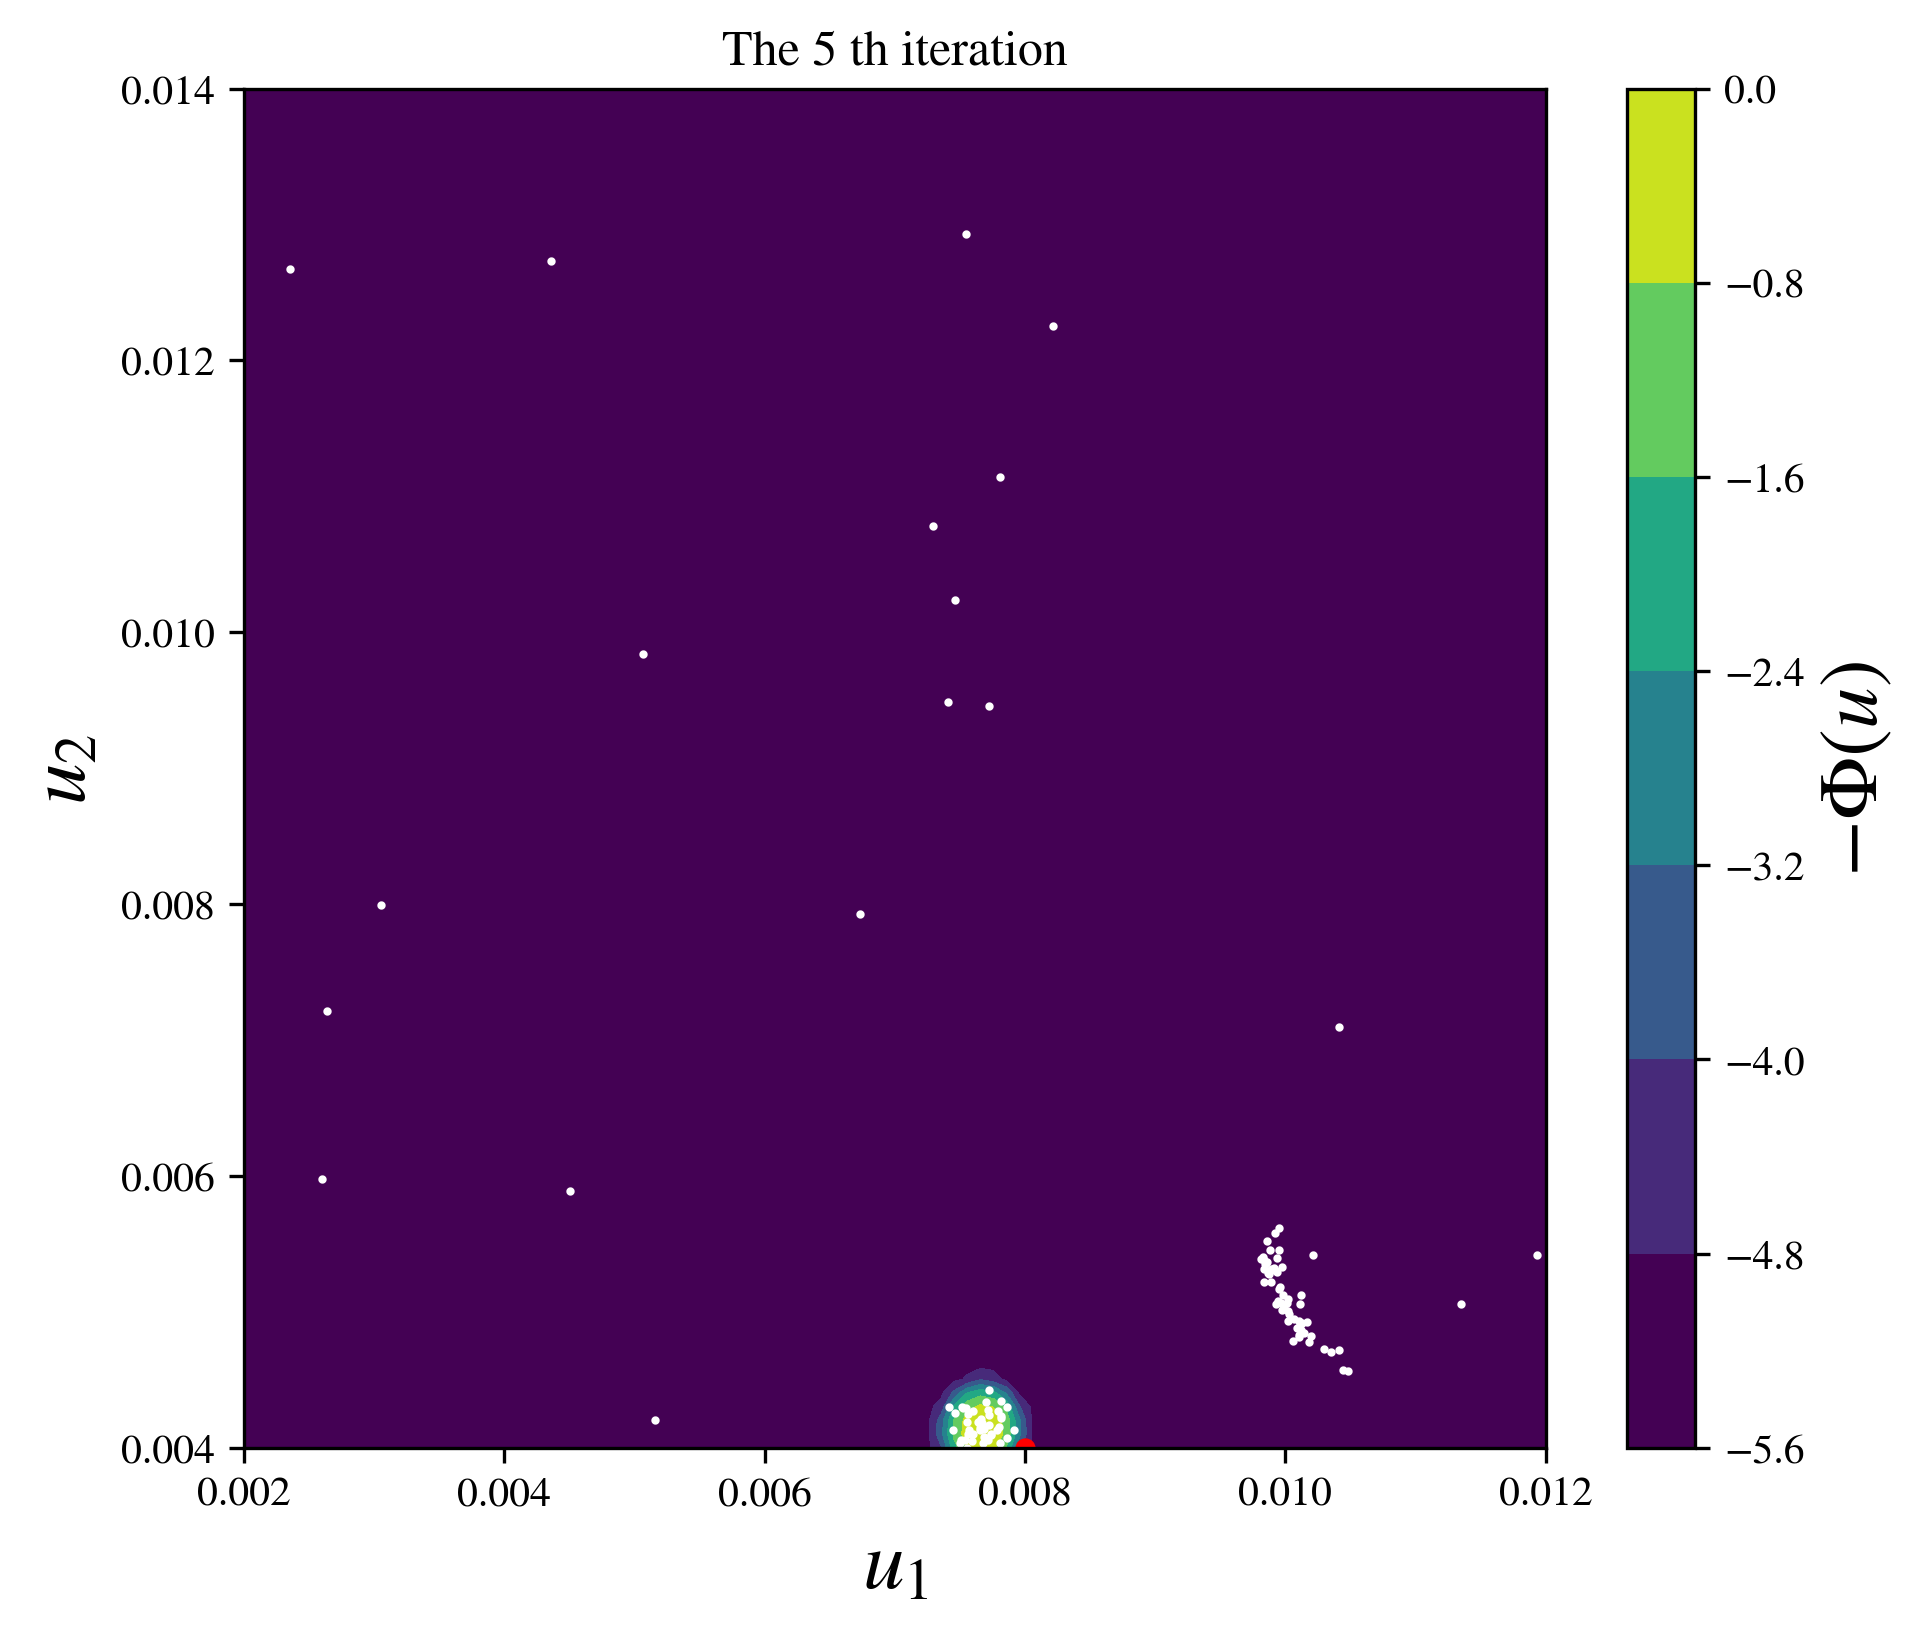

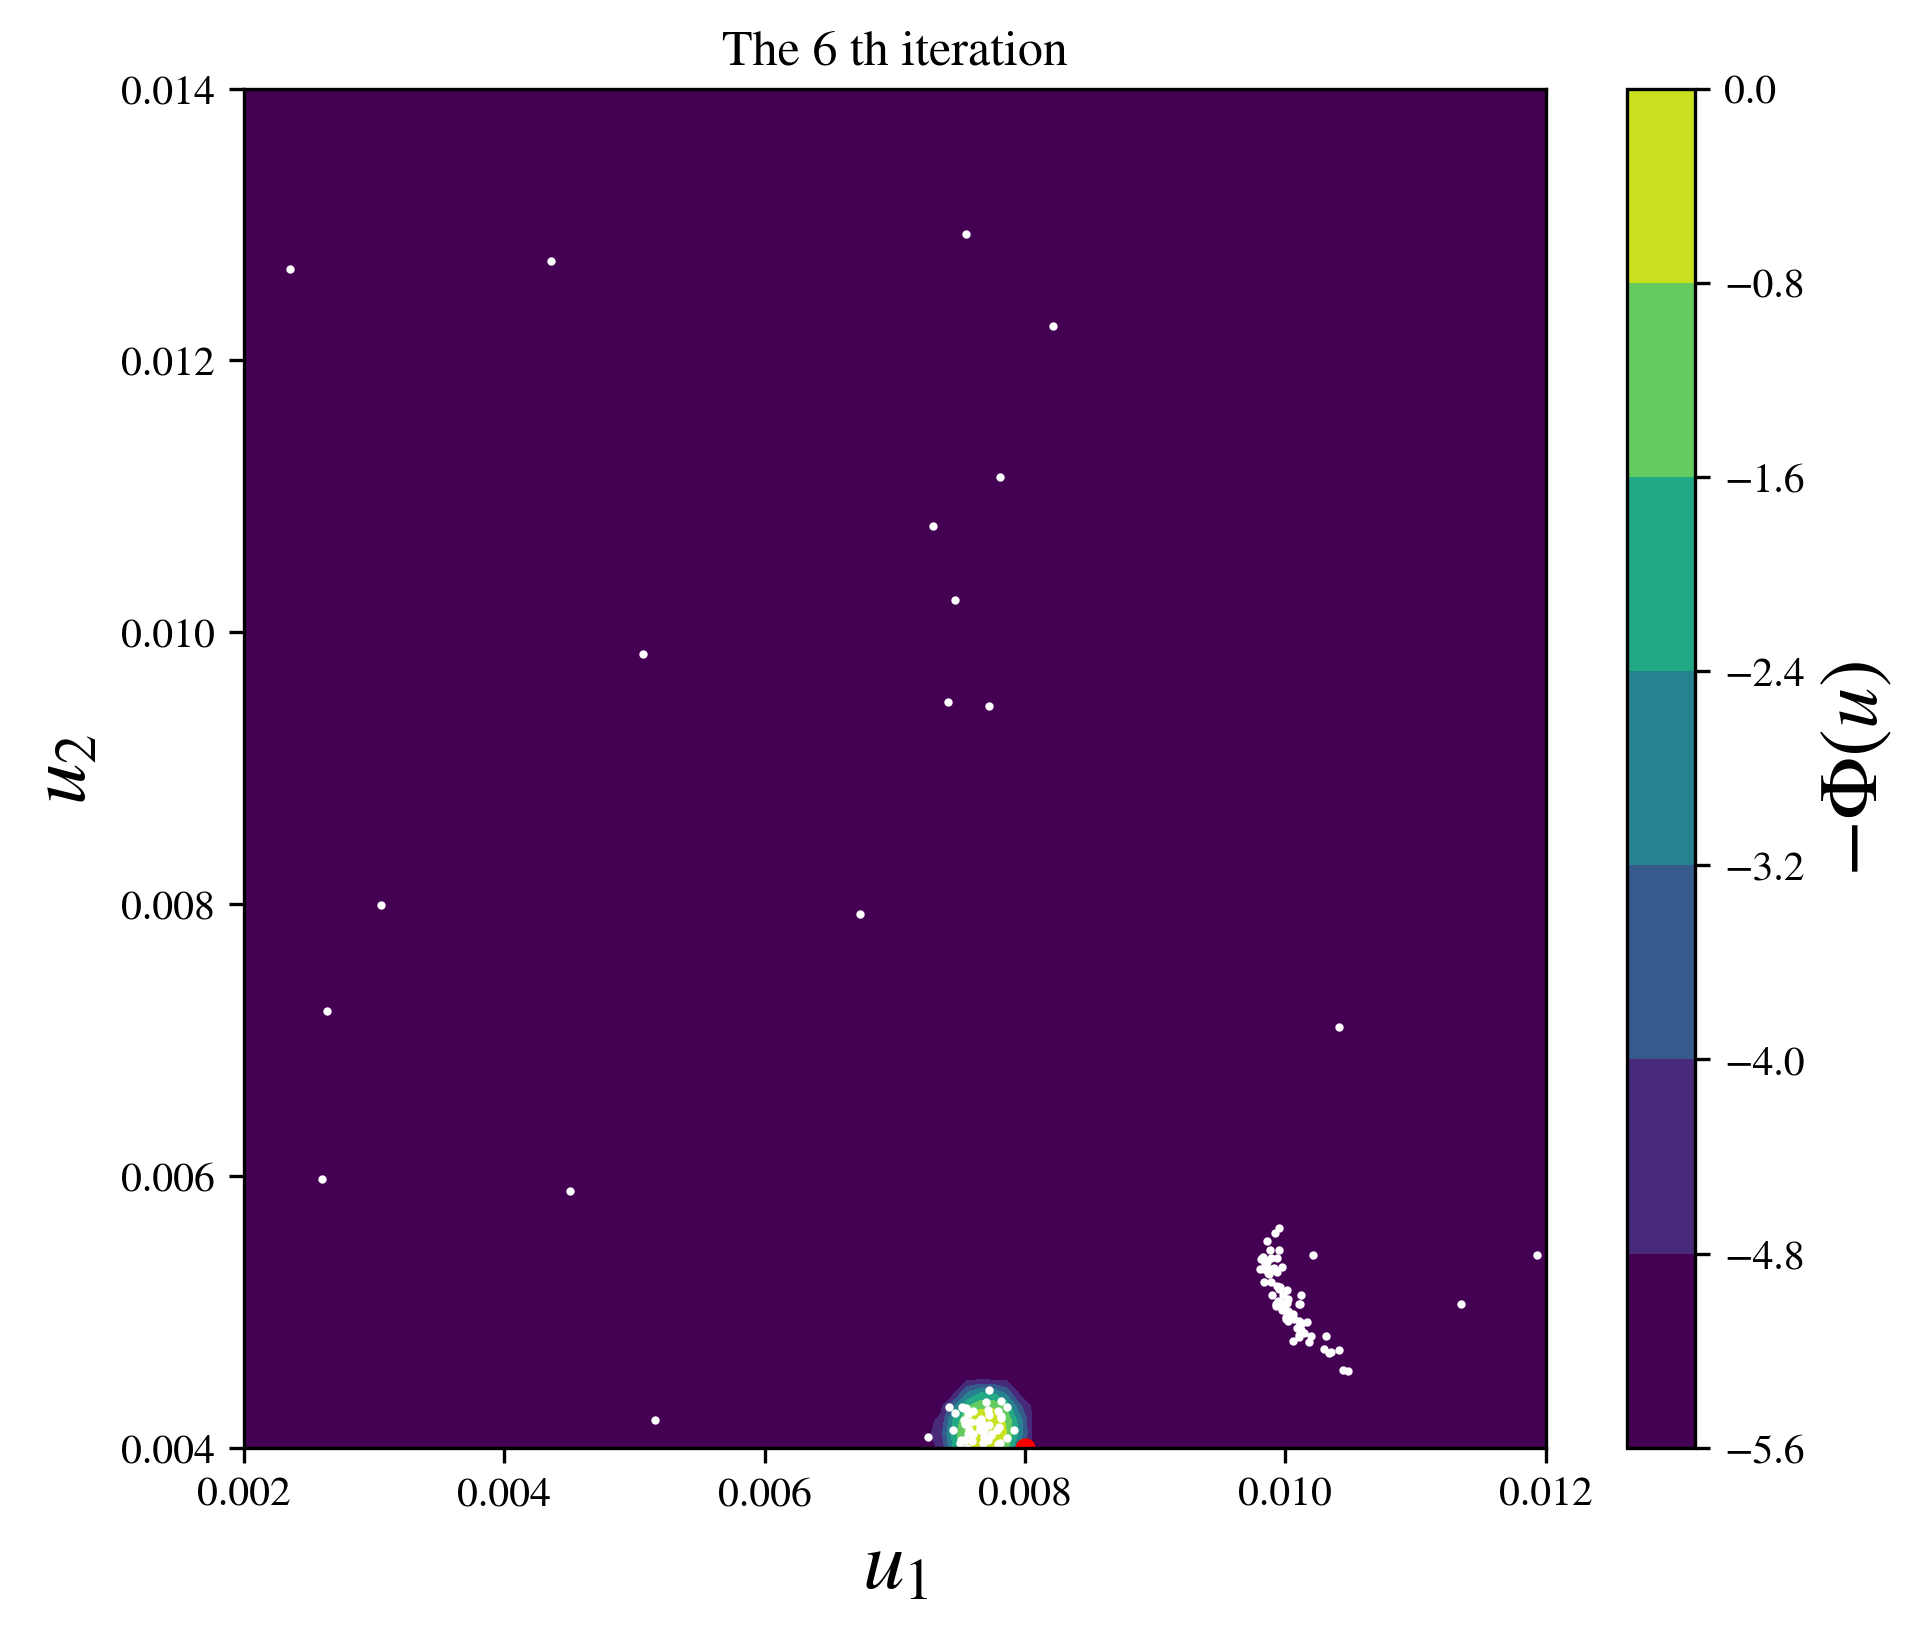

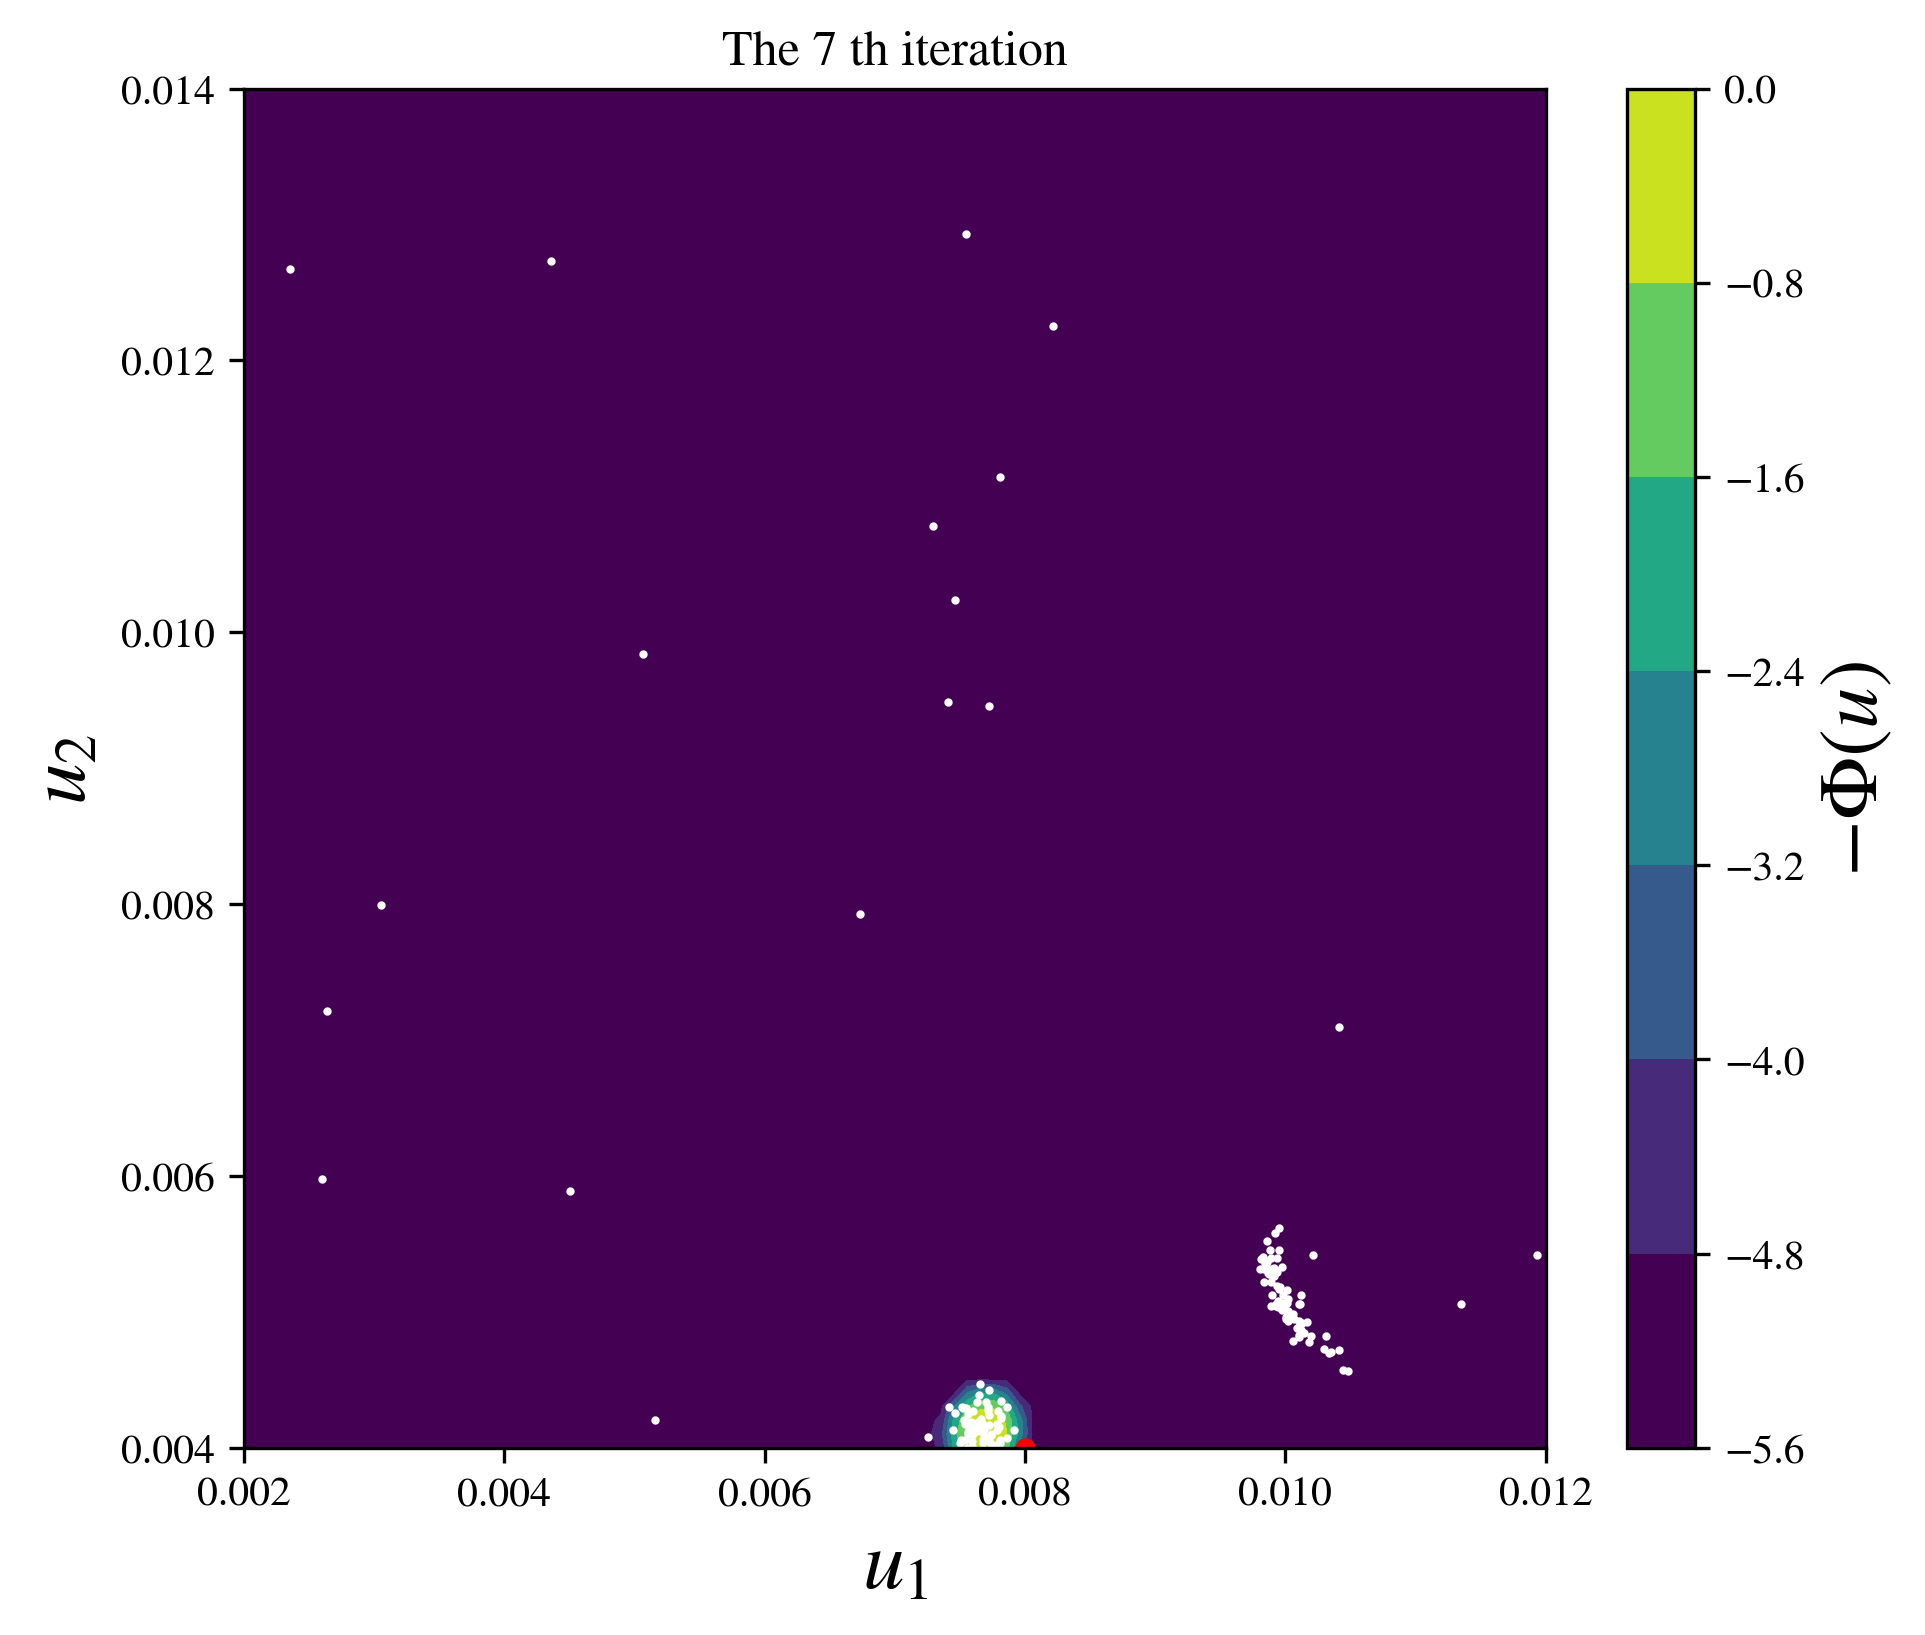

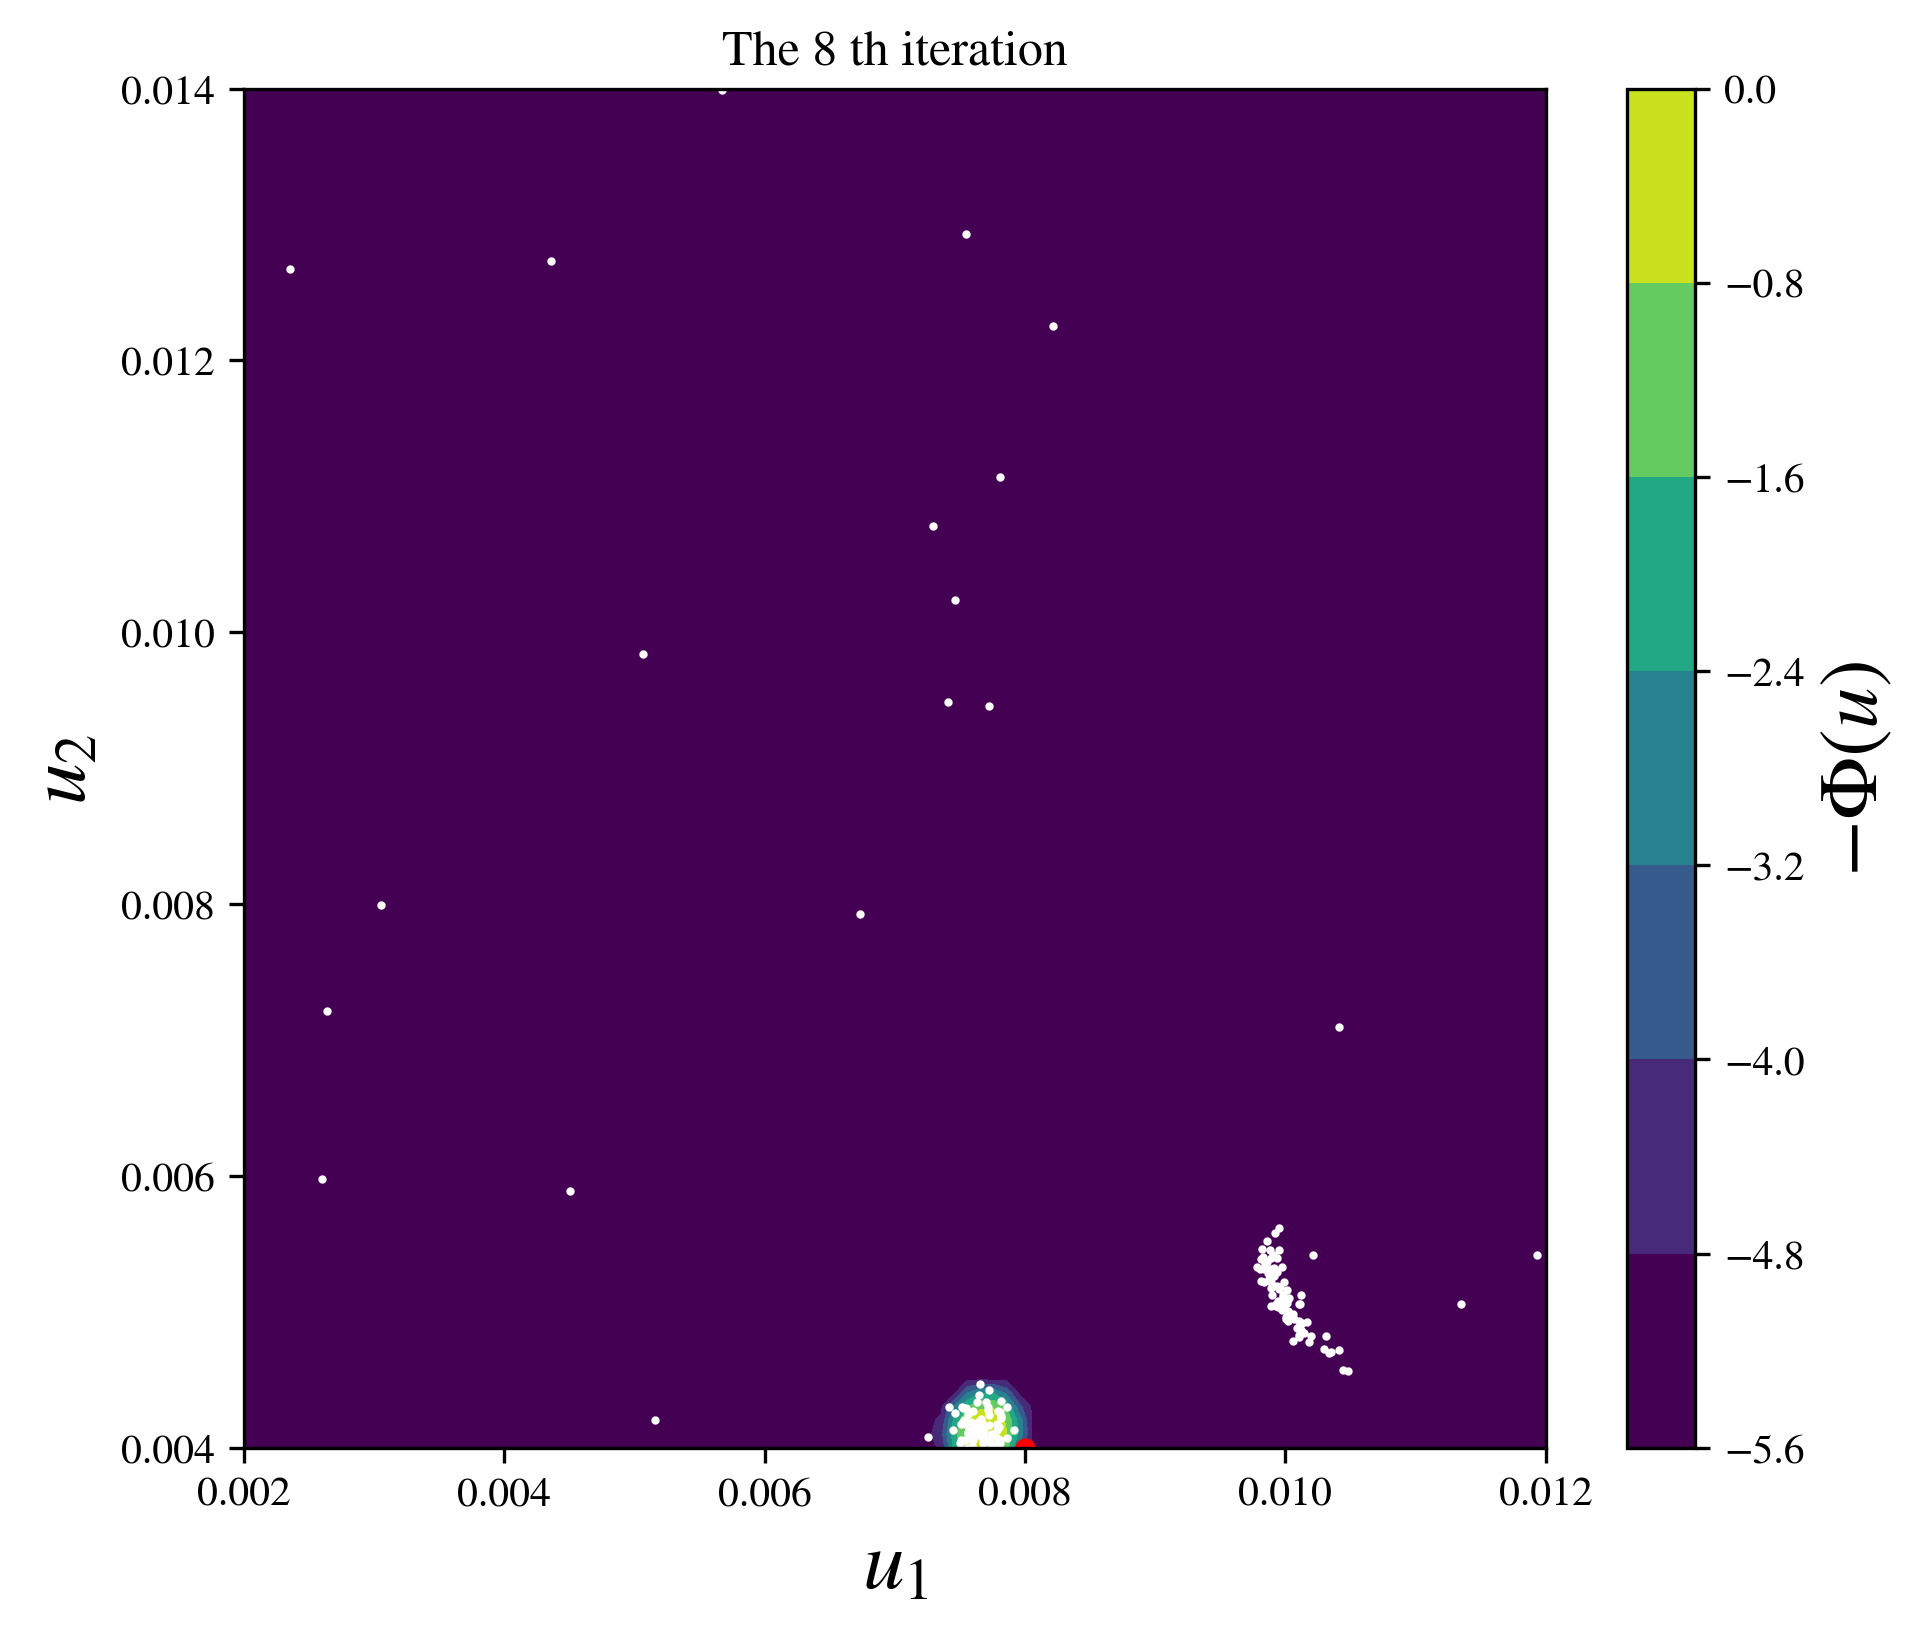

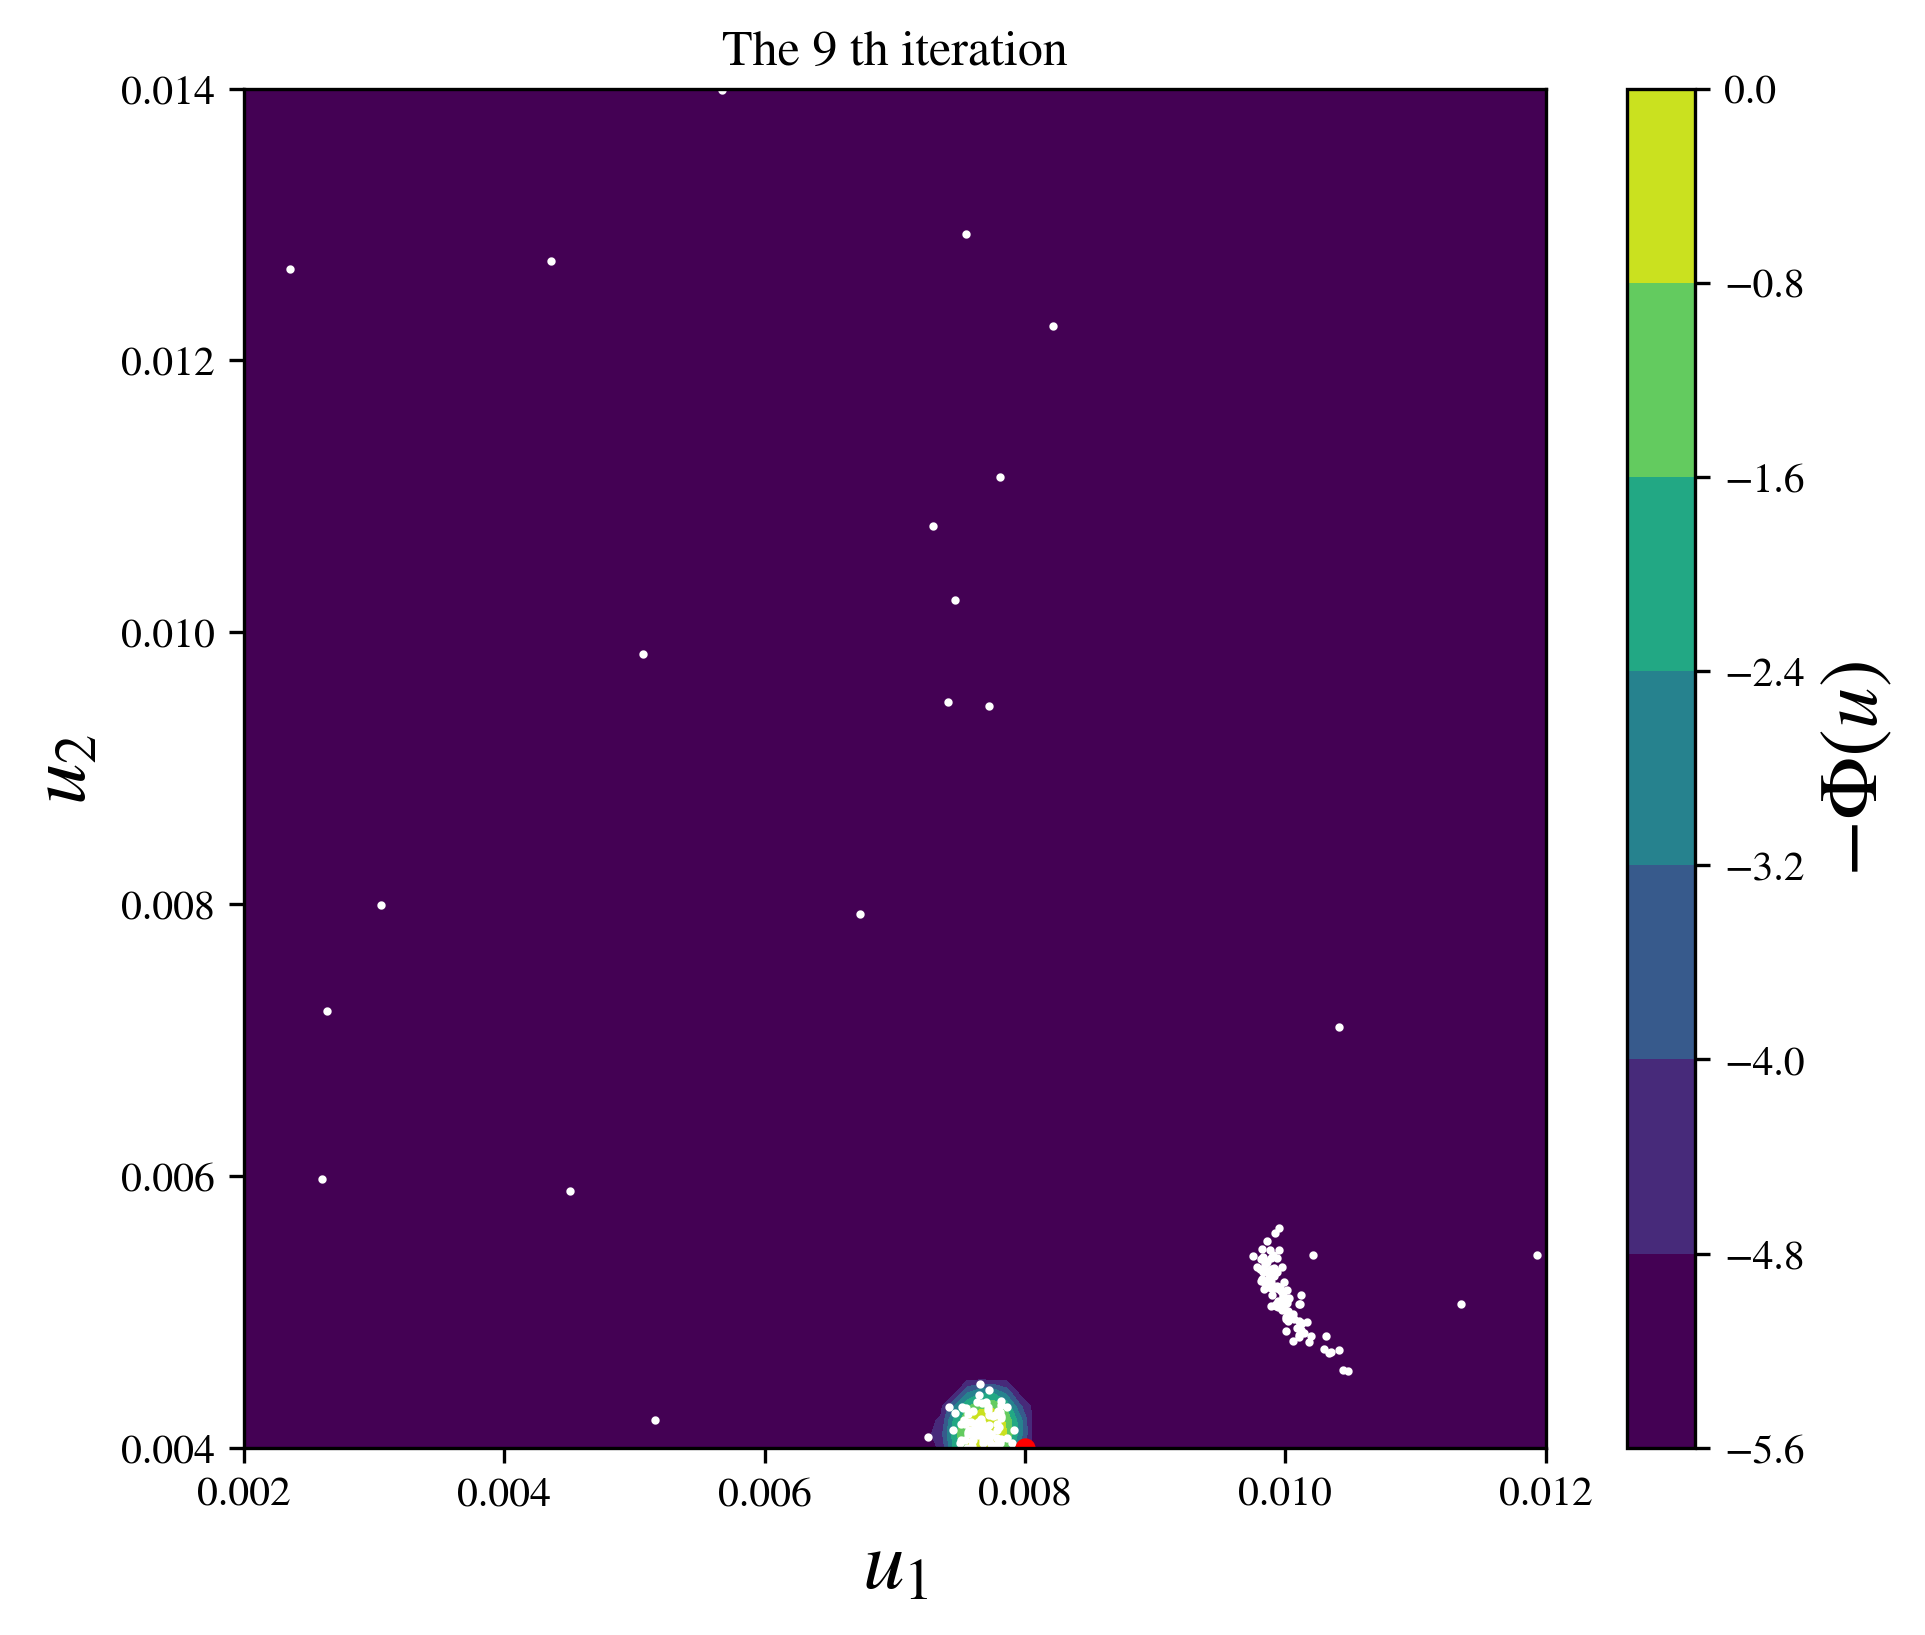

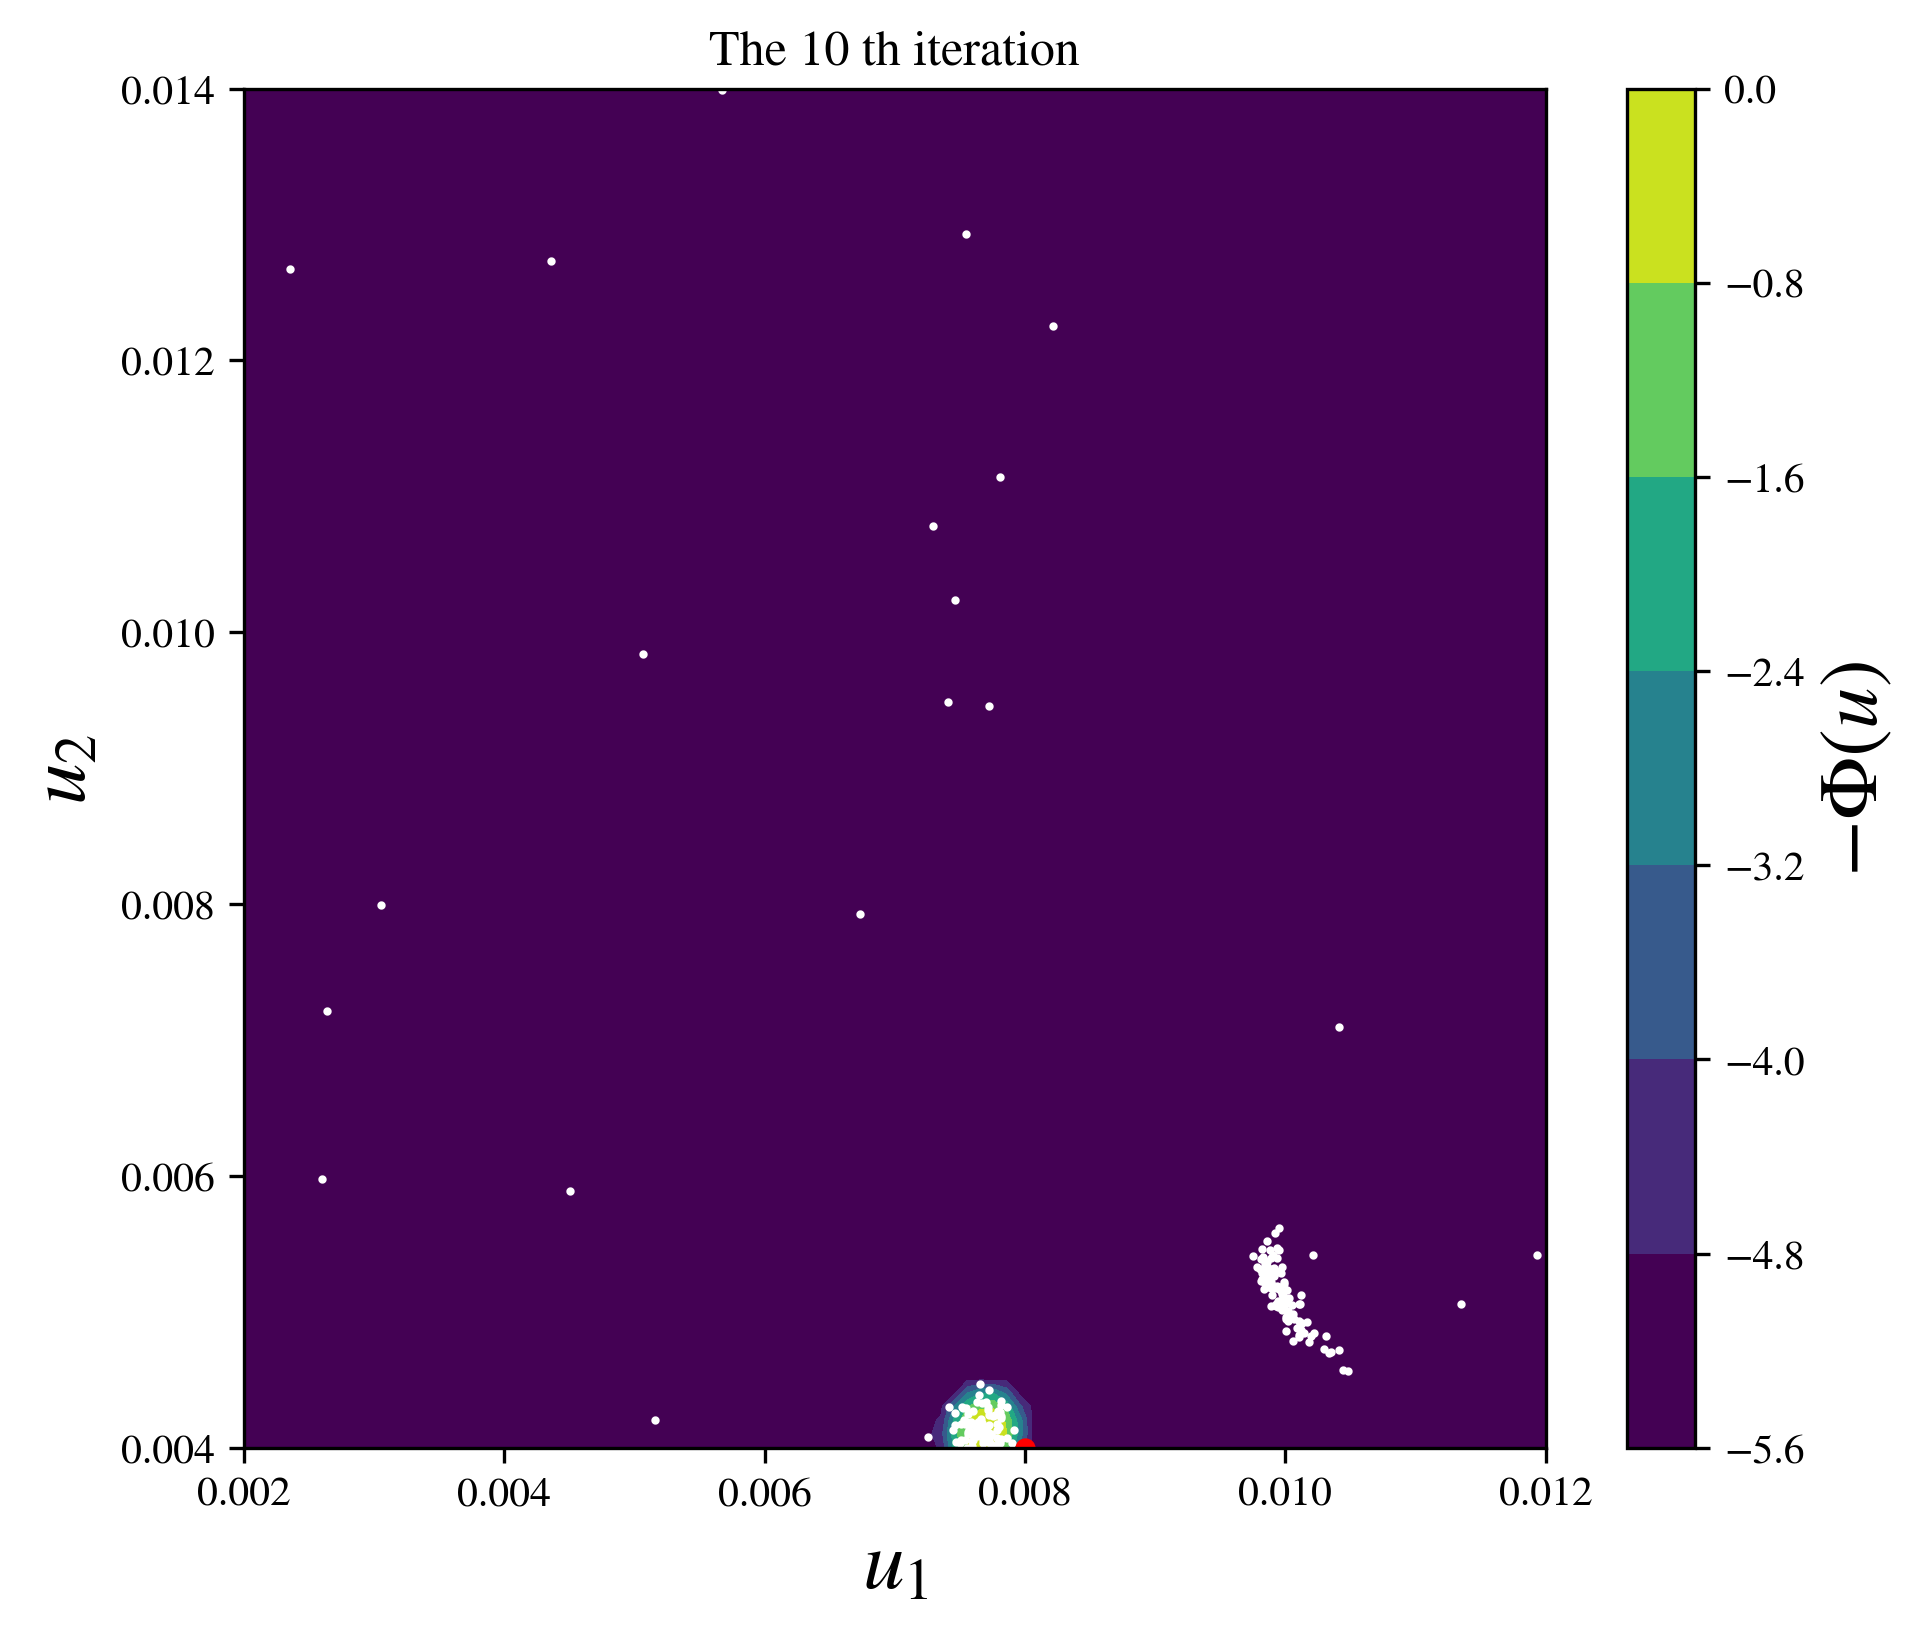

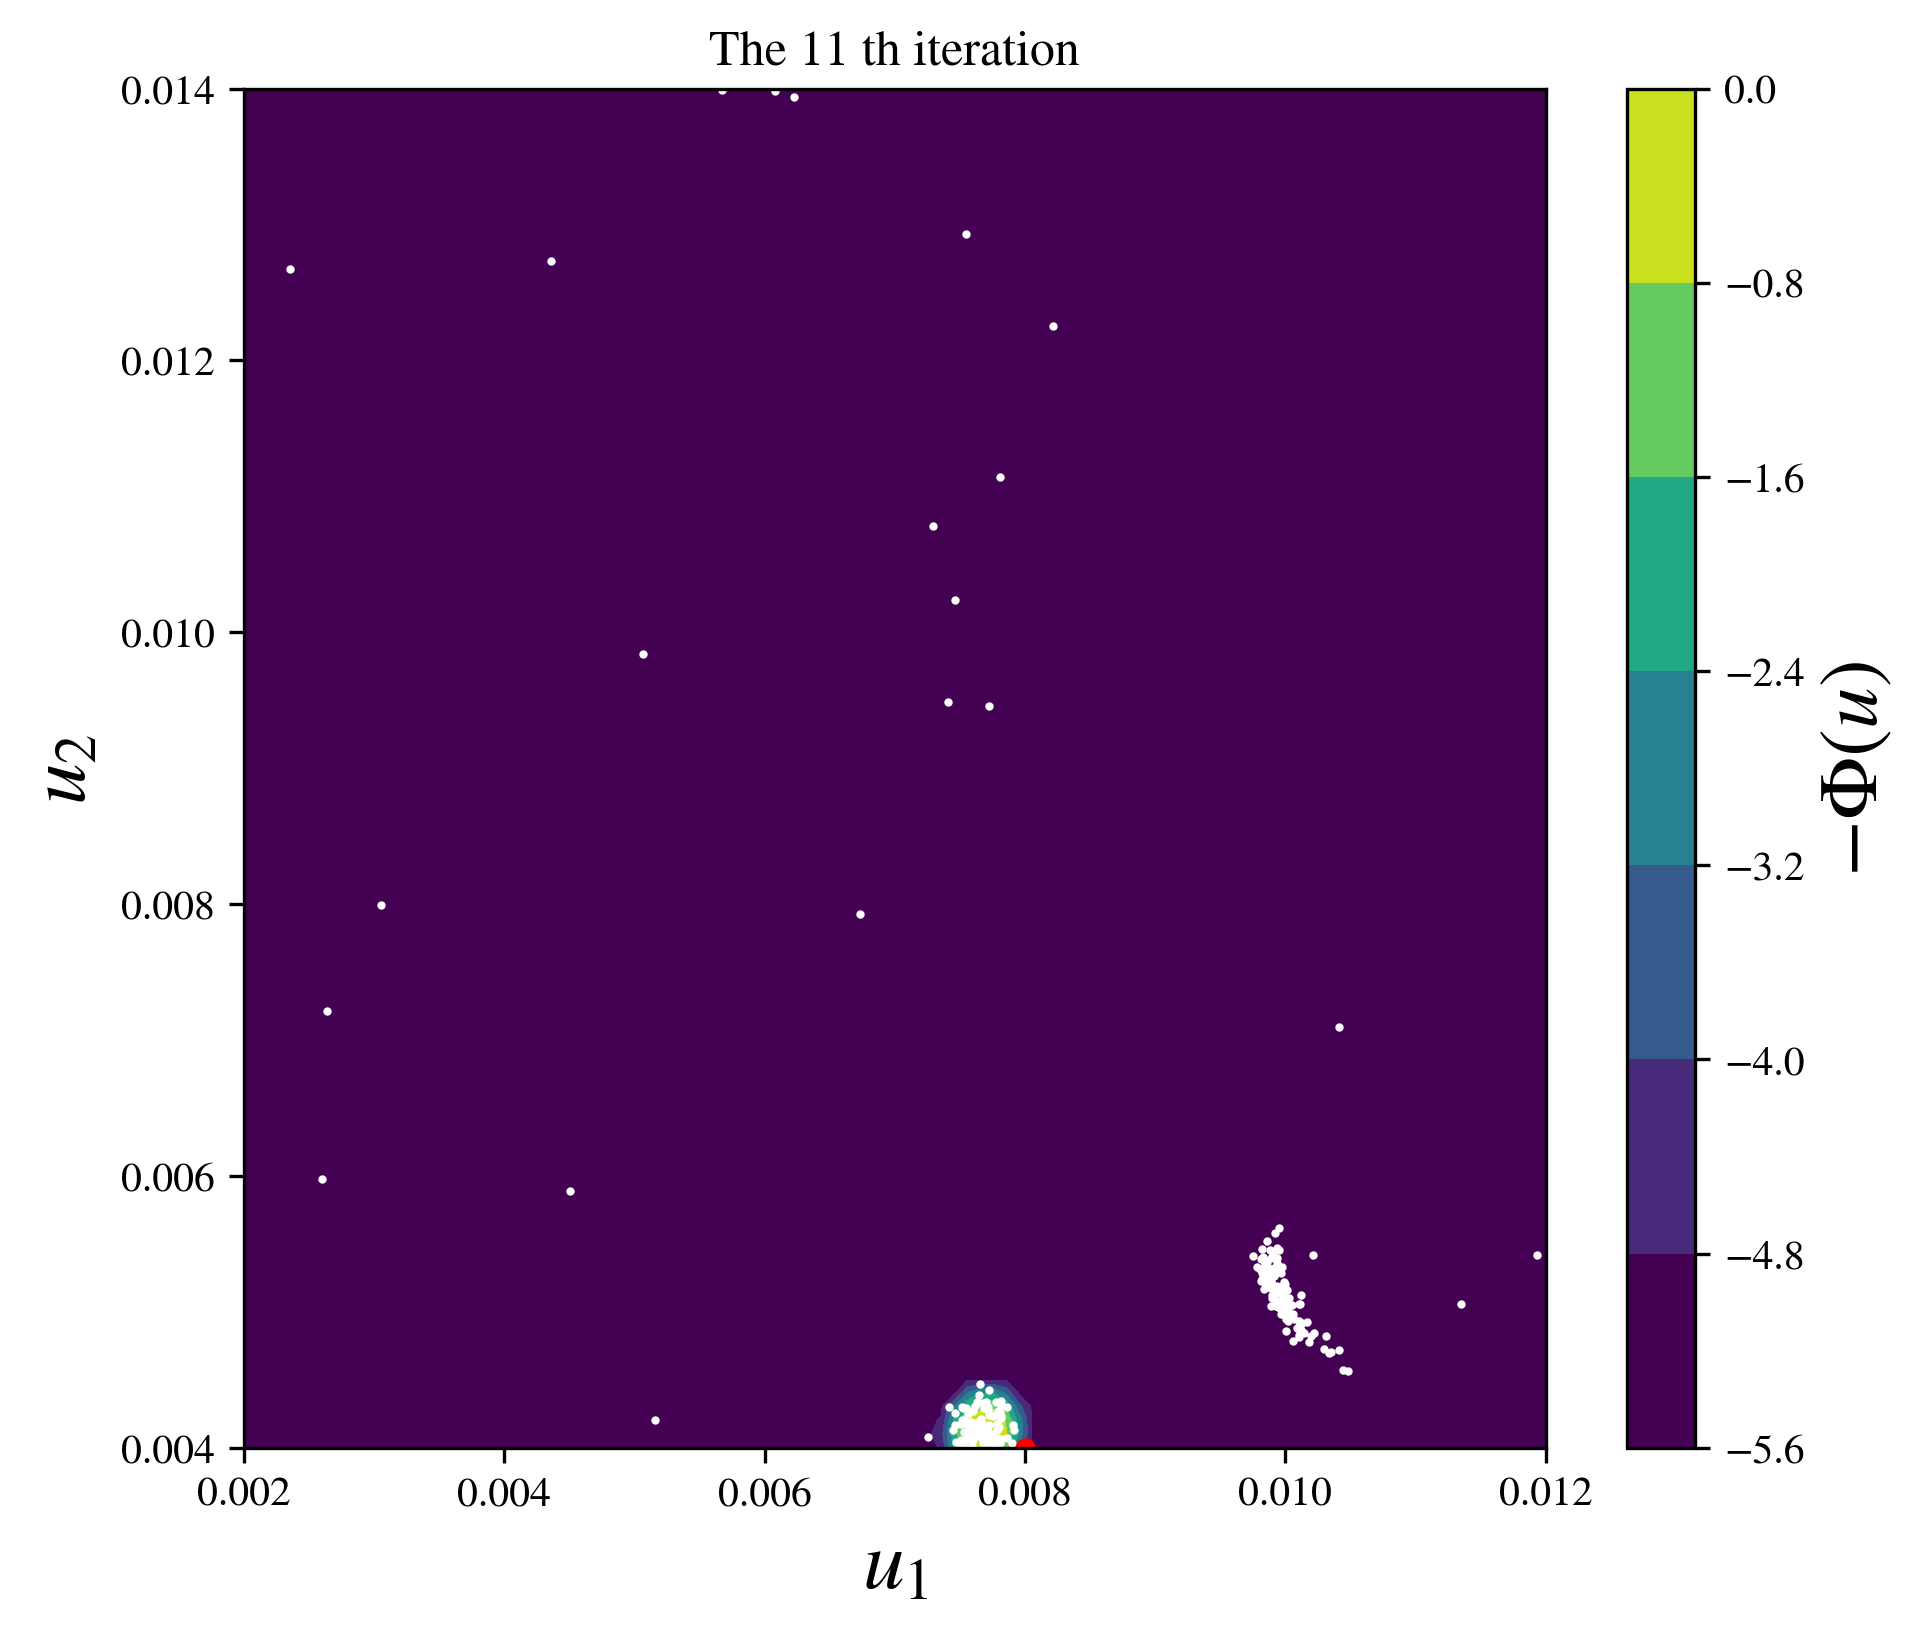

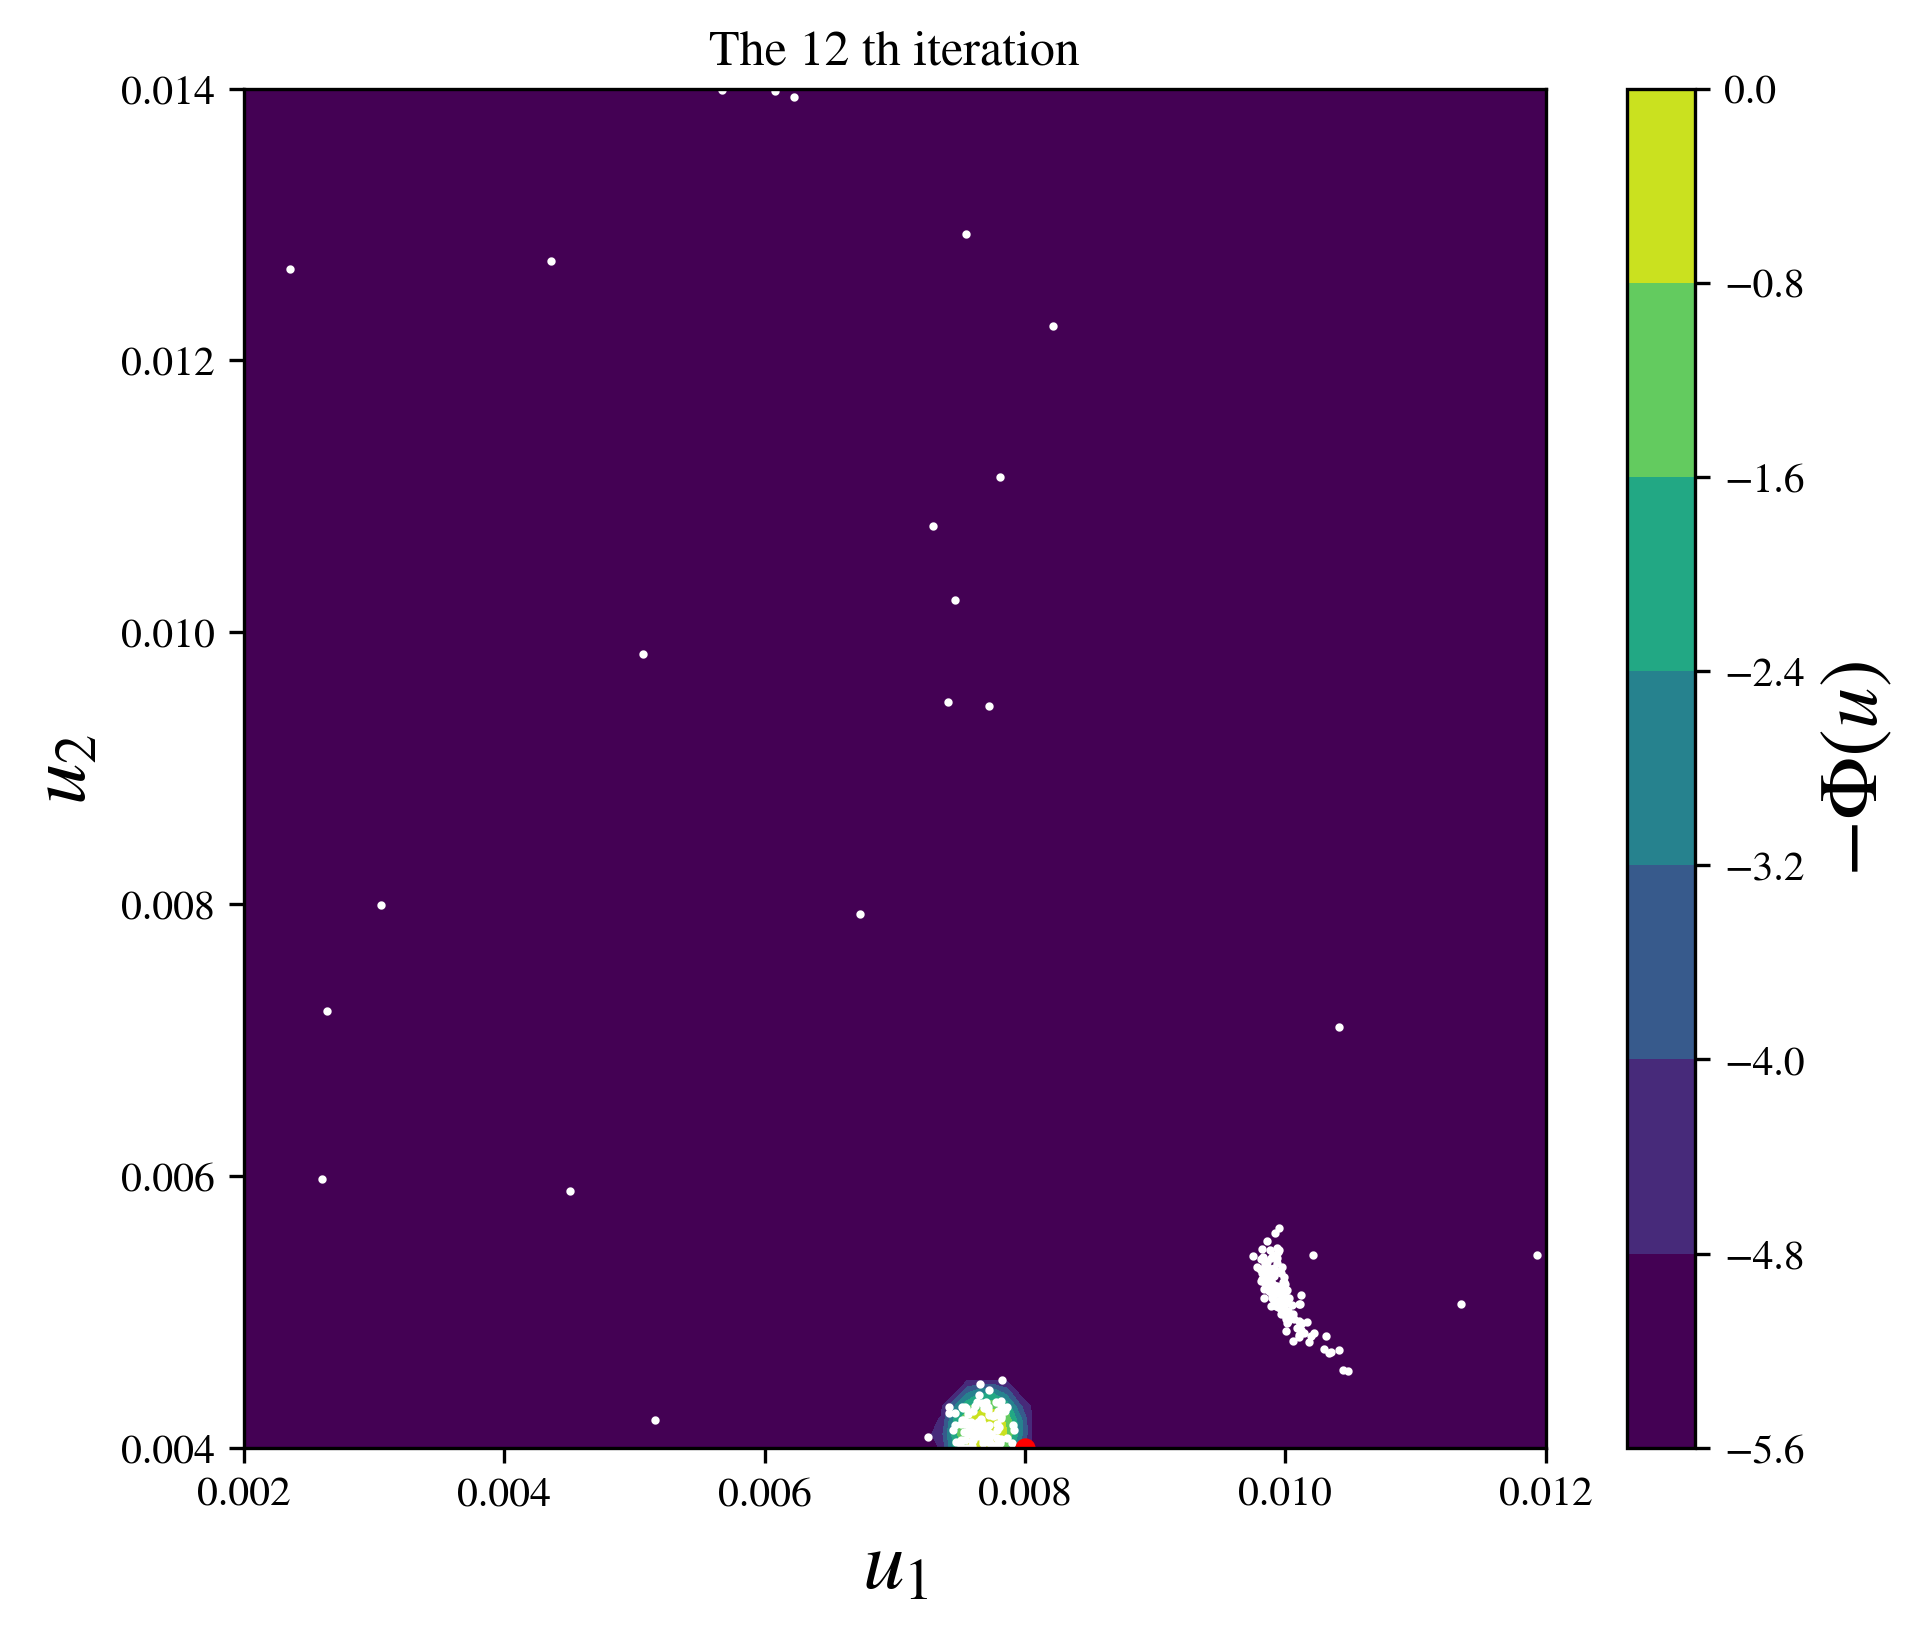

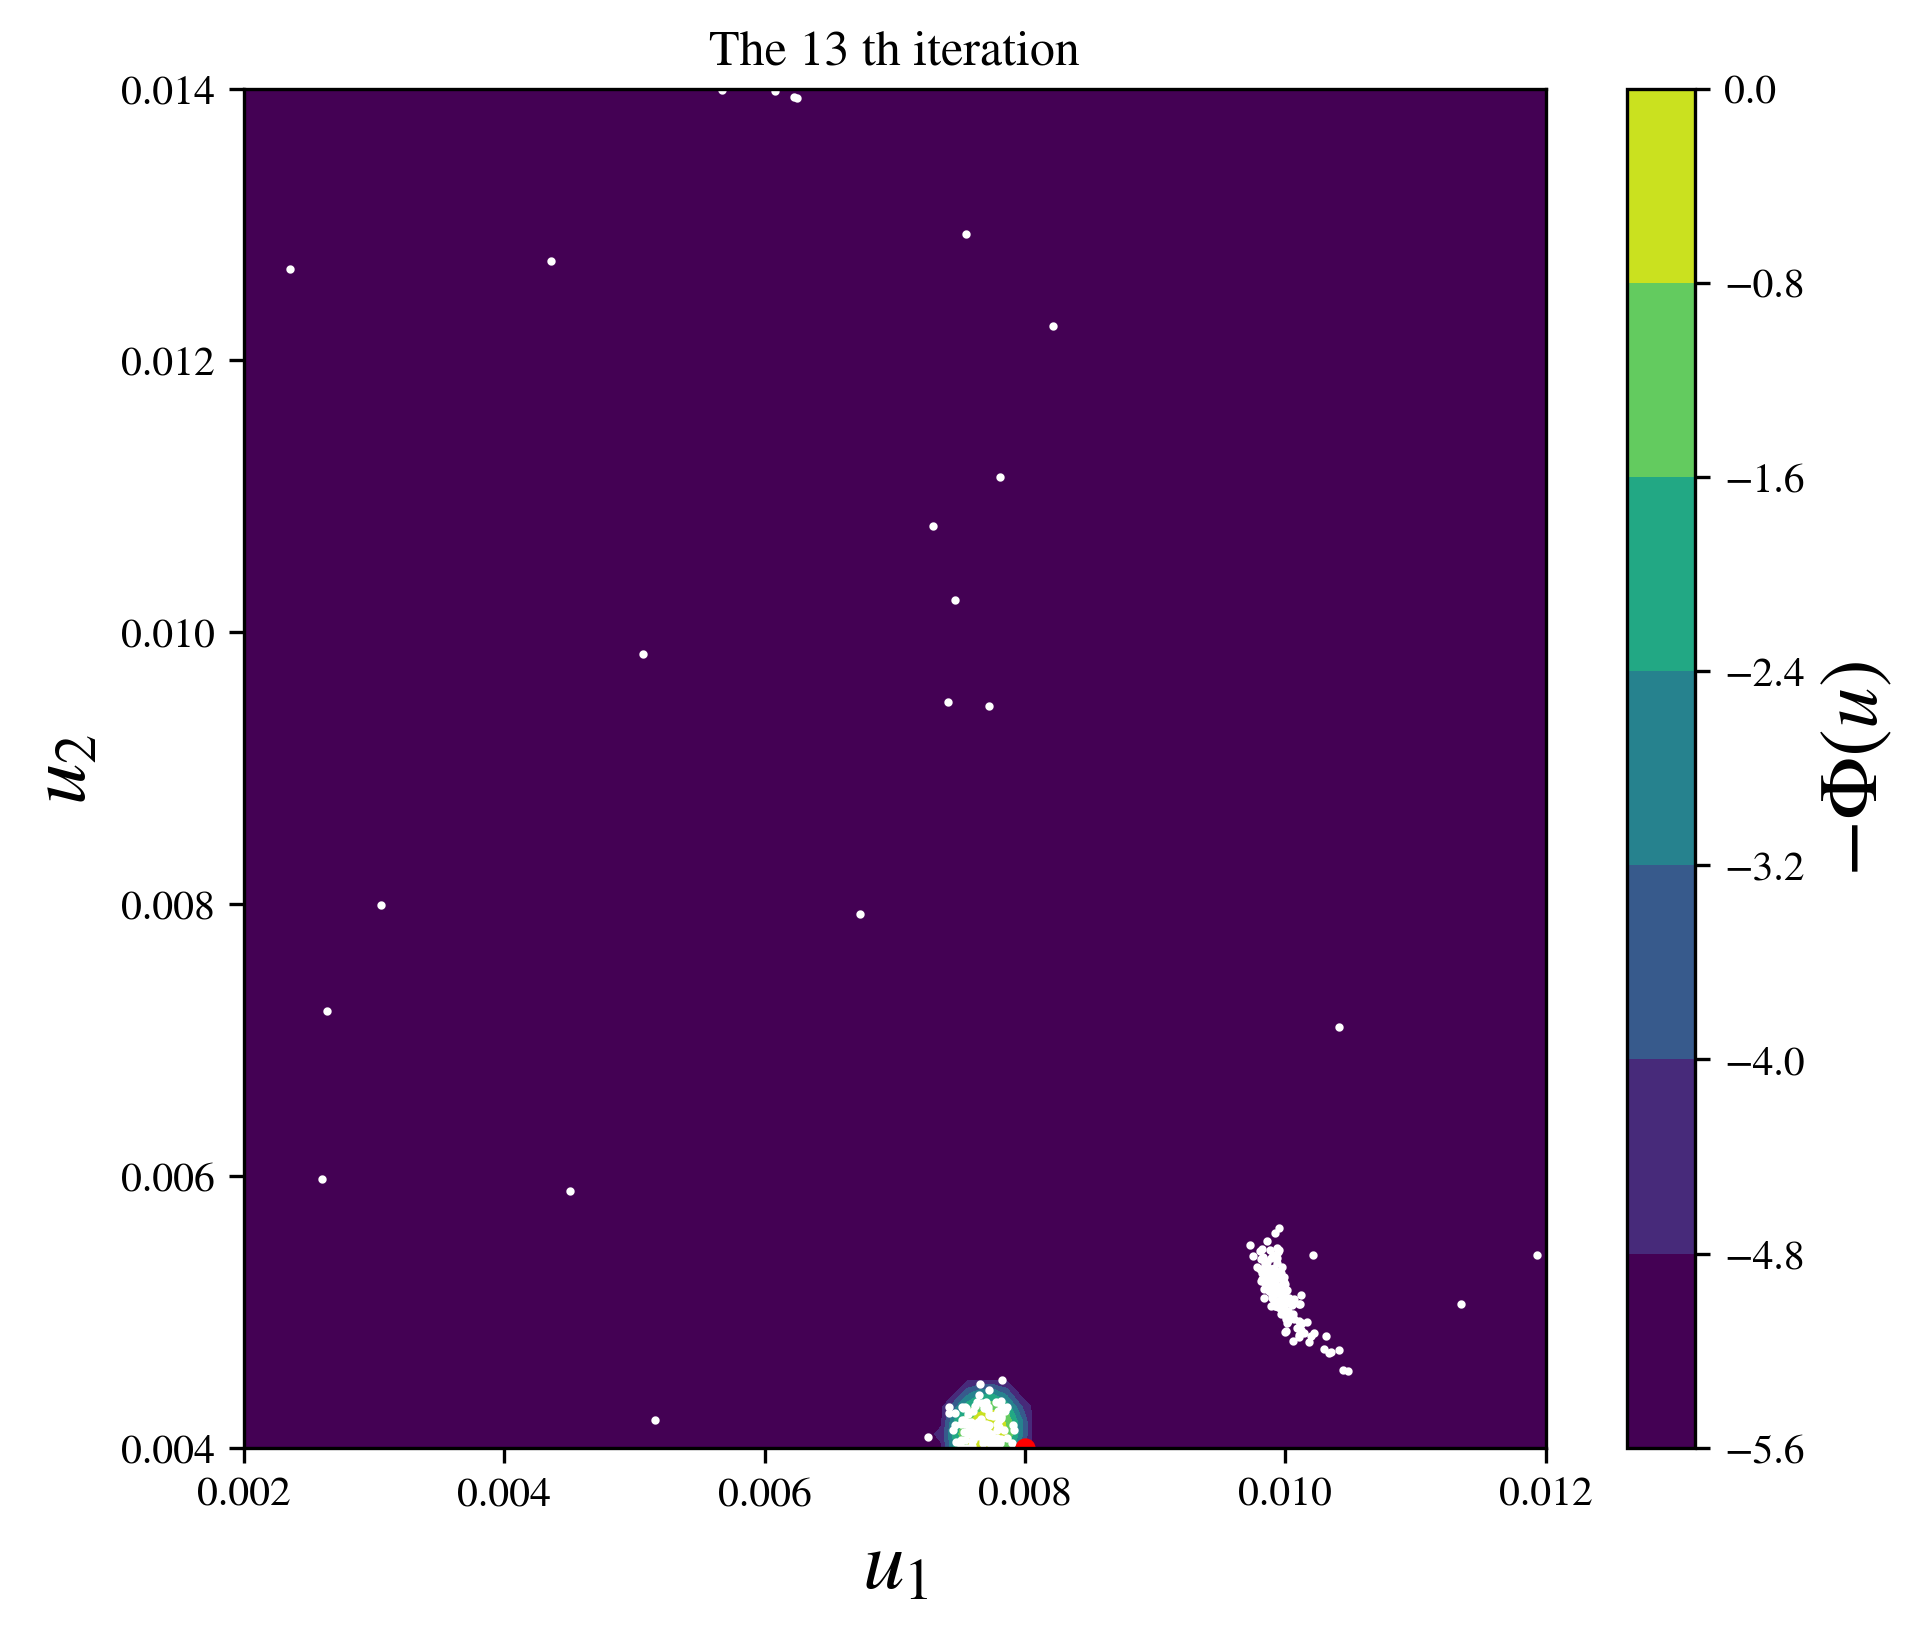

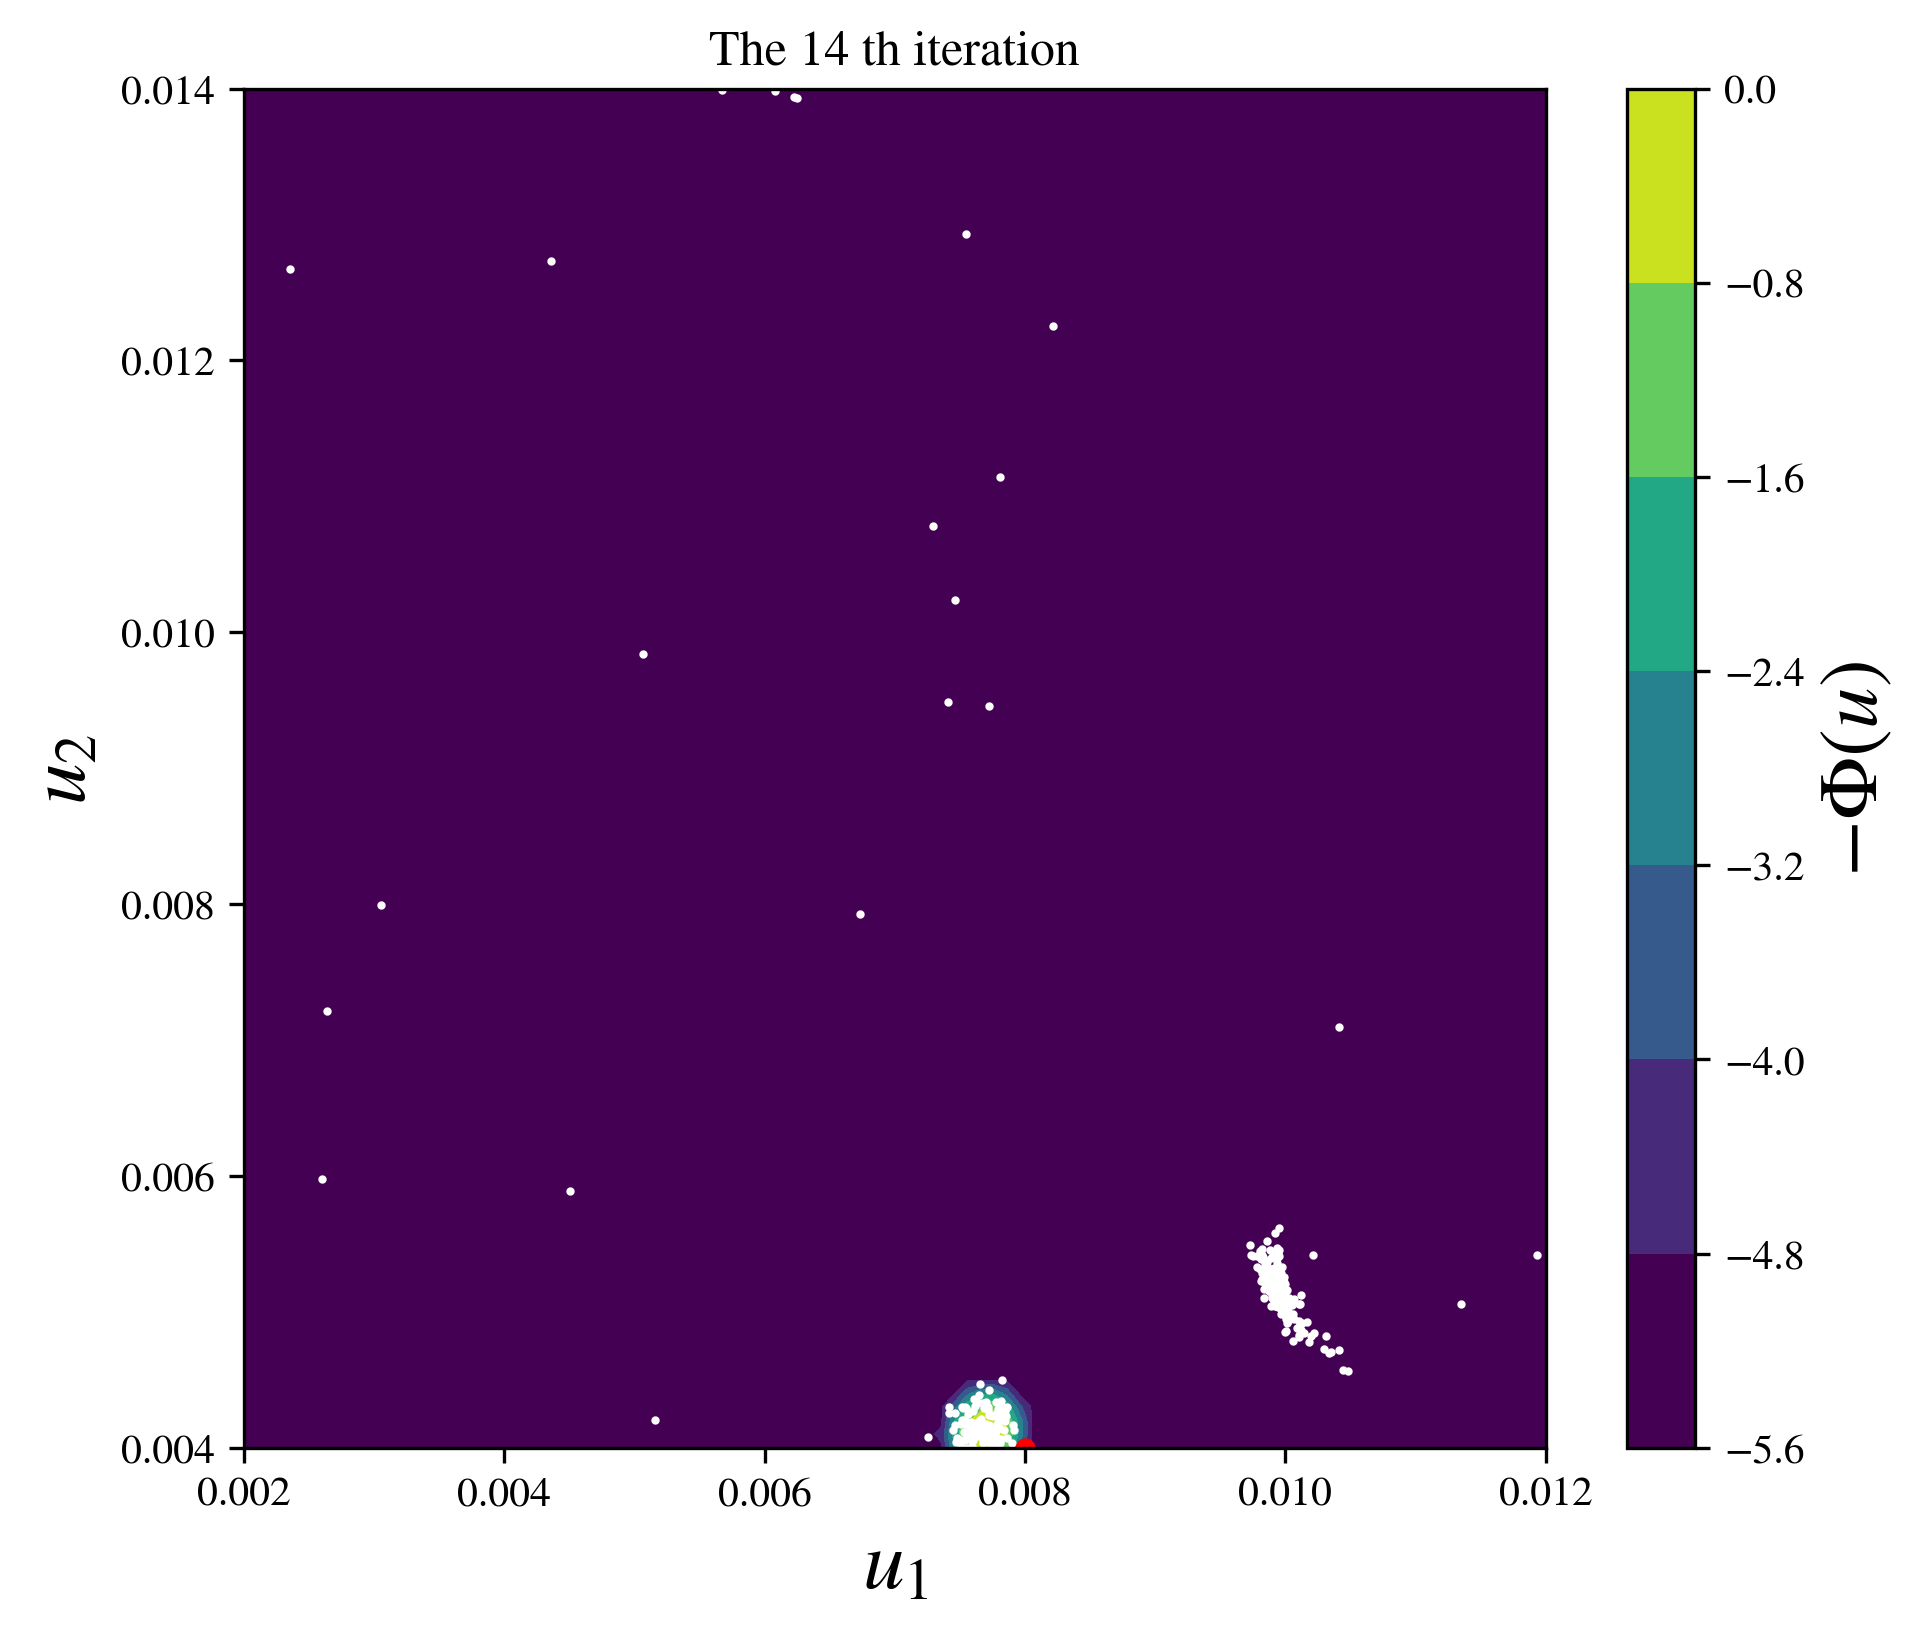

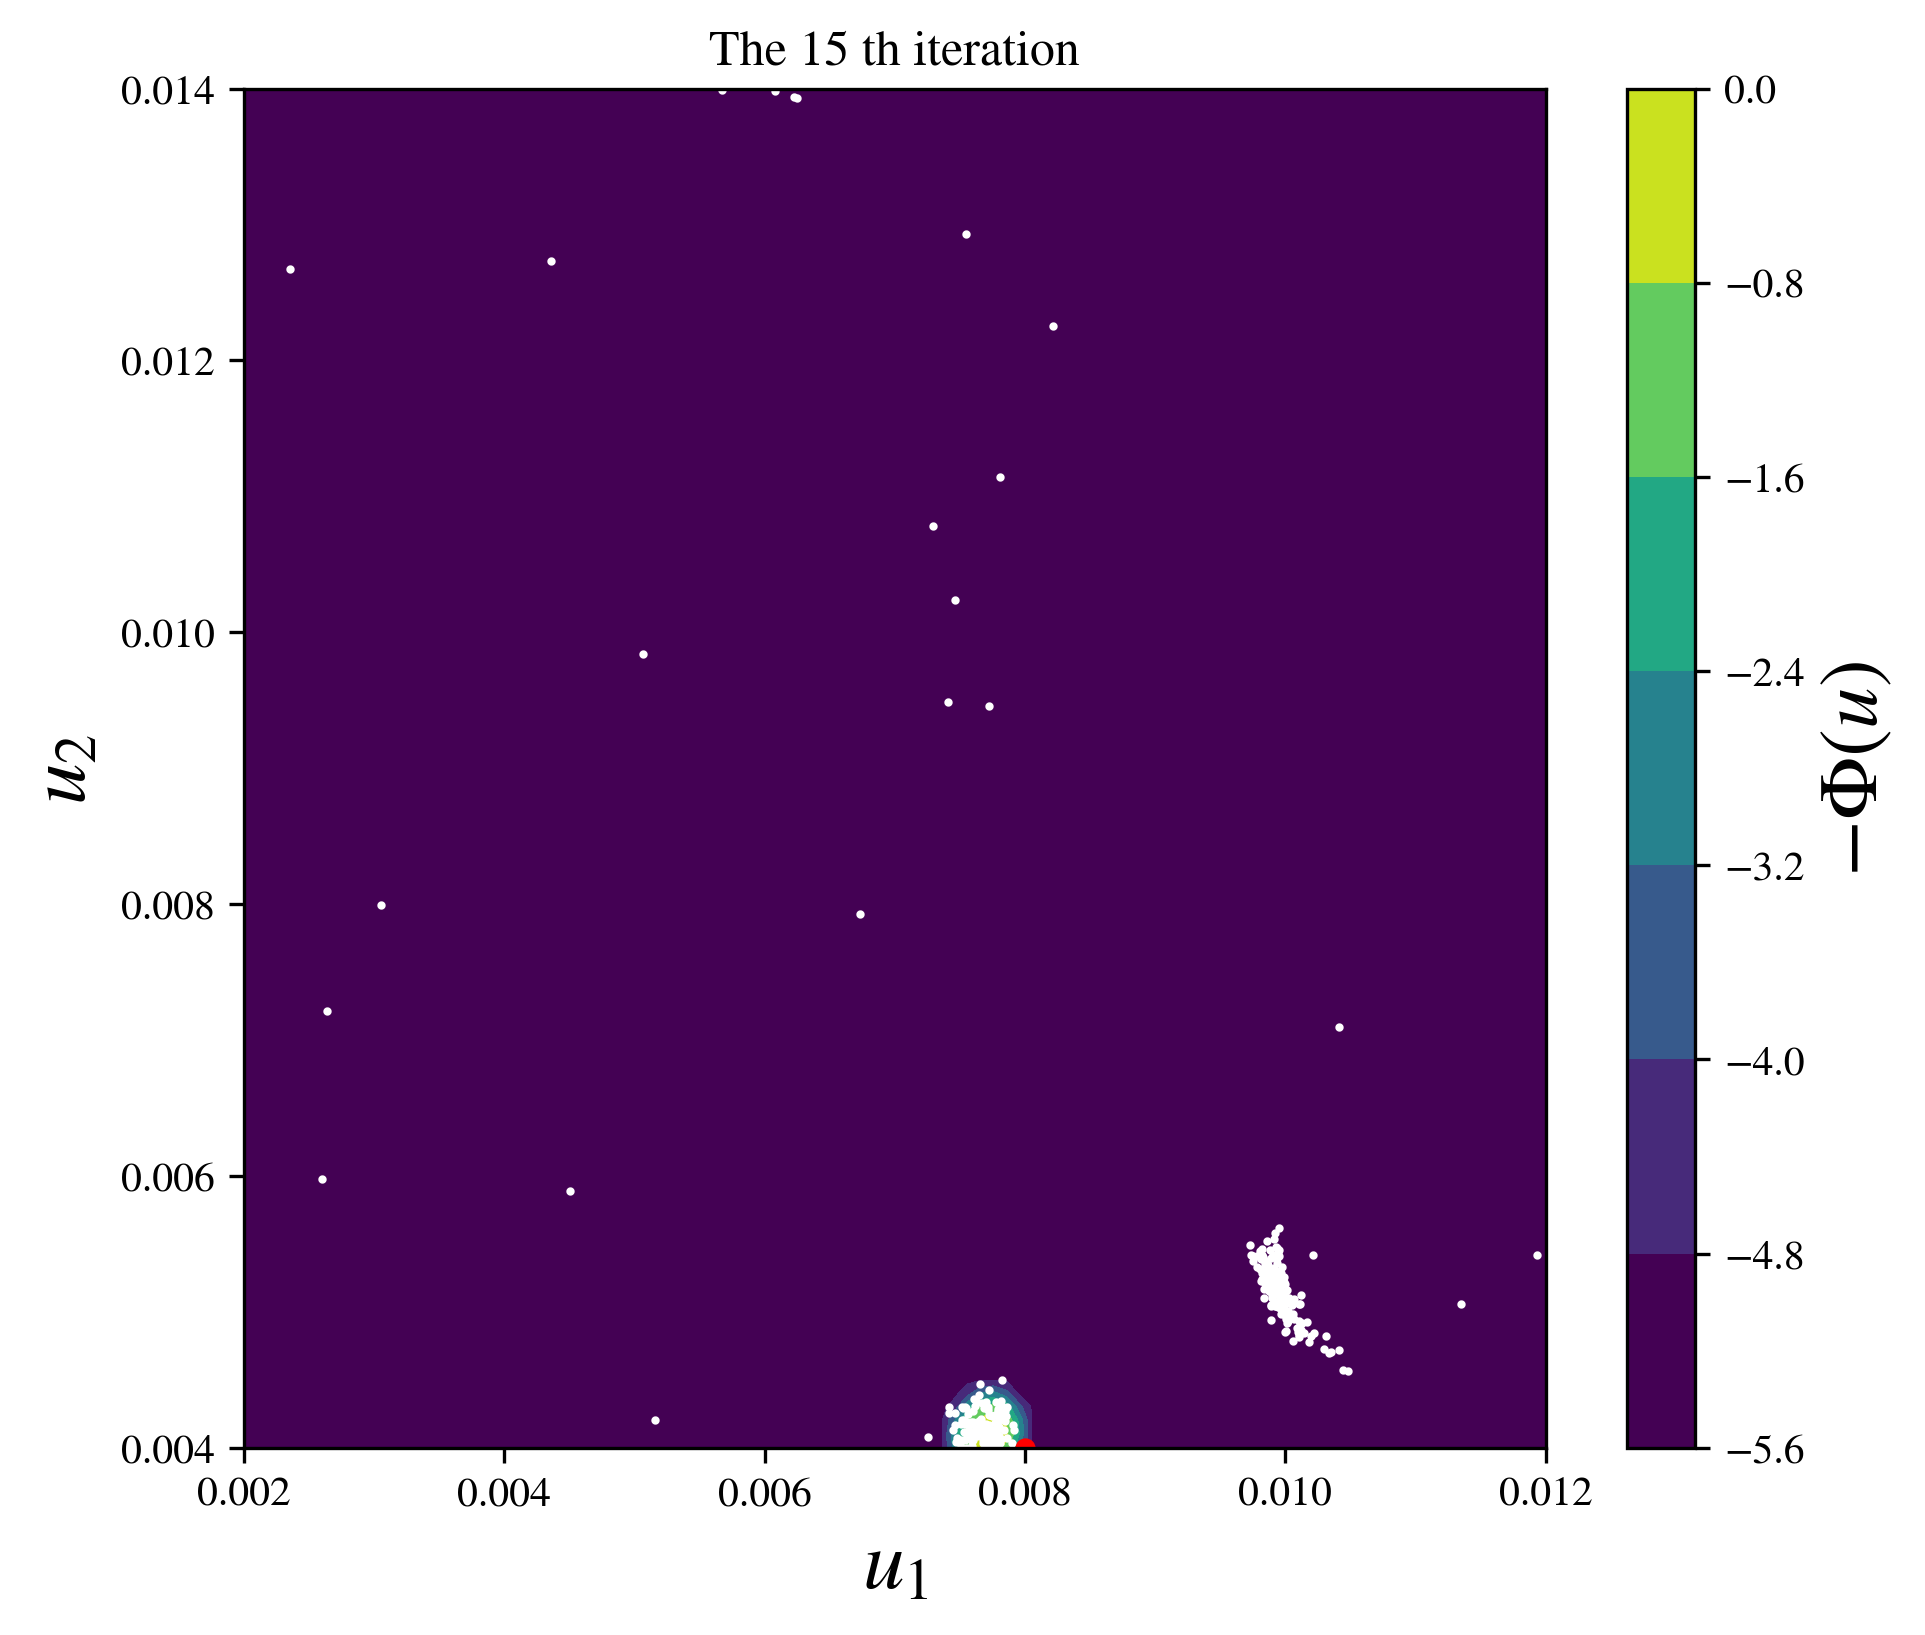

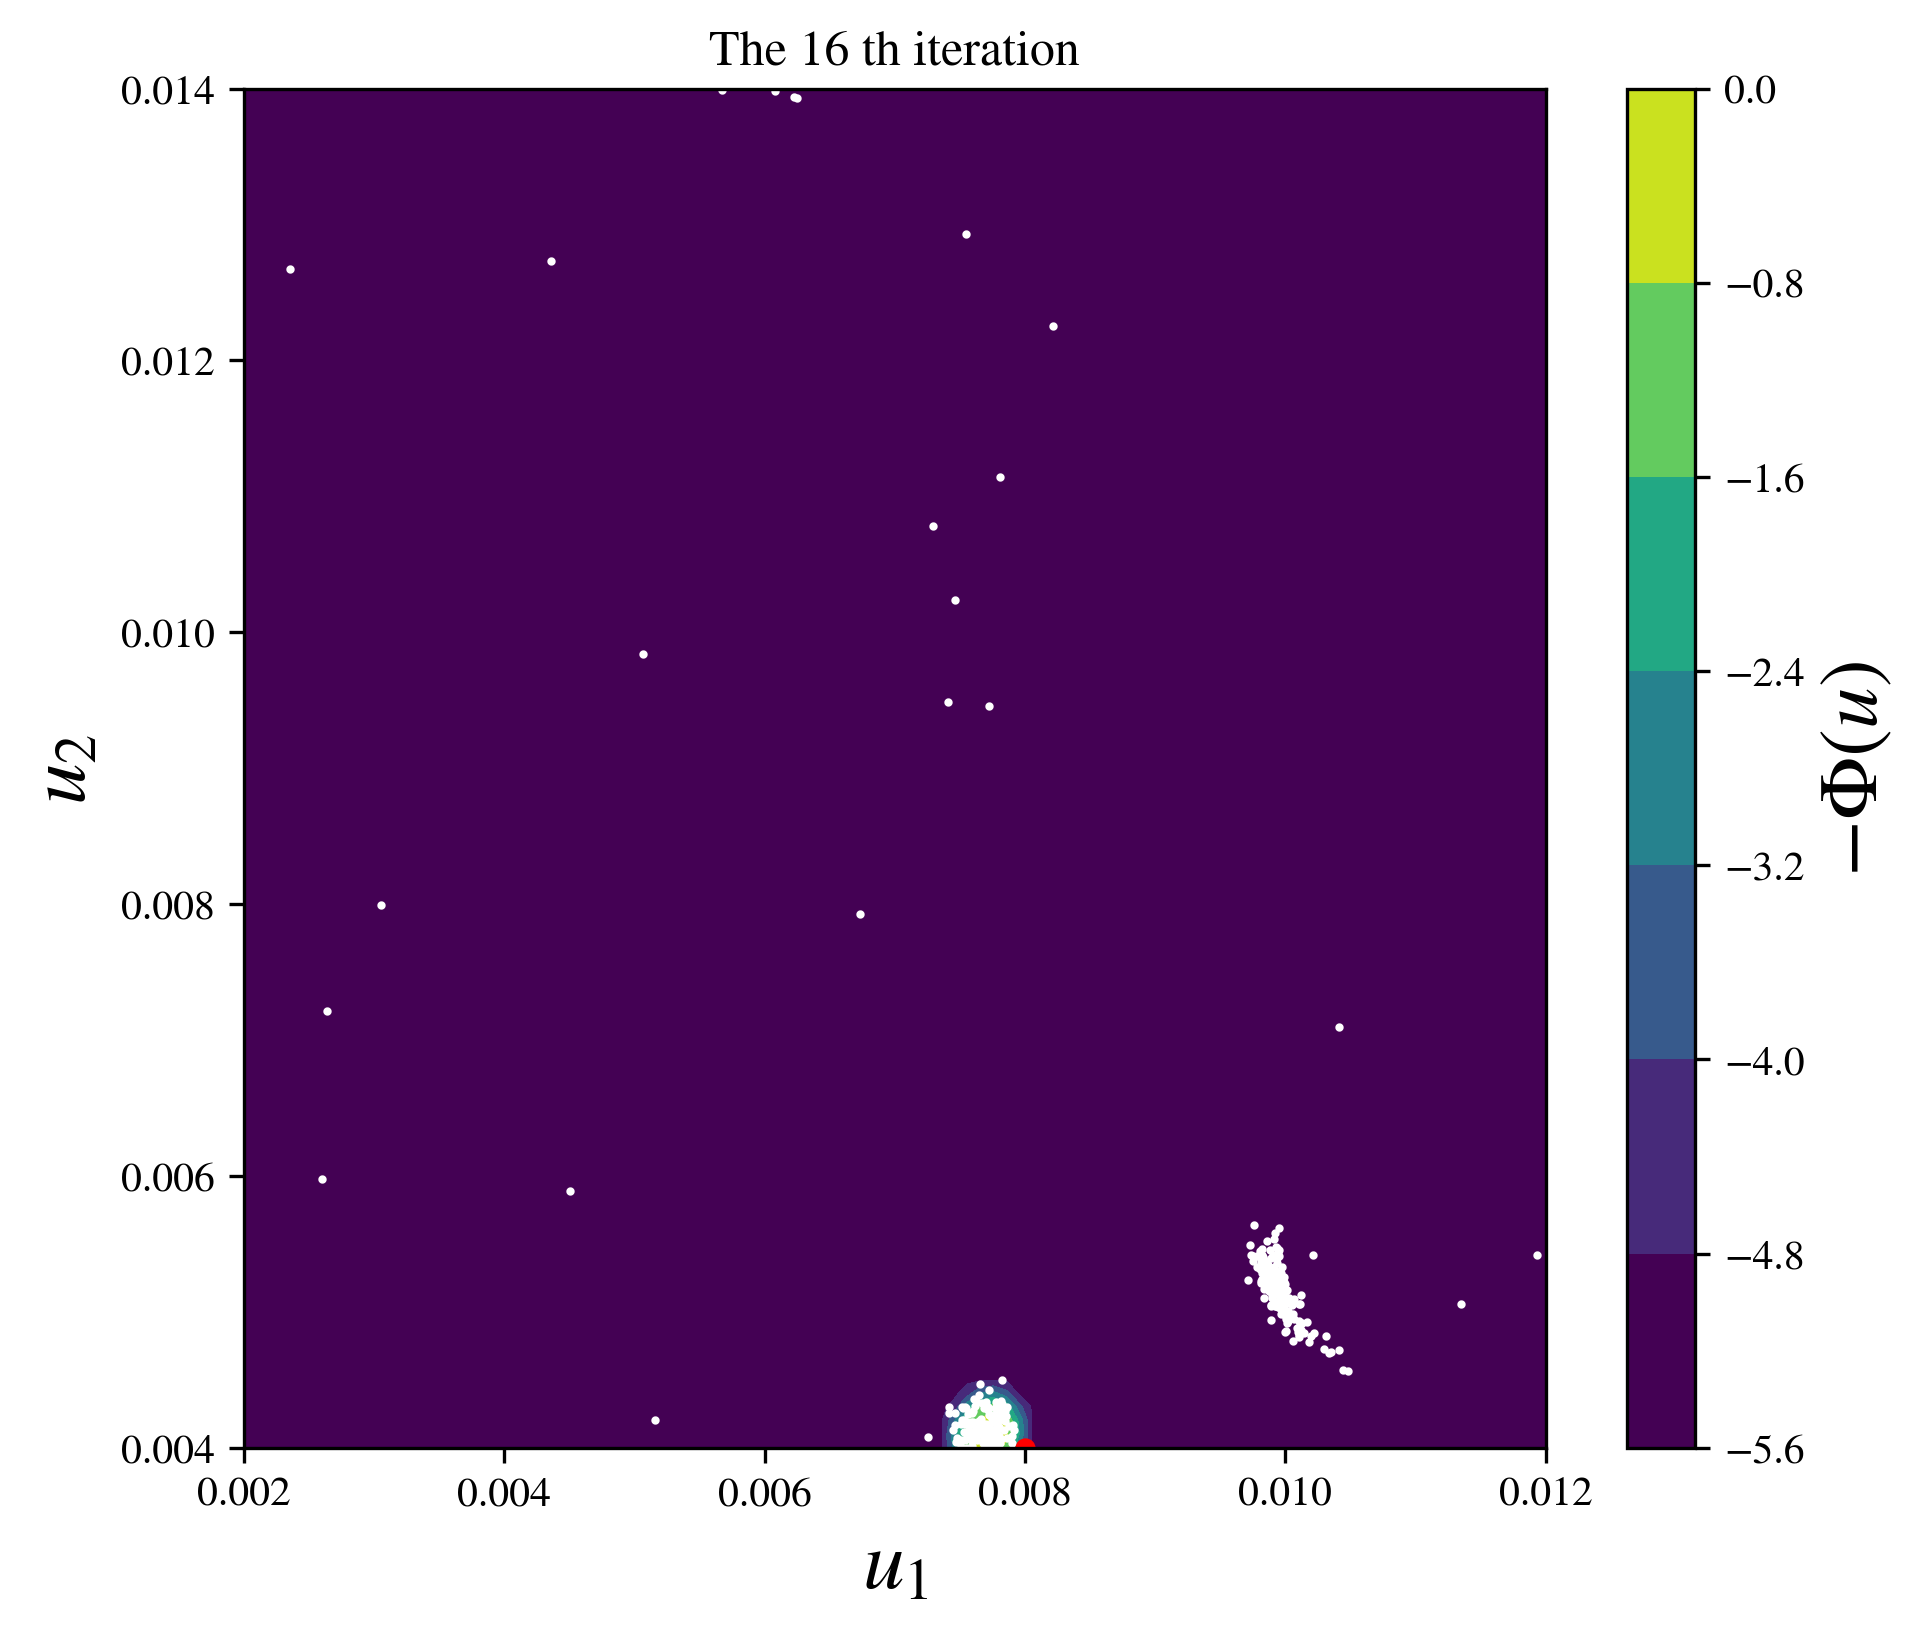

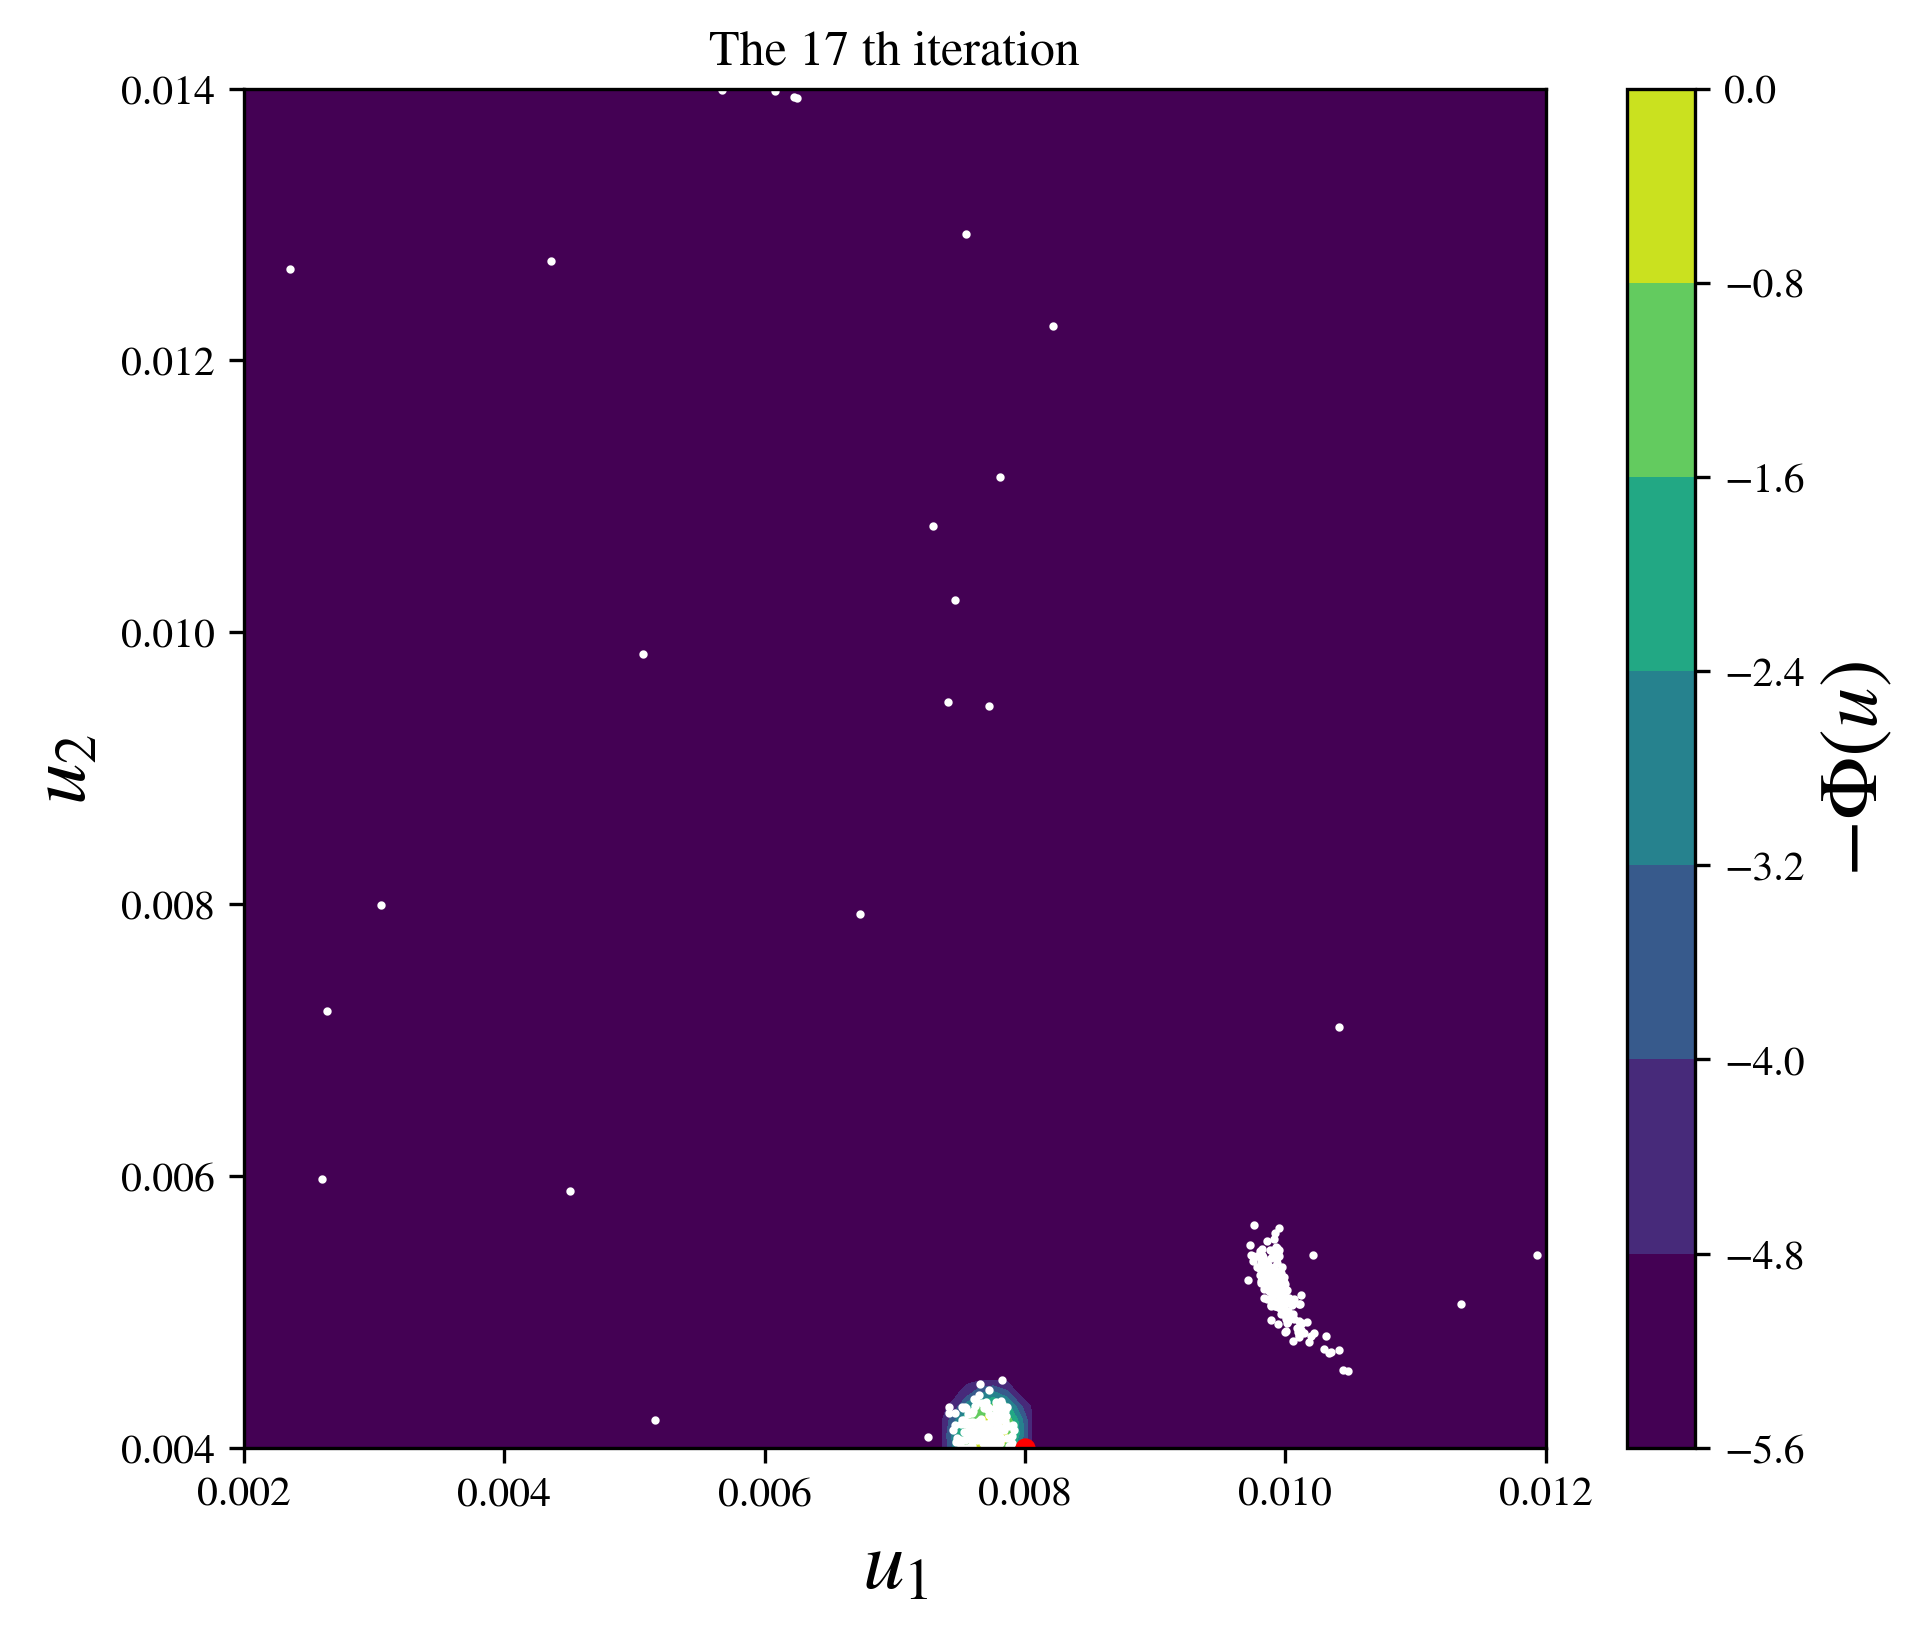

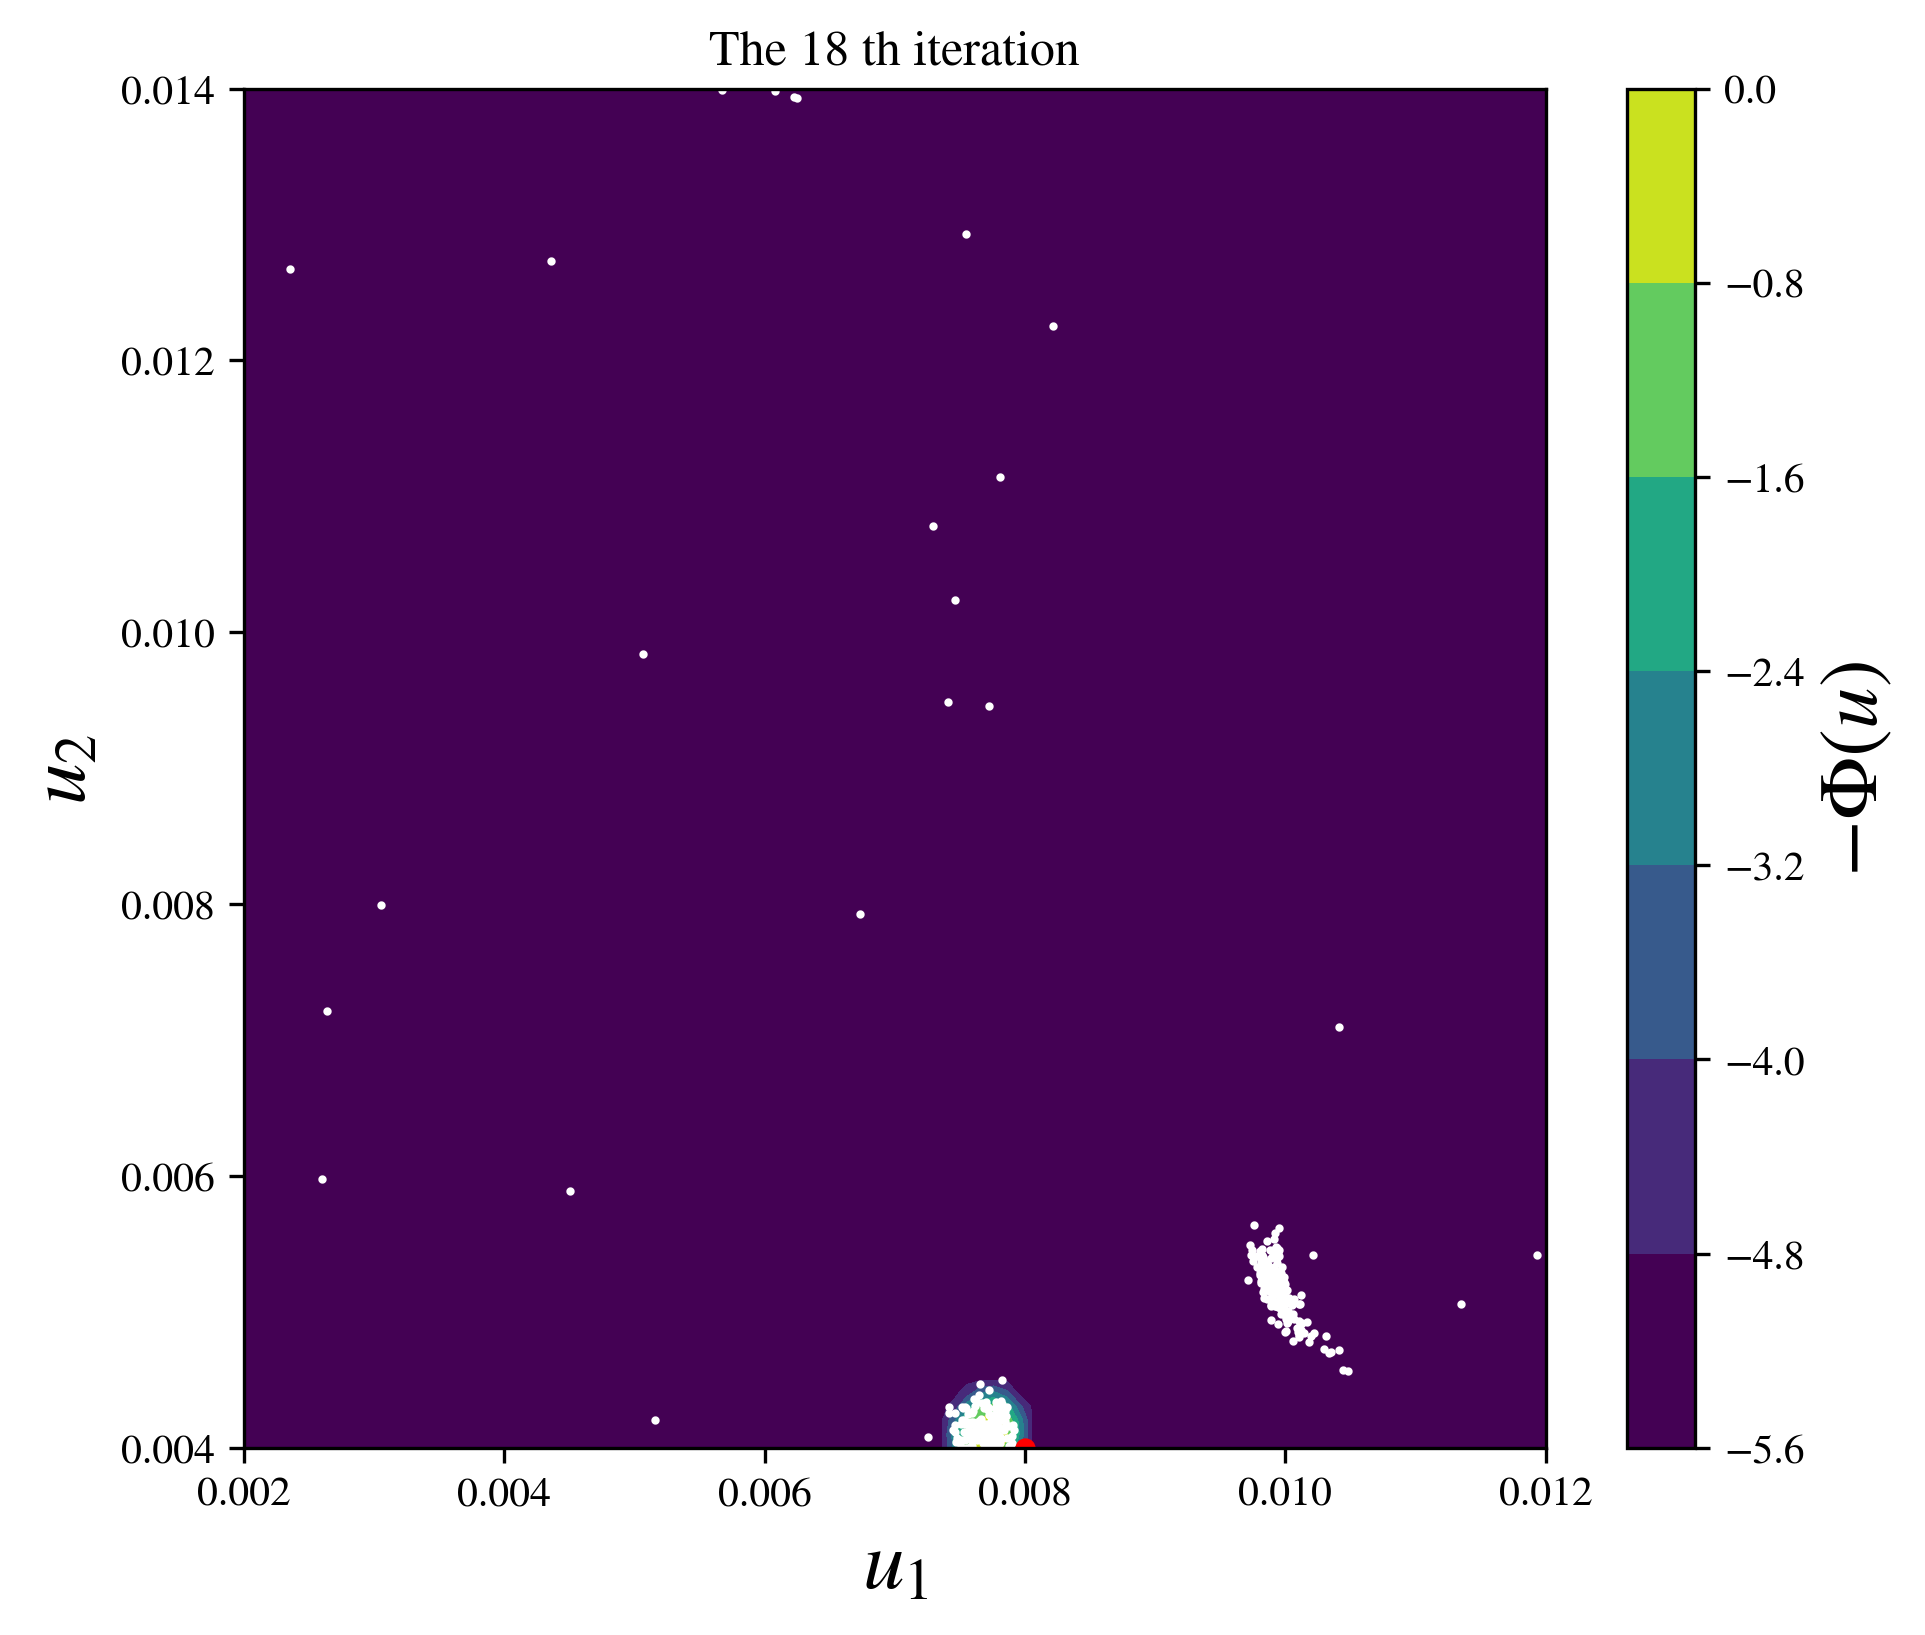

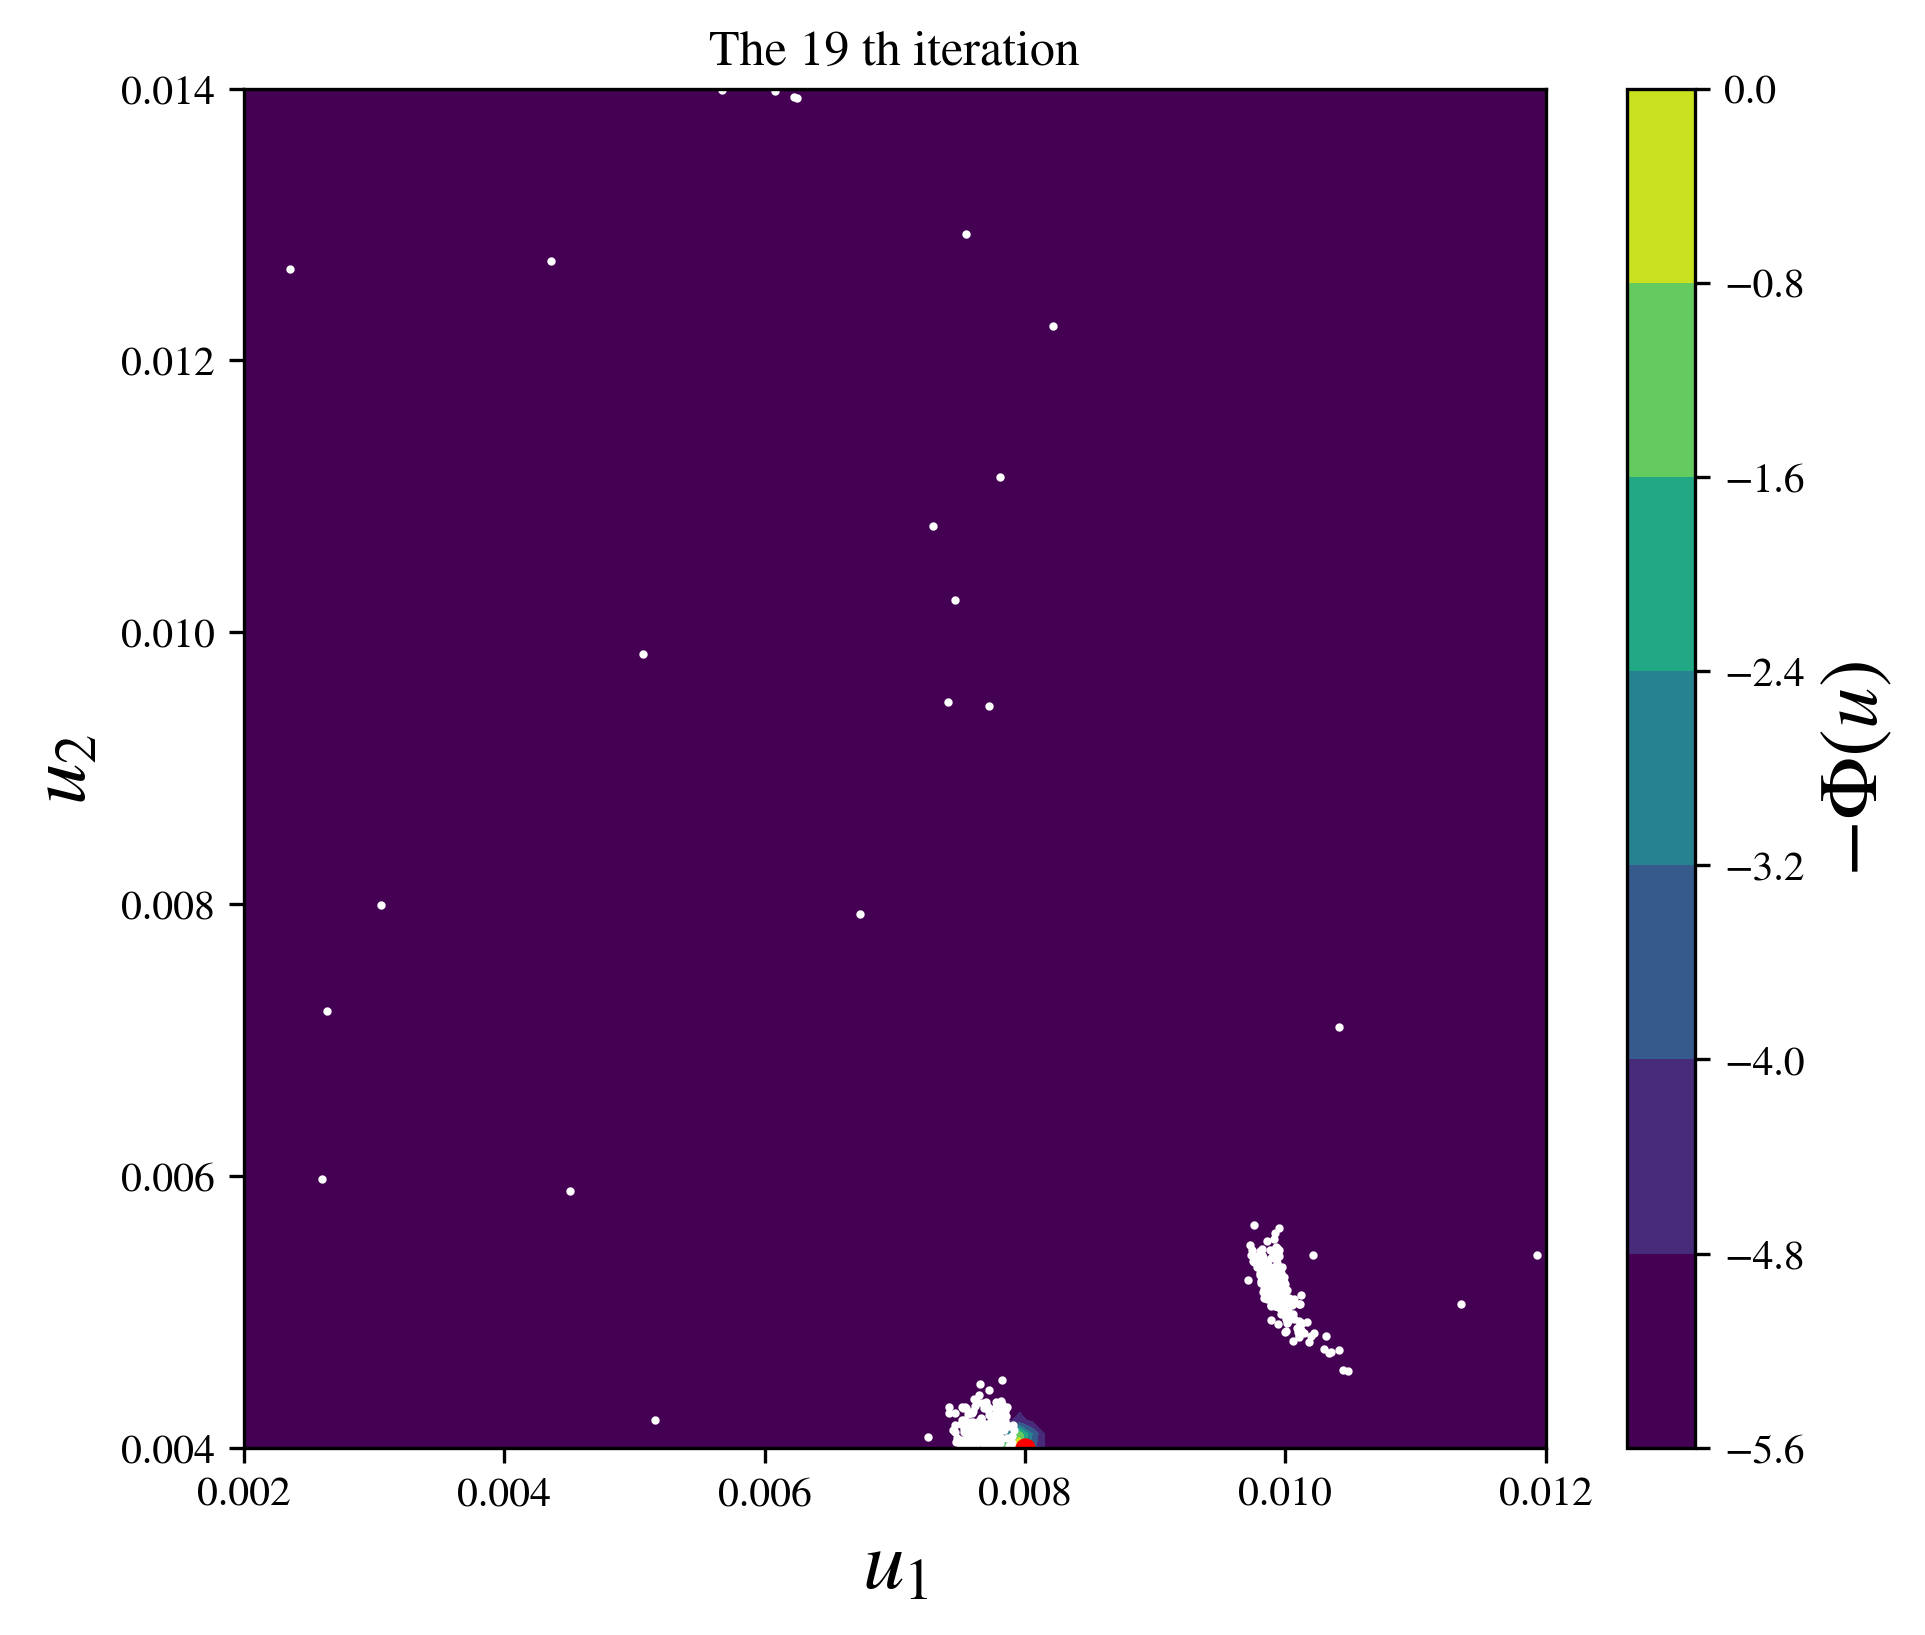

In [670]:
myInv.plotGIF()

Text(0, 0.5, 'Average error')

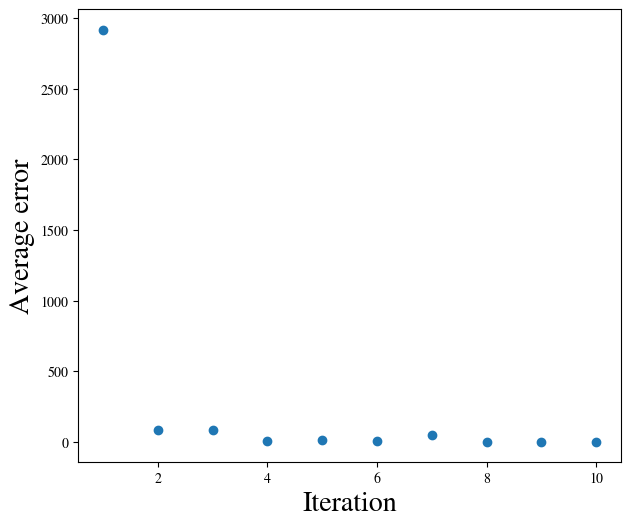

In [619]:
# Plot error versus iteration
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)
ax.plot(range(1, 1 + len(myInv.avg_errors)), myInv.avg_errors, 'o', linewidth=2.0)
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("Average error", fontsize = 20)

In [640]:
# Plot log likelihood of the give iteration step
def log_prob_best(self, iter_step, u, y):
    # Apply hard constraints
    normal_idx = np.all(np.concatenate([u >= self.u_low, u <= self.u_high], axis = 1), axis = 1)

    # First prior is uniform distribution
    res = np.ones(len(u))
    res[~normal_idx] = -np.inf

    # Add all posteriors in each iteration
    if (np.sum(normal_idx) > 0):
        for i in range(iter_step + 1):
            res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                np.sum(
                    (y - self.GPs[i].predict(u[normal_idx])) ** 2, 
                    axis = 1
                )
            )

    # Return the log_probability at the current iteration
    return res

# Plot a series and save the gif
def plotSeries(self, analytical_u, analytical_y, dpi_value = 300):
    # Calculate U_plot
    minU = self.u_low
    maxU = self.u_high
    nOfGridPoints = 100

    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    
    gifName = "./figures/A{0}_B{1}.gif".format(analytical_u[0], analytical_u[1])
    
    writer = imageio.get_writer(gifName, mode='I', duration = 1.0)
    
    # Plot the series
    for i in range(0, self.iterations):
        plt.figure(figsize = (7, 6), dpi = dpi_value)
        YPlotGridFat = log_prob_best(self, i, UPlotGridFat, analytical_y)
        YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
        YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])
        cp = plt.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))
        
        # Give the color bar
        cbar = plt.colorbar(cp)
        plt.clim([-5., 0.])
        cbar.set_label('$-\\Phi(u)$', fontsize = 20)
        
        # Scatter the sample points
        plt.scatter(self.U[ :(i + 1) * self.n_samples, 0], 
                    self.U[ :(i + 1) * self.n_samples, 1], s = 1, color = 'white')
        plt.scatter(analytical_u[0], analytical_u[1], s = 15, color = 'red')
        plt.xlabel('$u_1$', fontsize = 20)
        plt.ylabel('$u_2$', fontsize = 20)
        plt.title("The " + str(i) + " th iteration")
        figName = "./figures/shit" + str(i) + ".png"
        plt.savefig(figName, dpi = dpi_value)
        
        # Save the figures into a gif
        image = imageio.imread(figName)
        writer.append_data(image)
        !rm $figName
    writer.close()
        
#    return figs

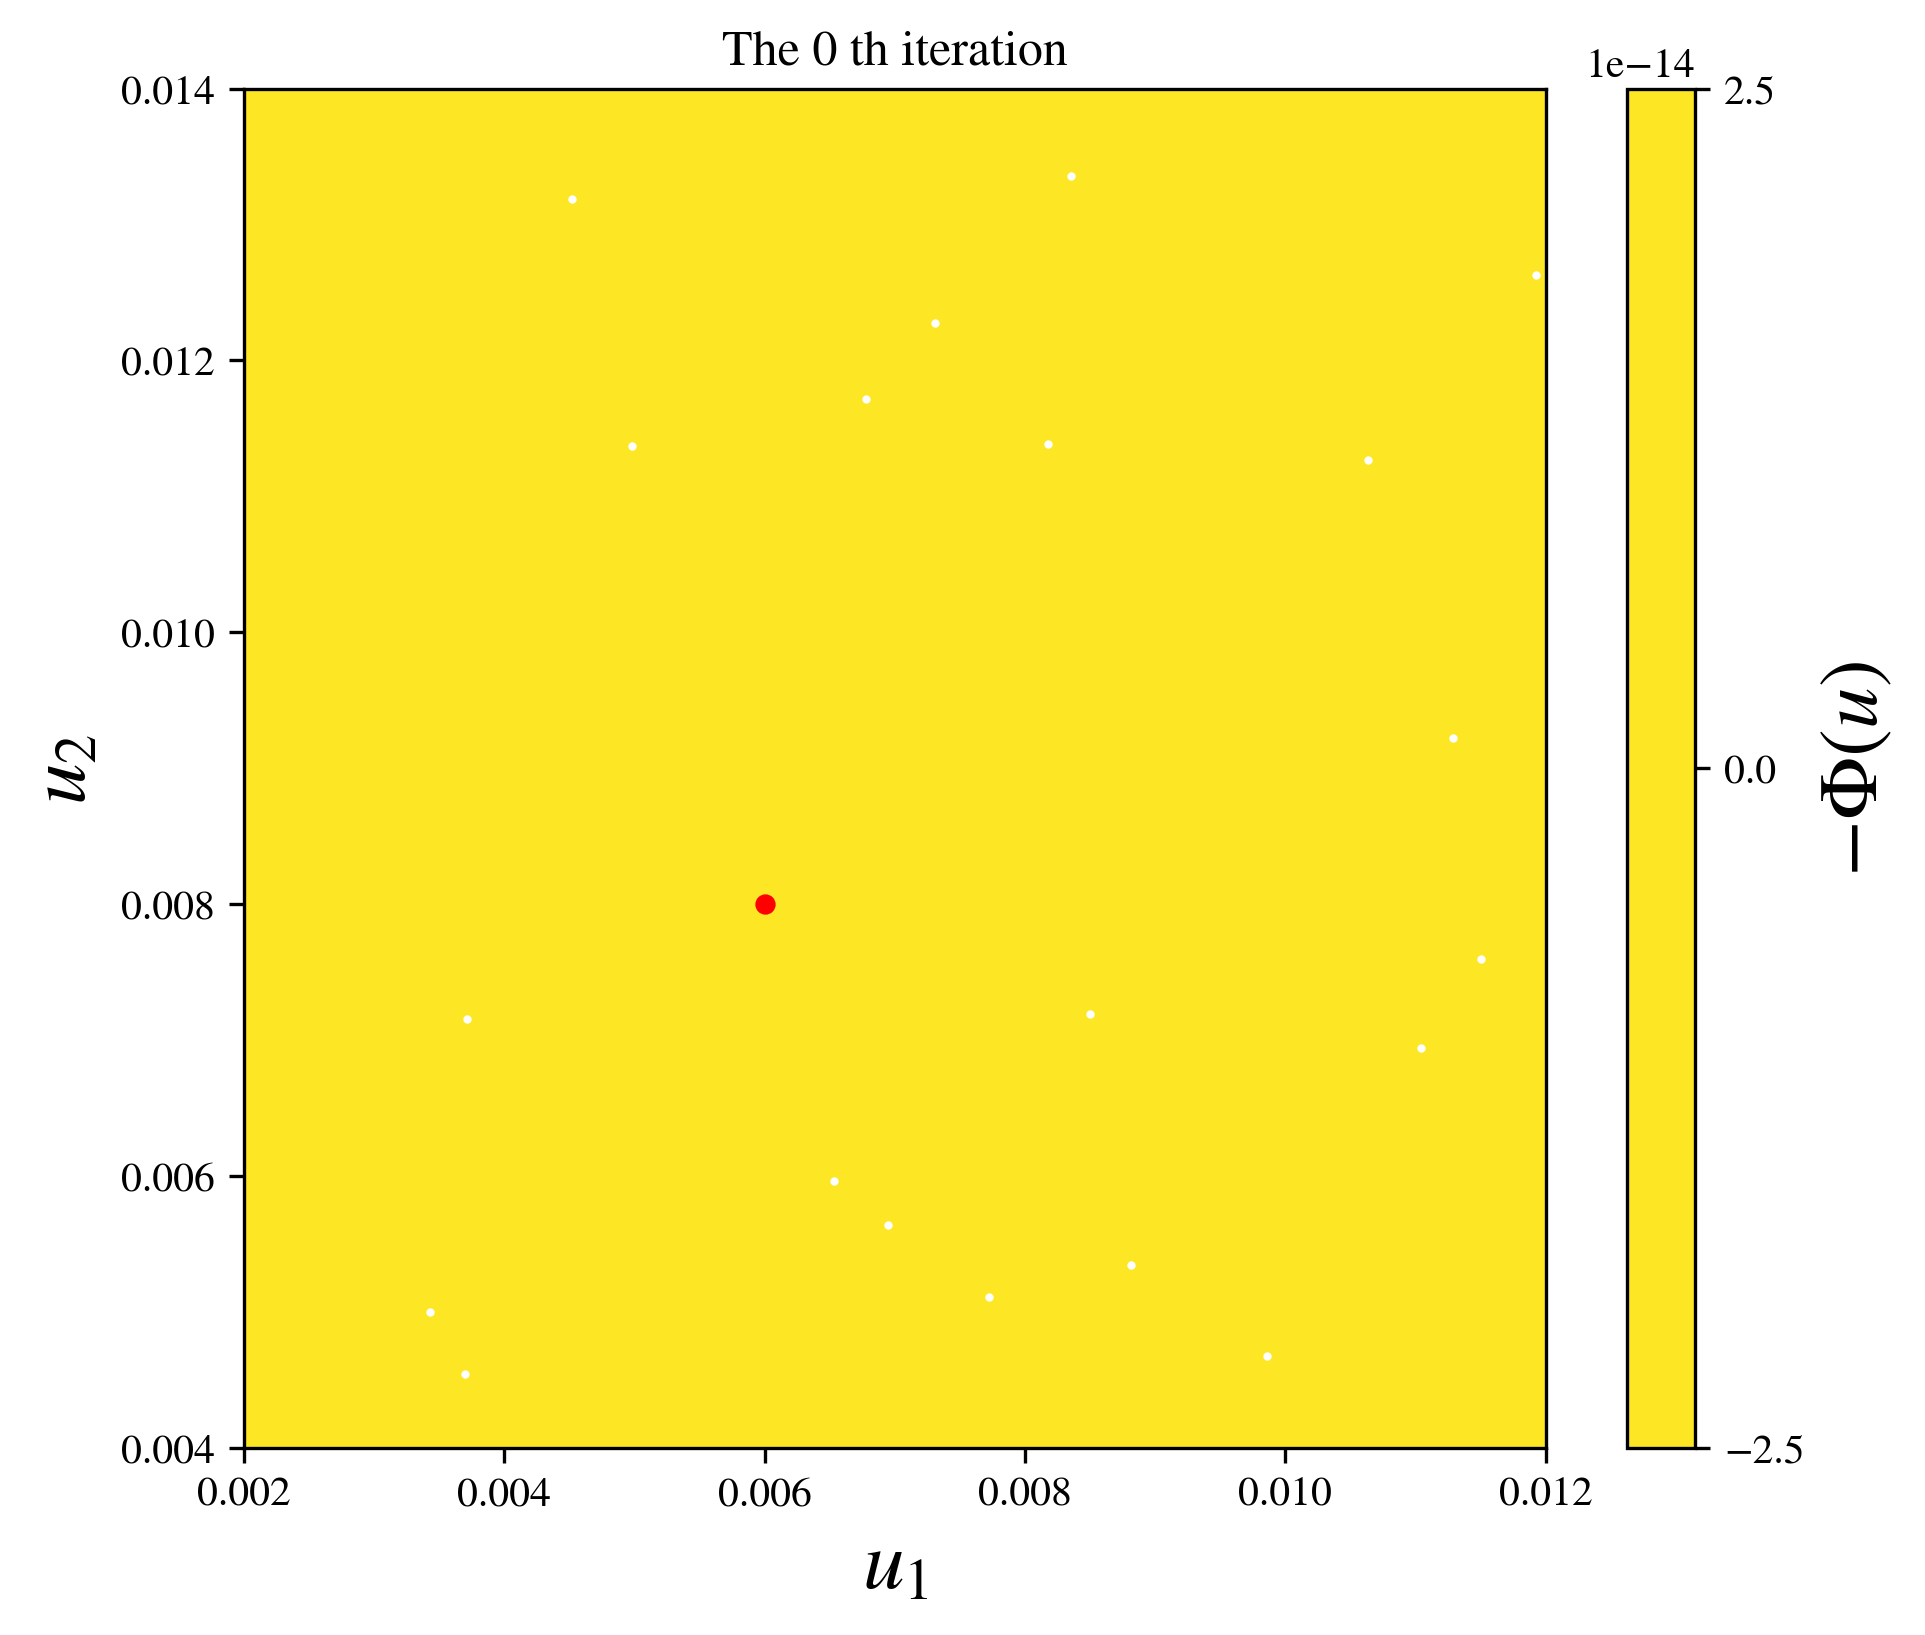

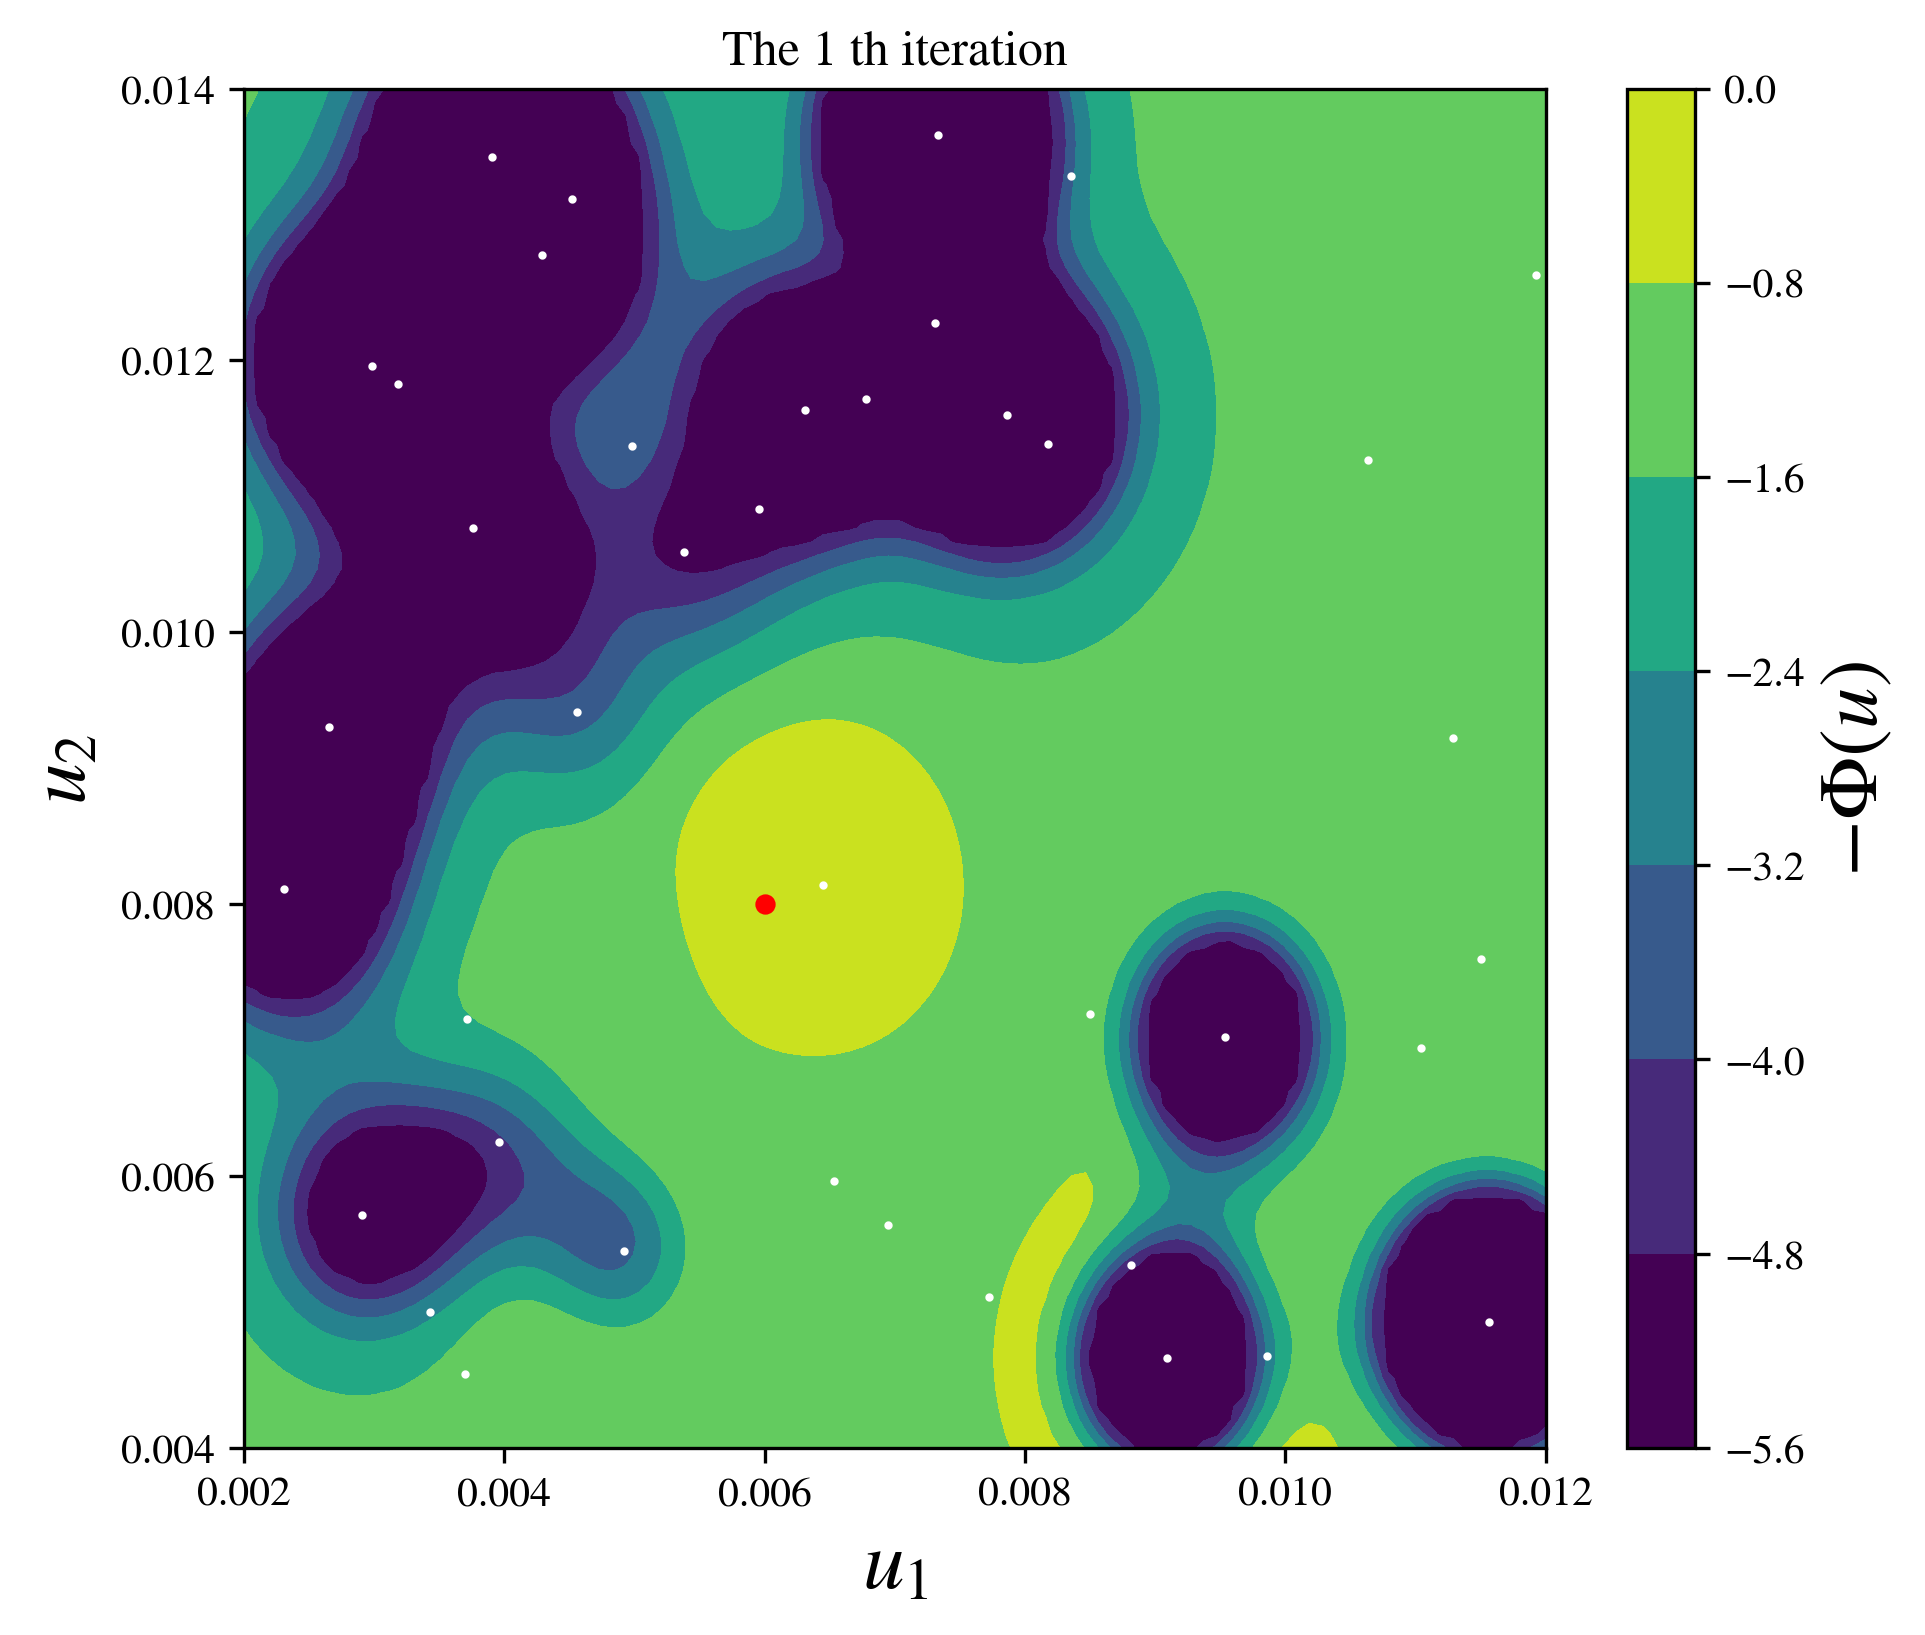

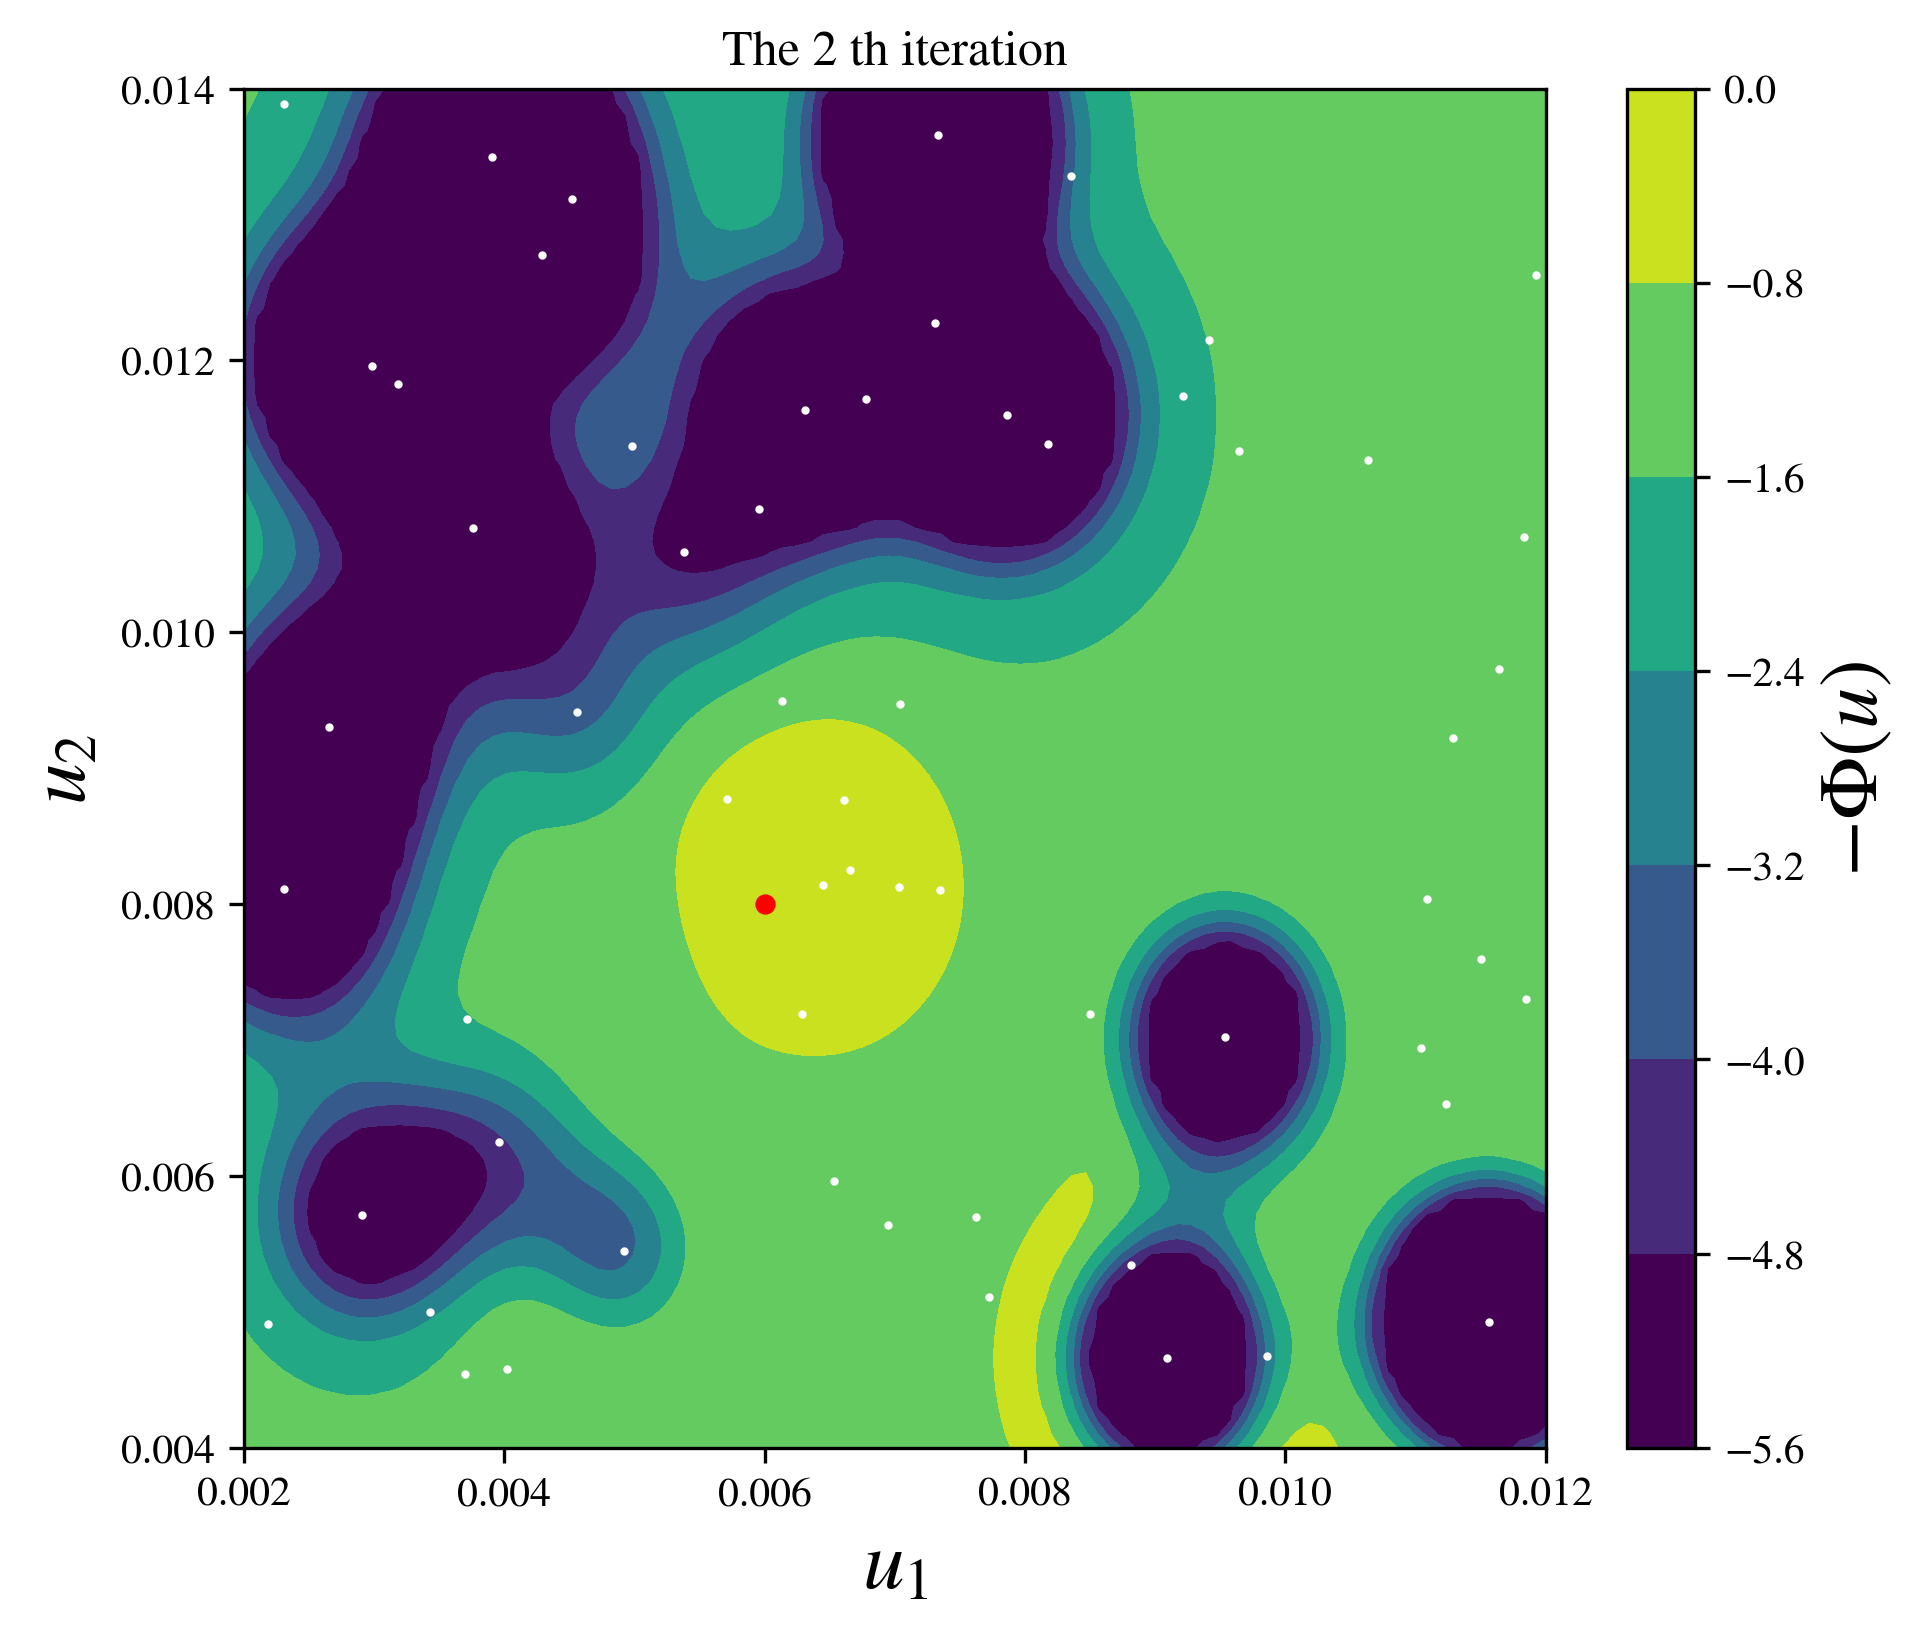

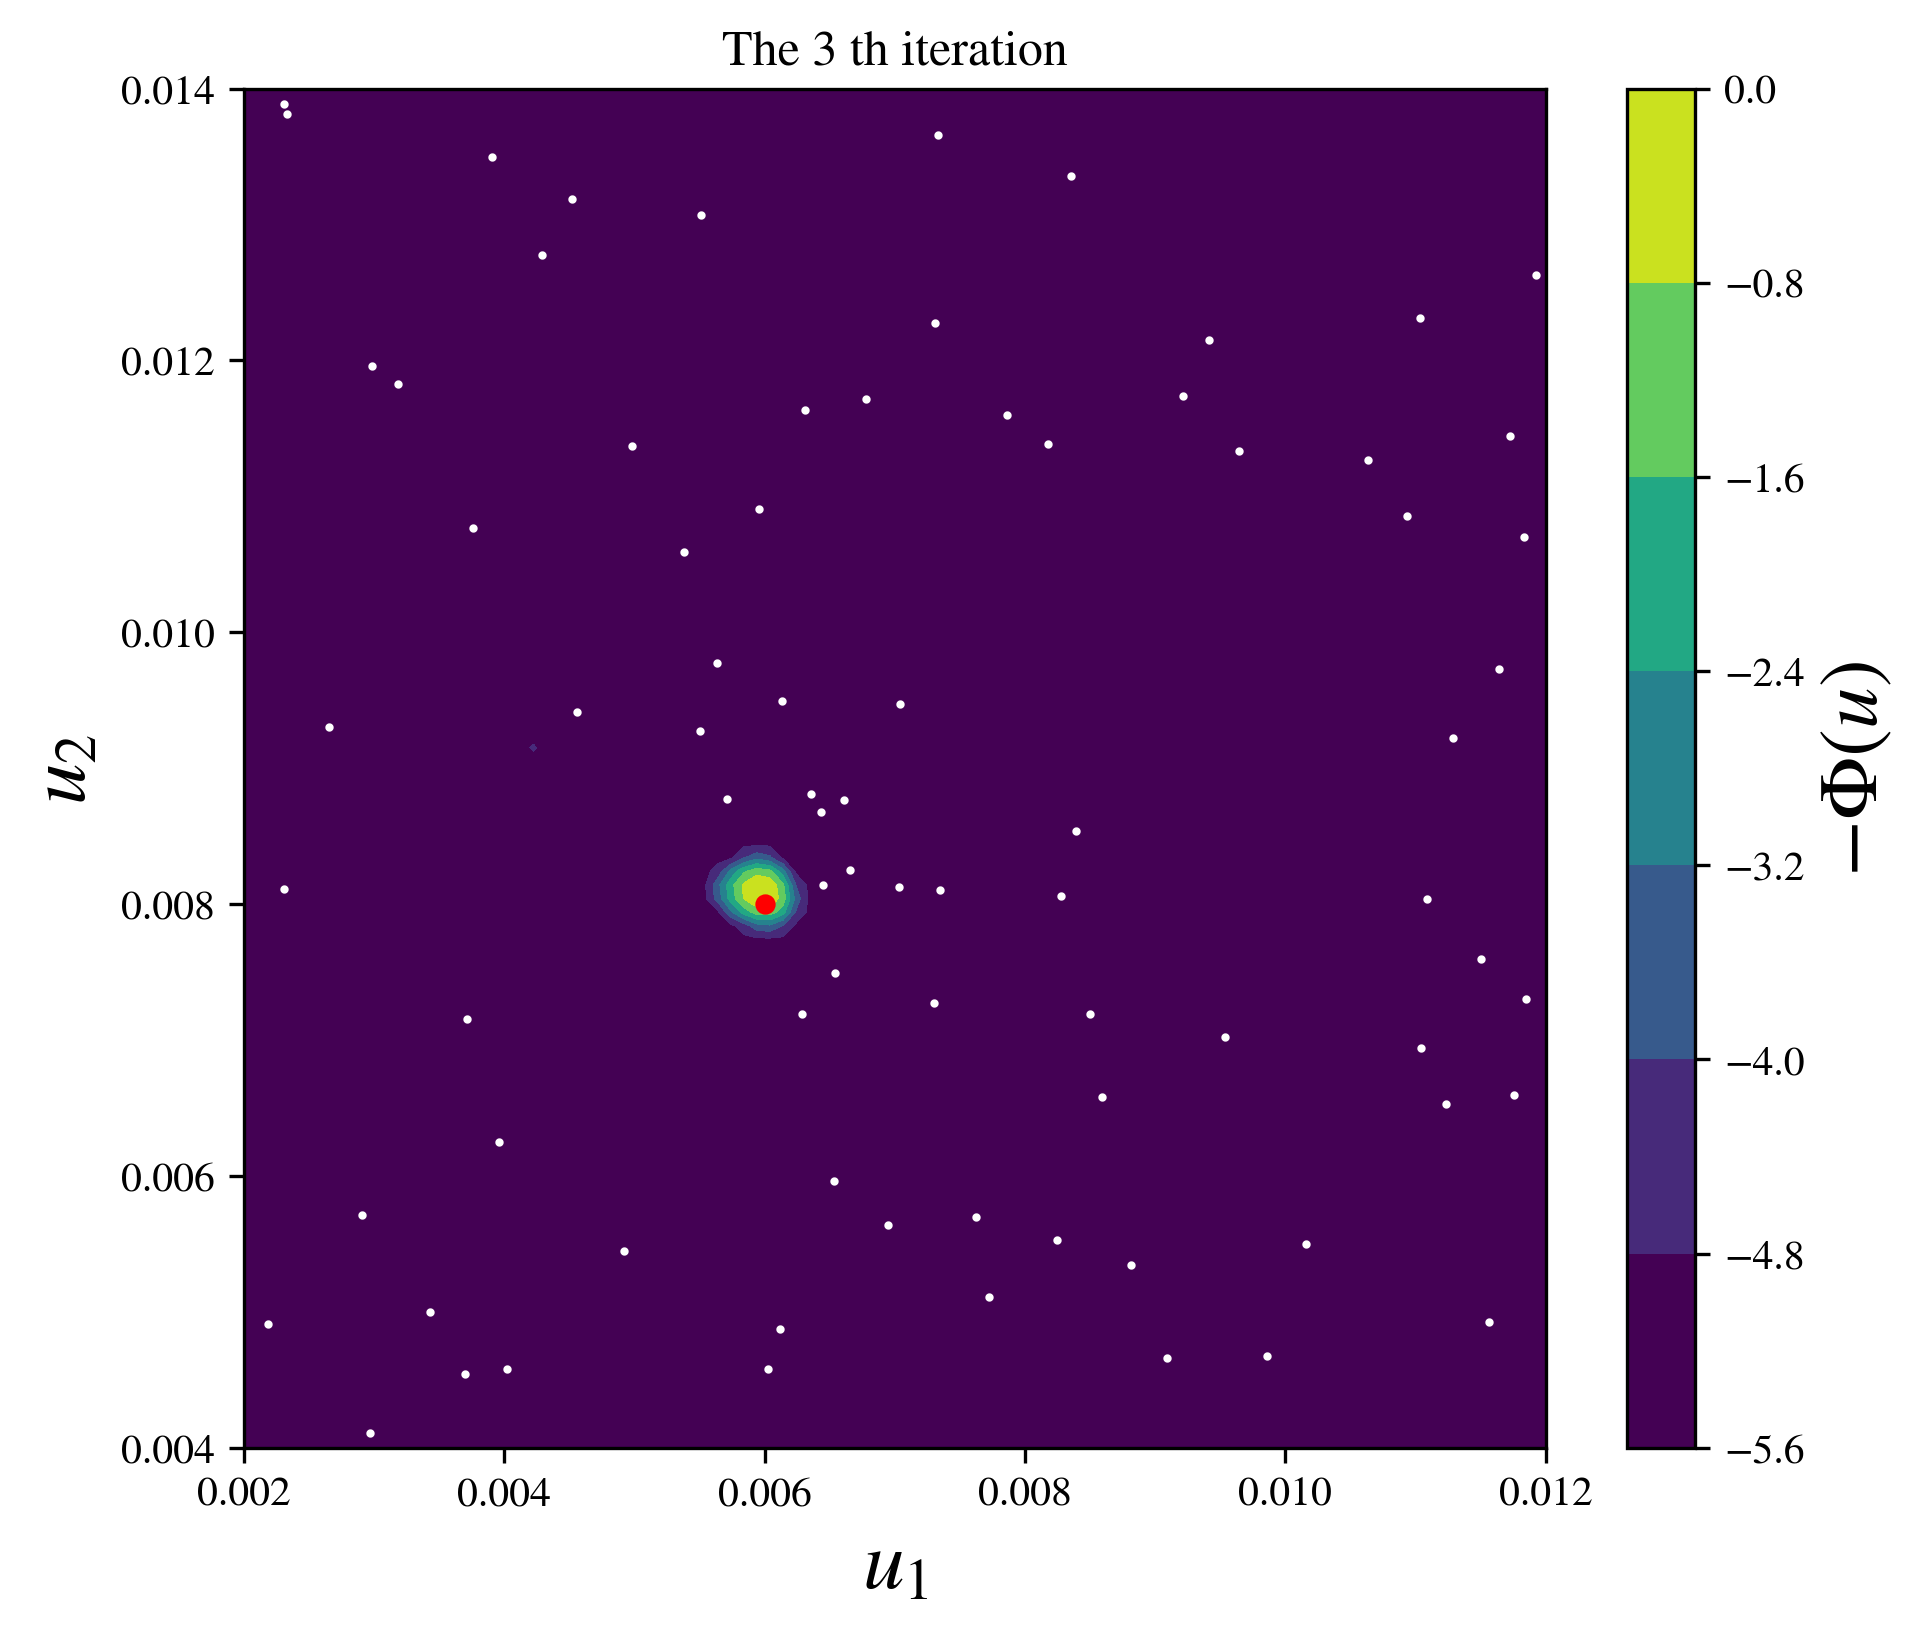

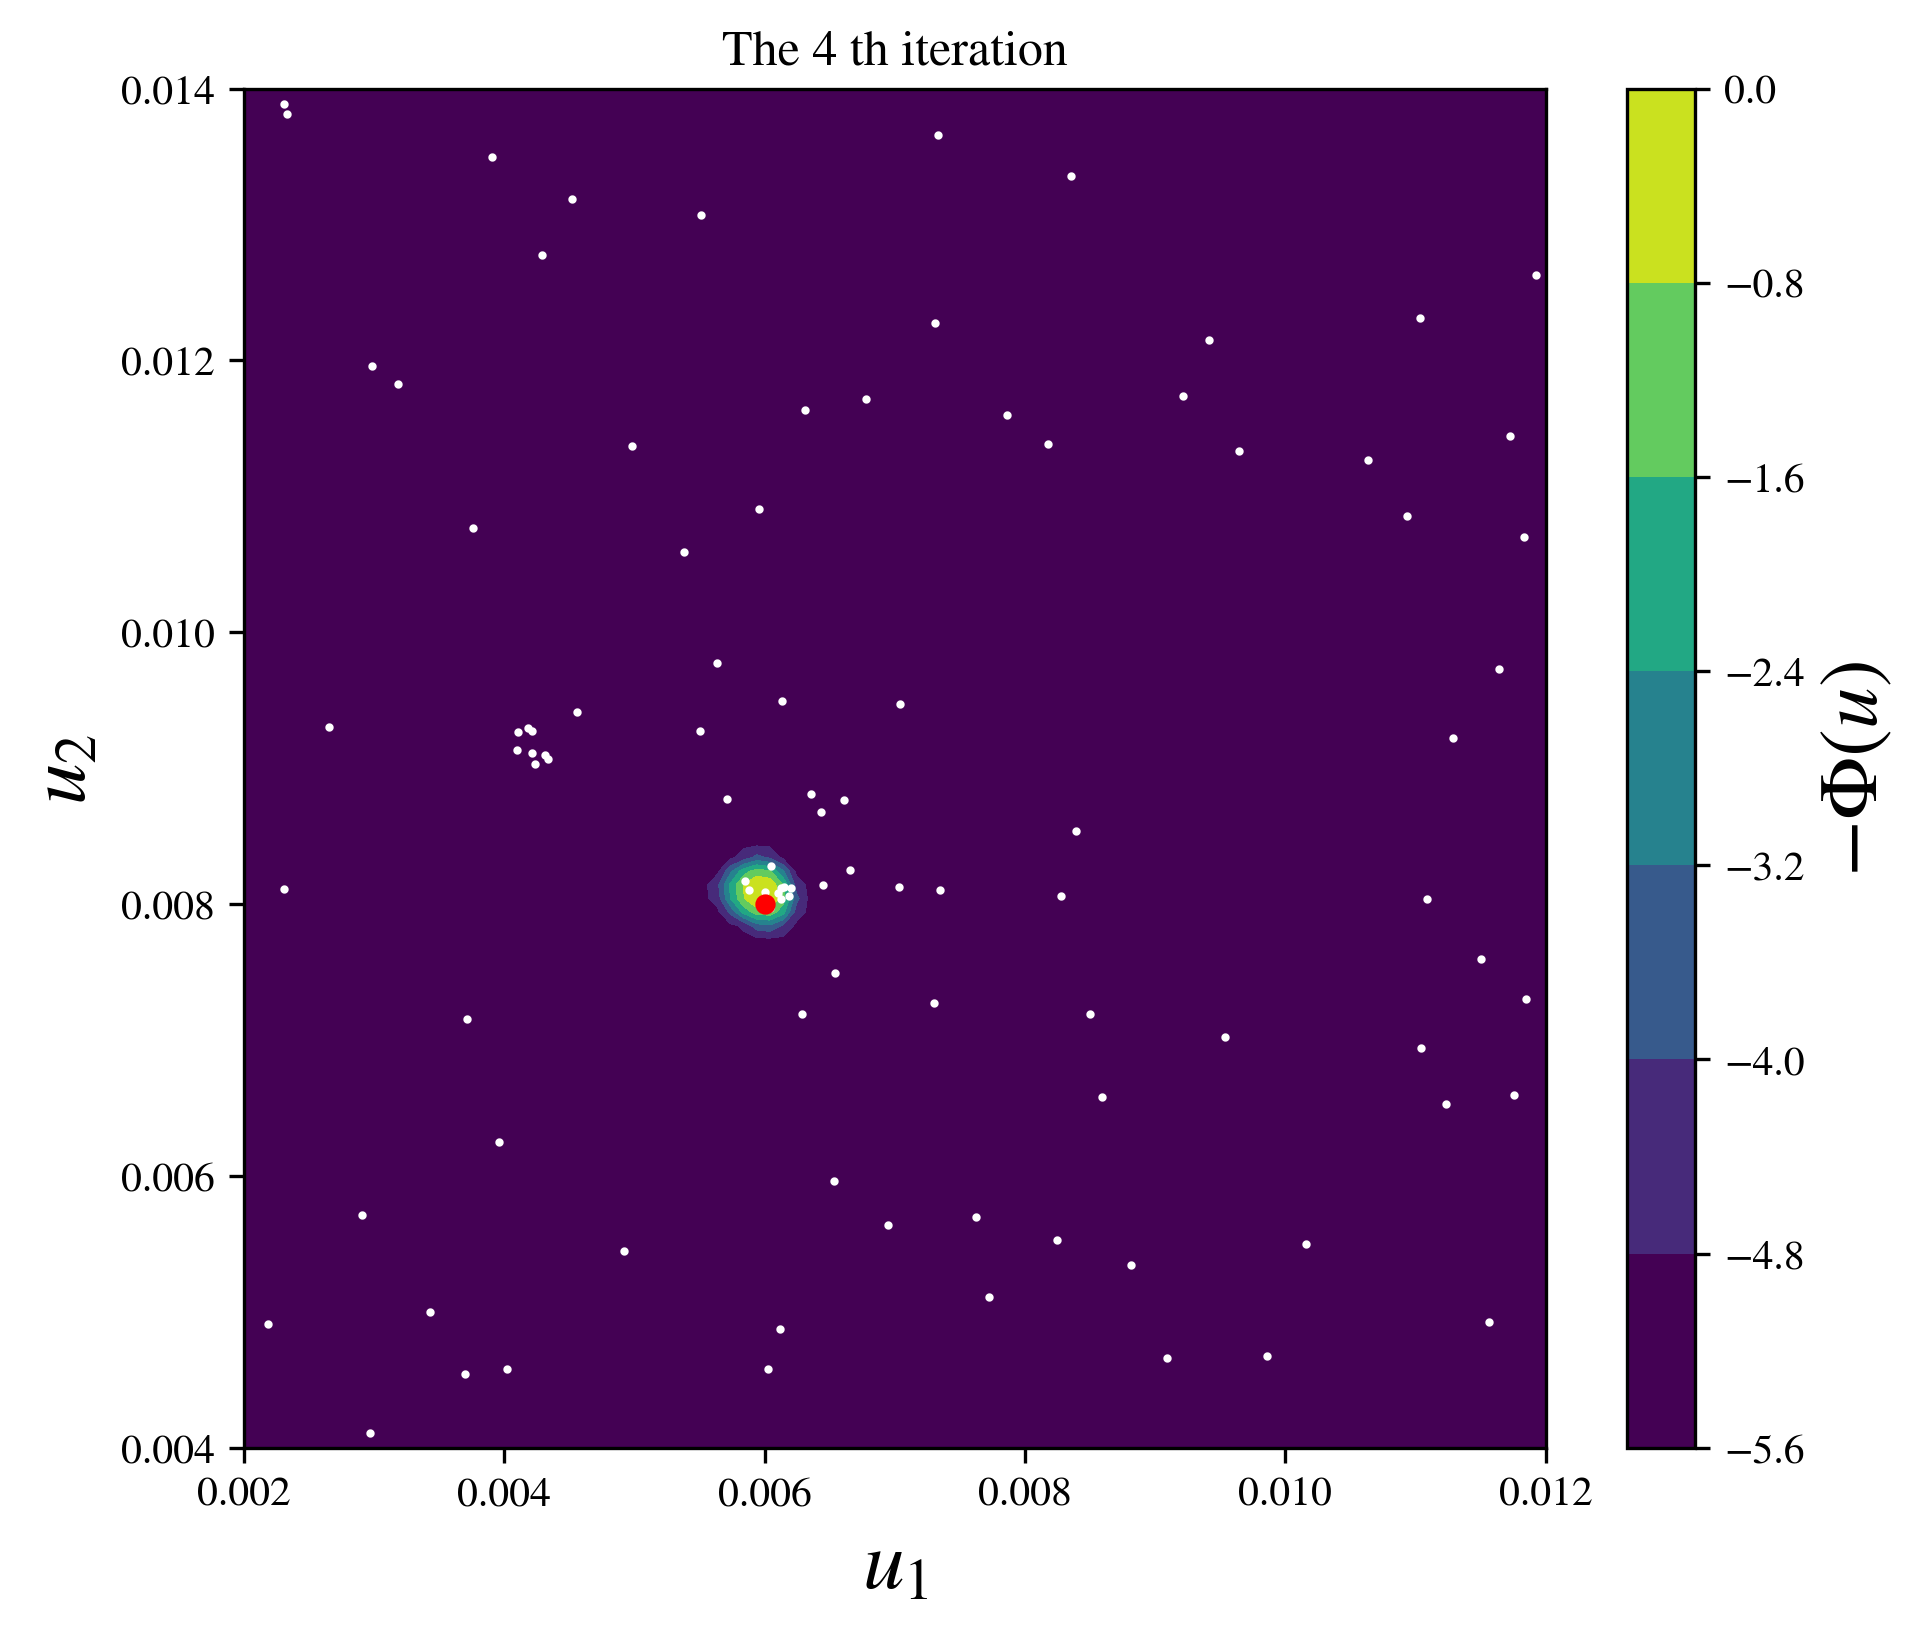

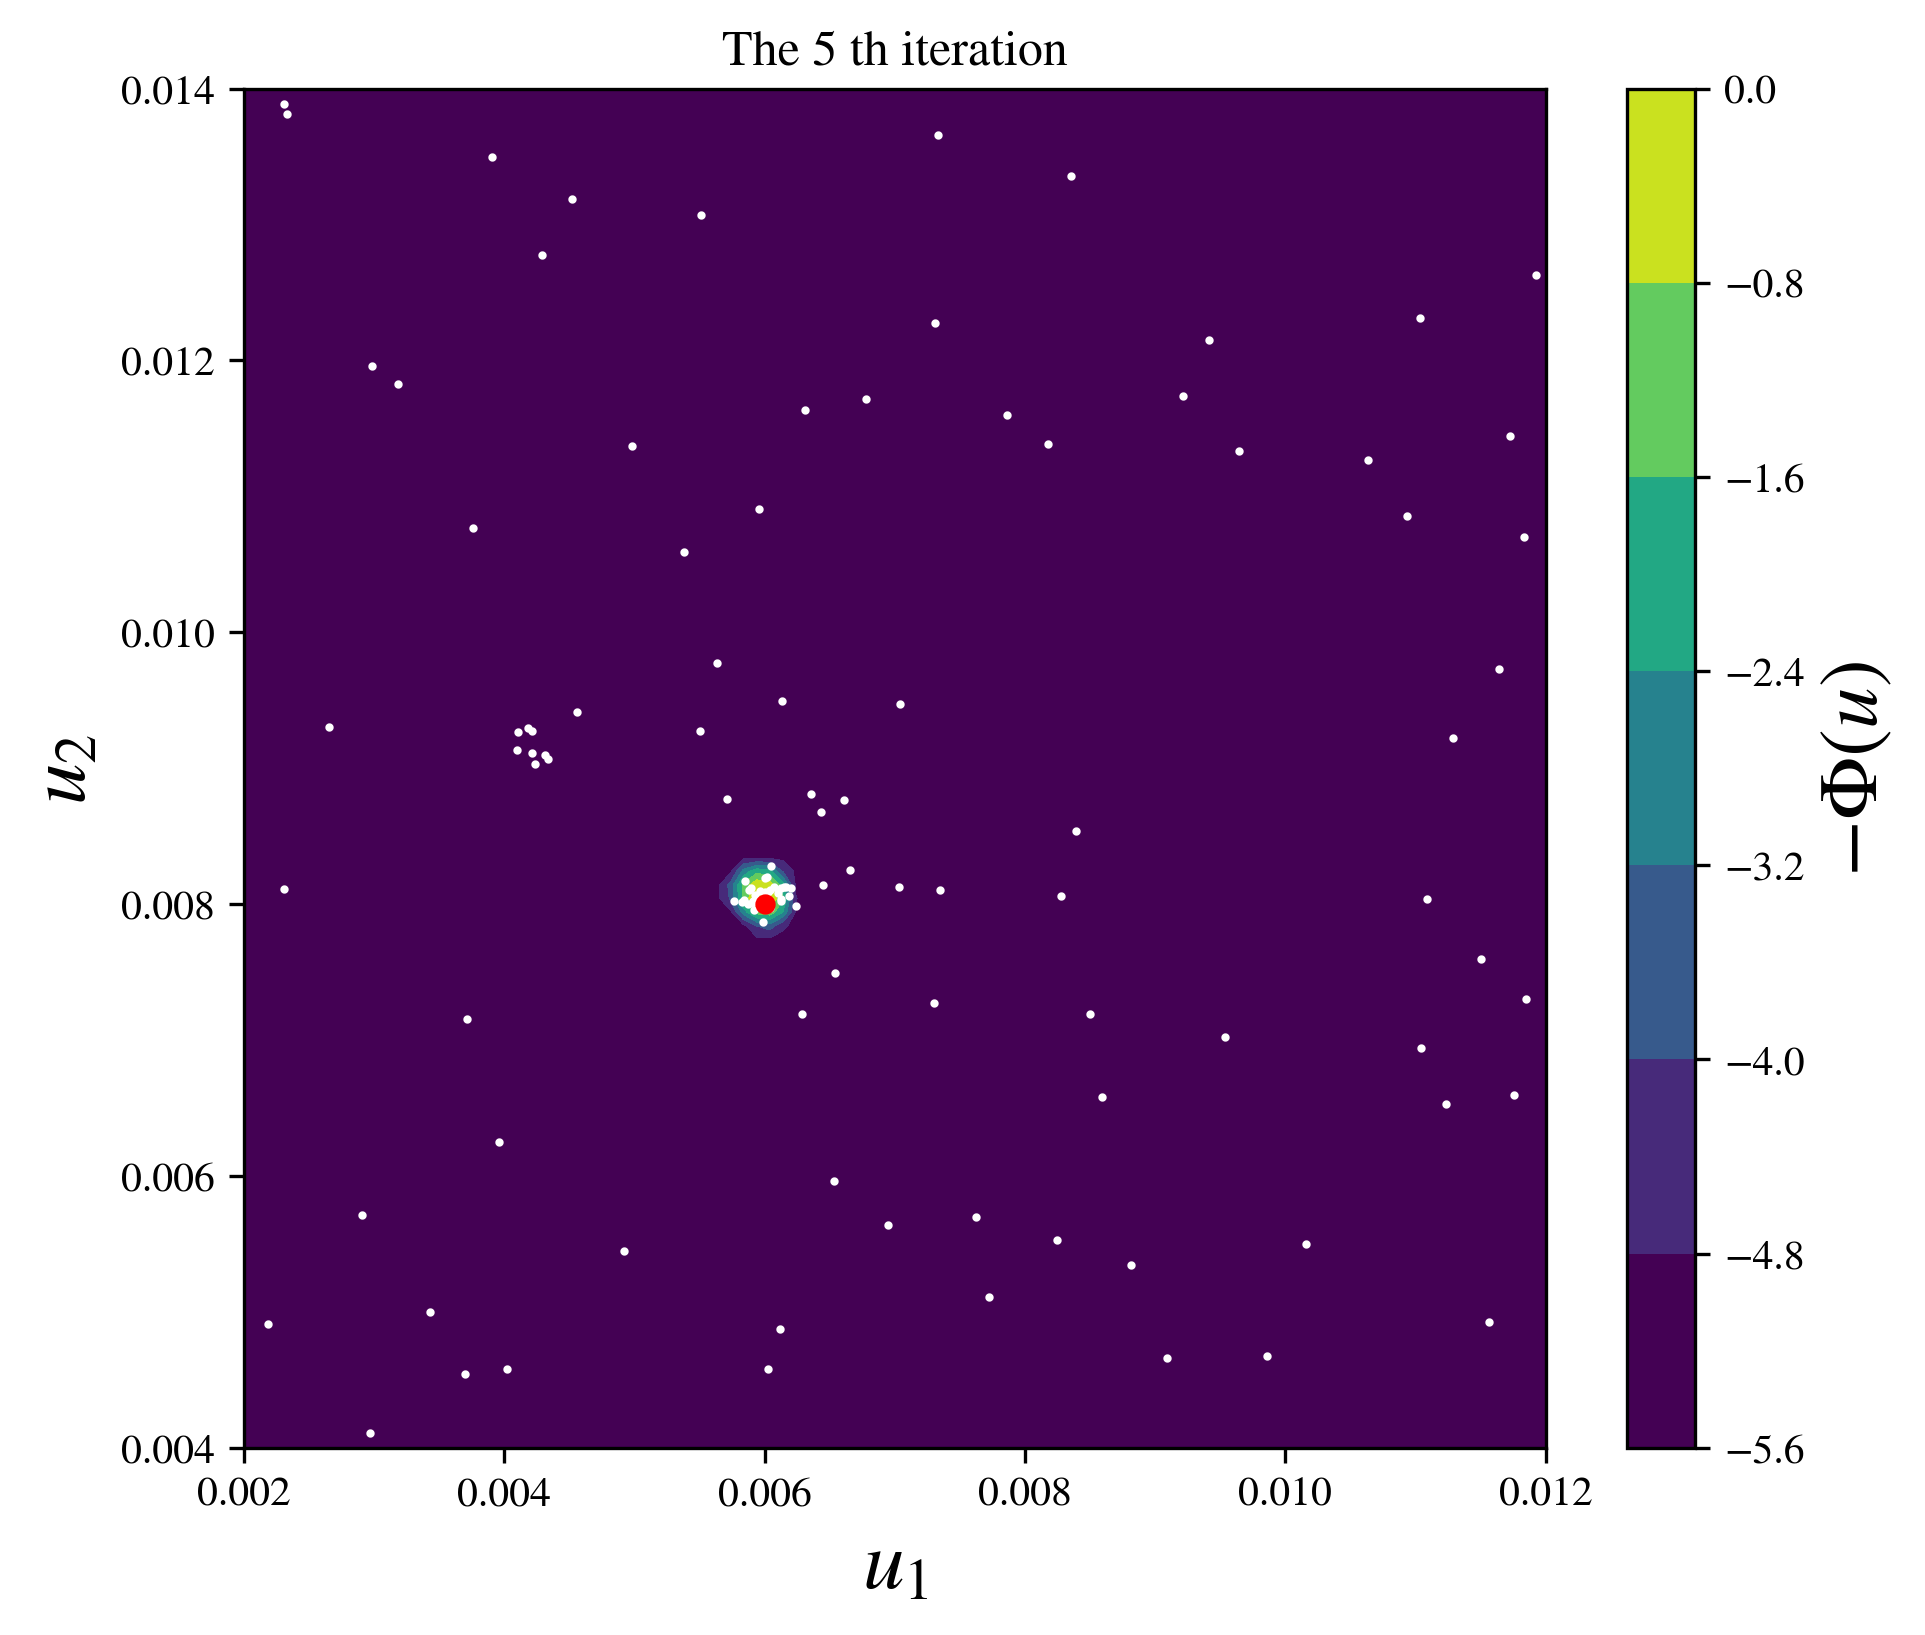

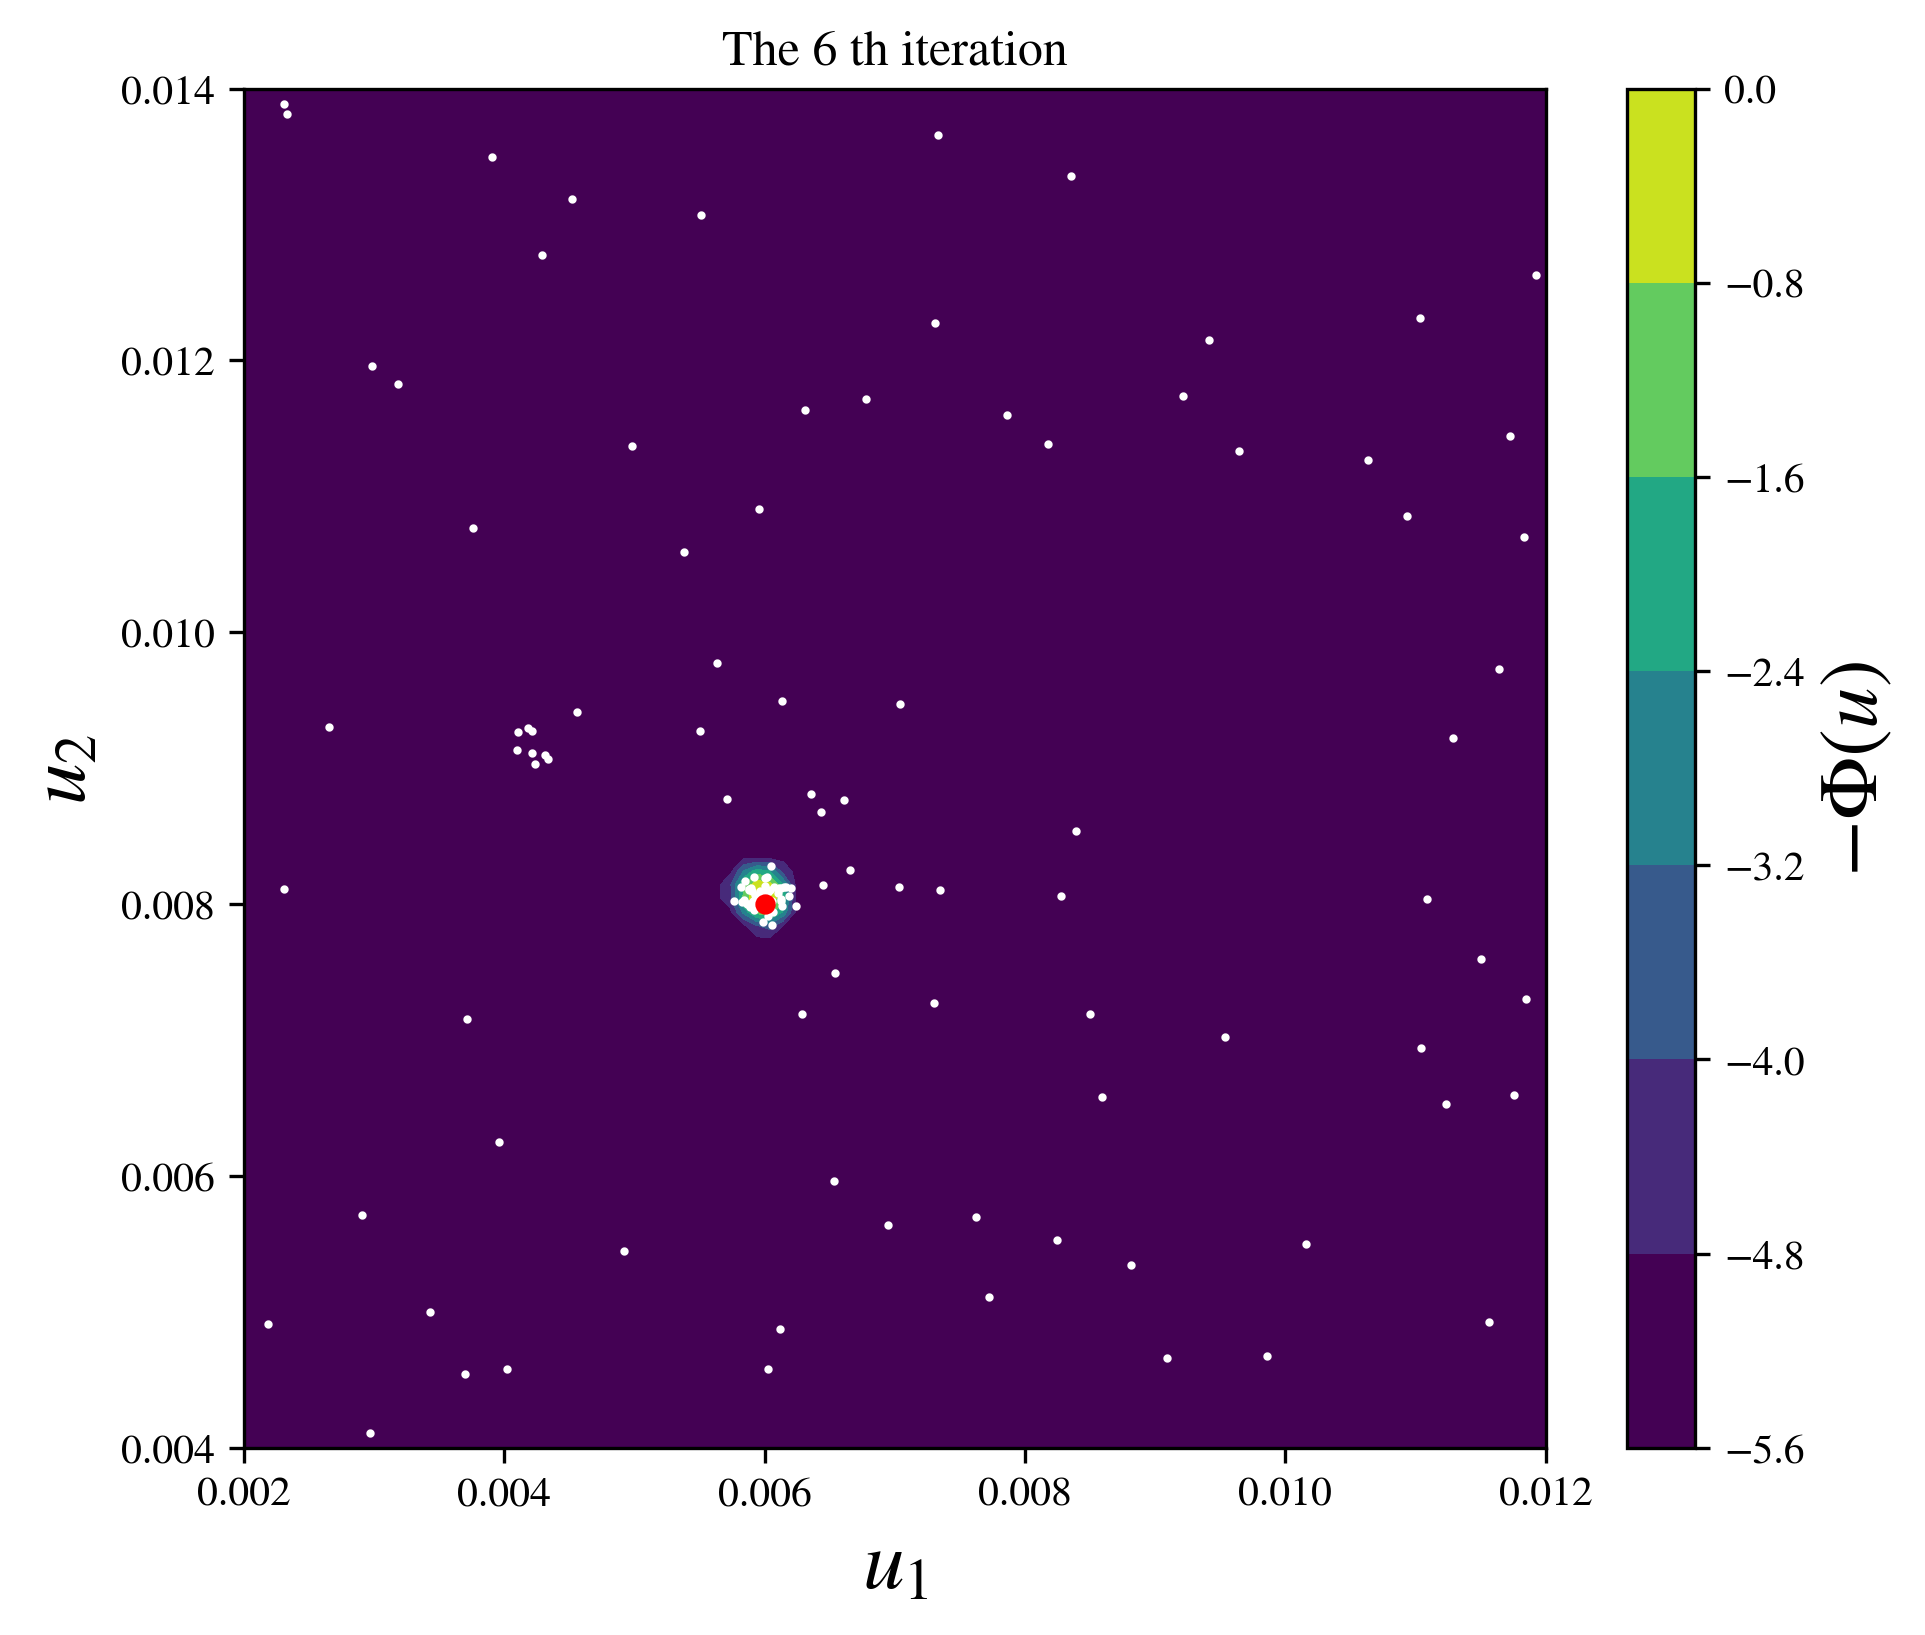

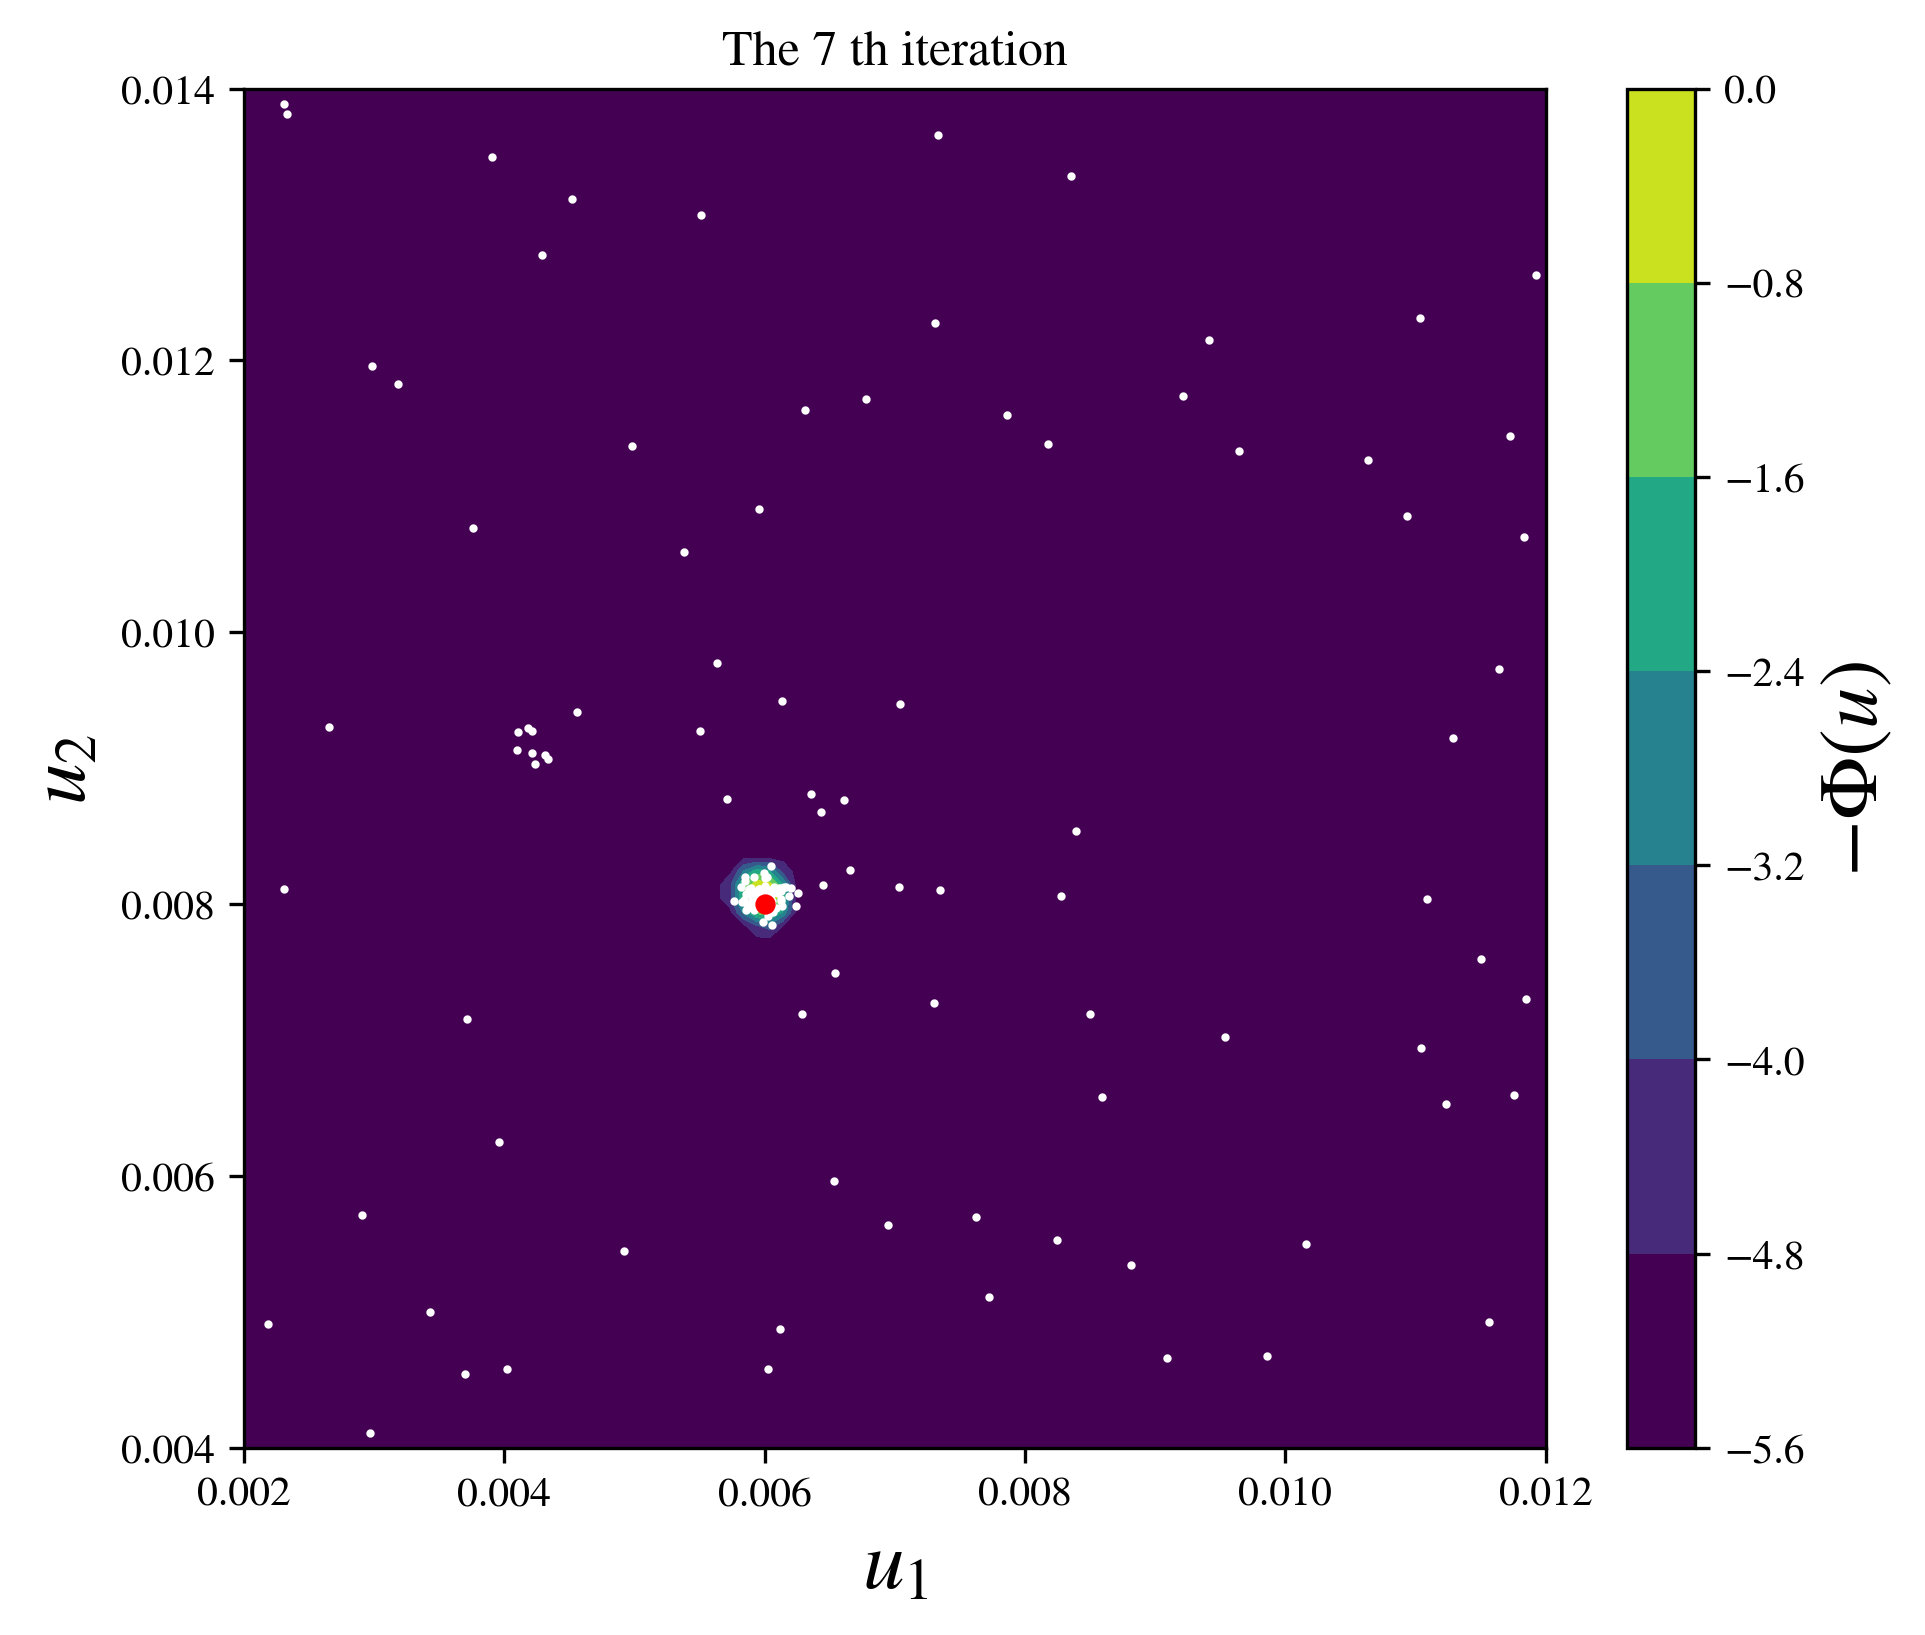

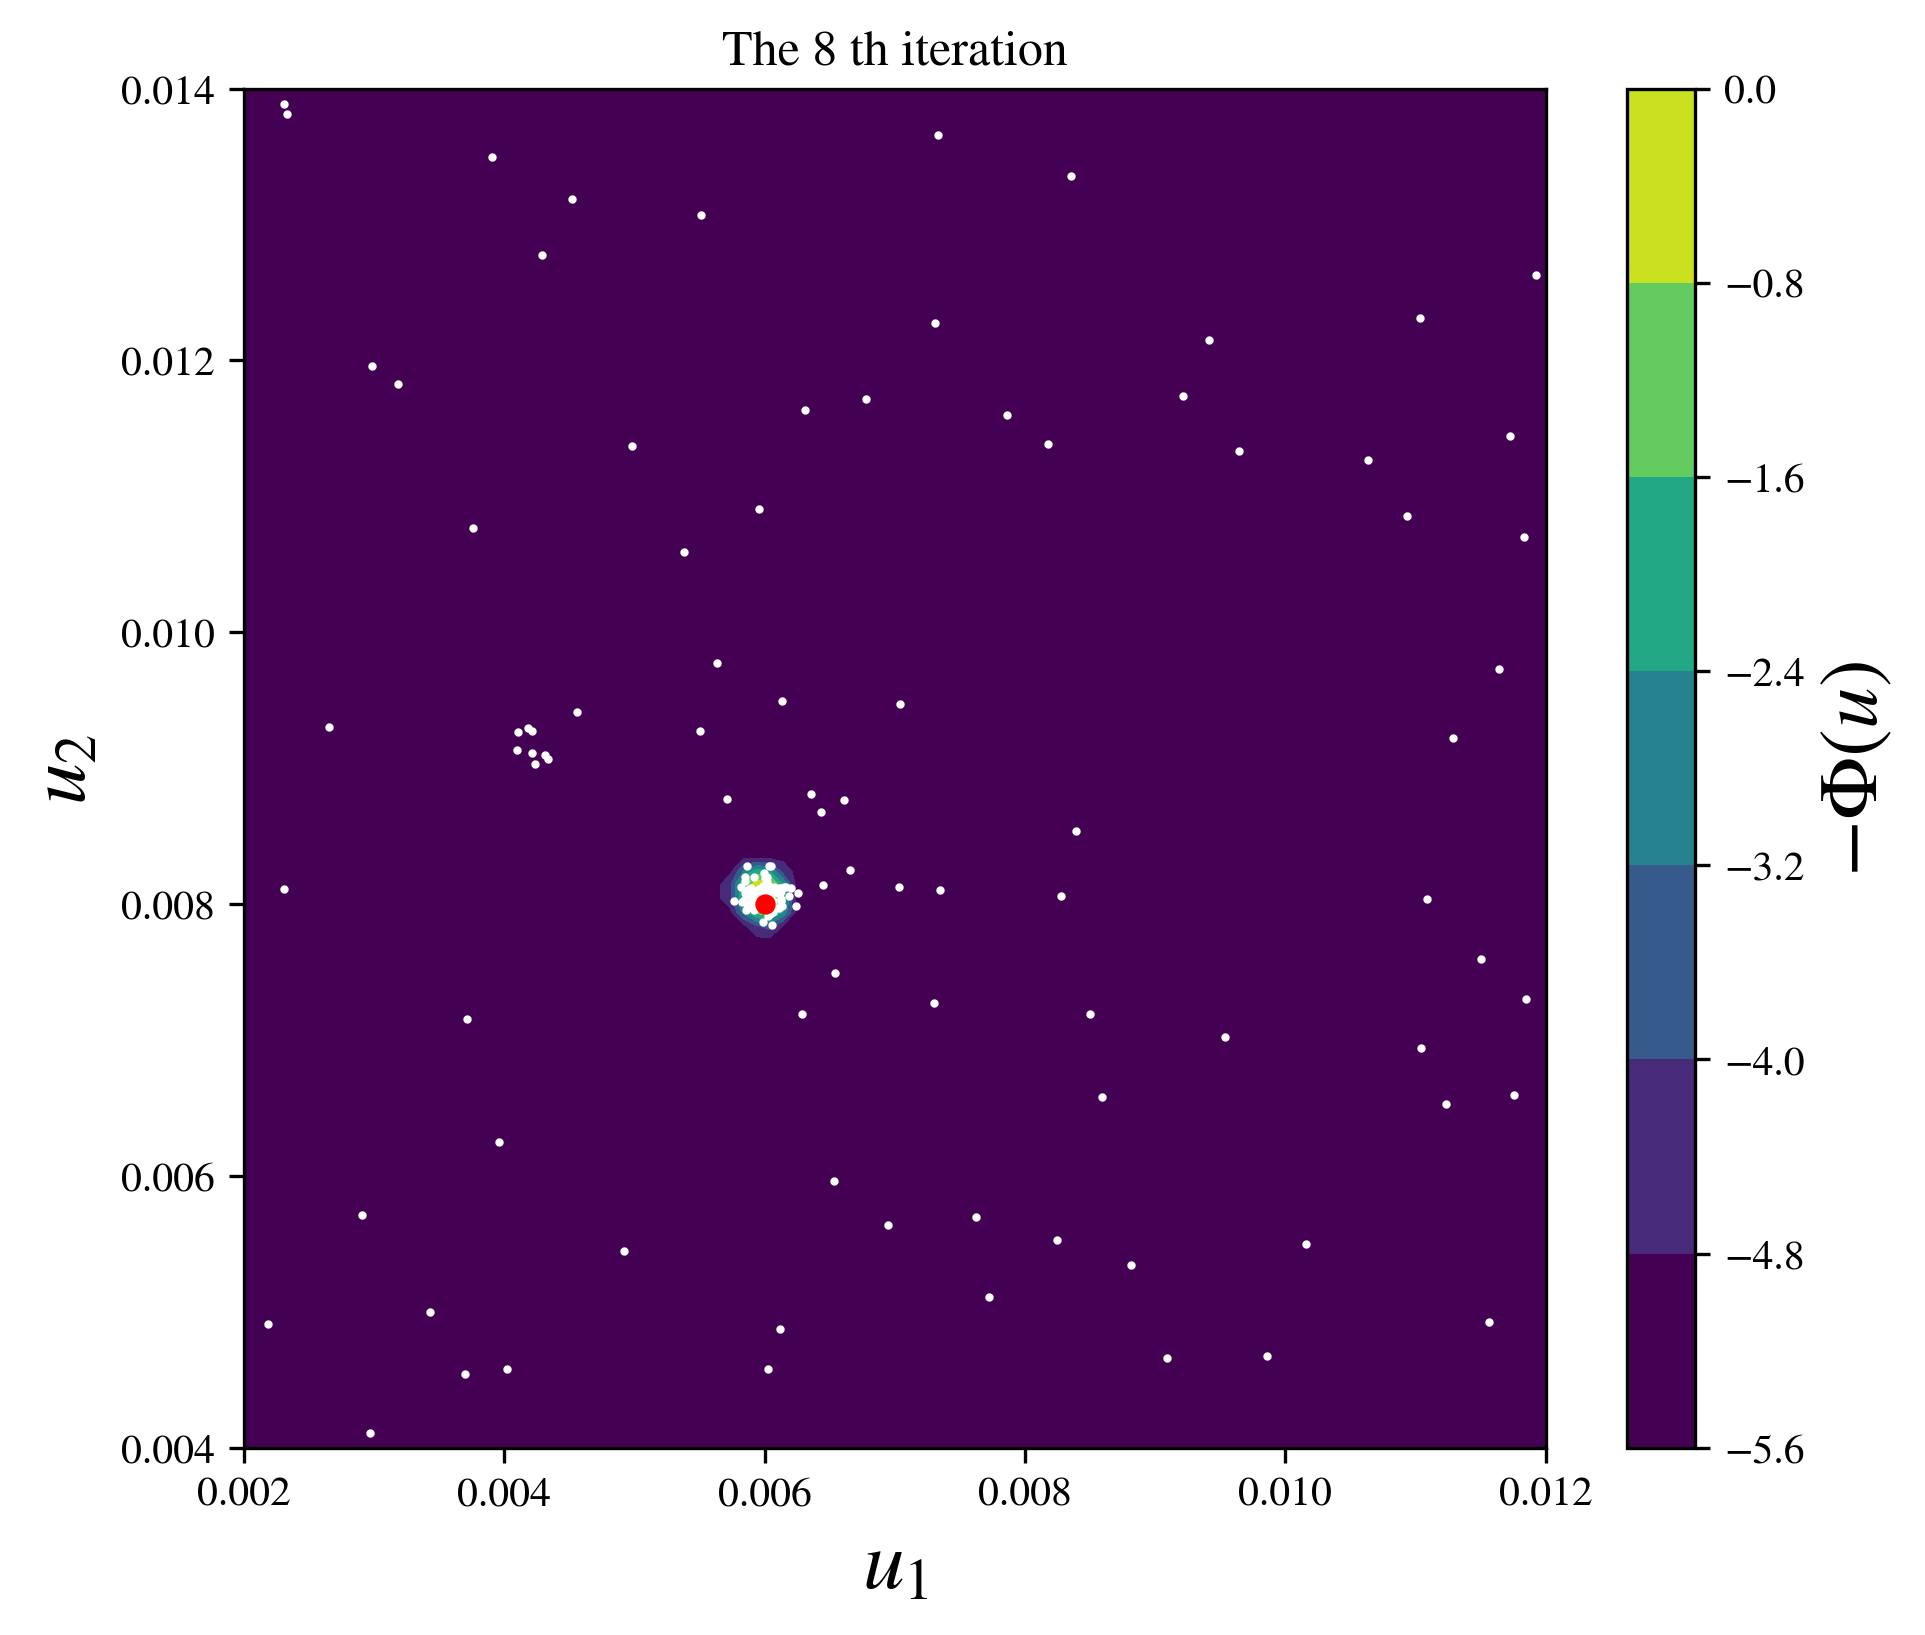

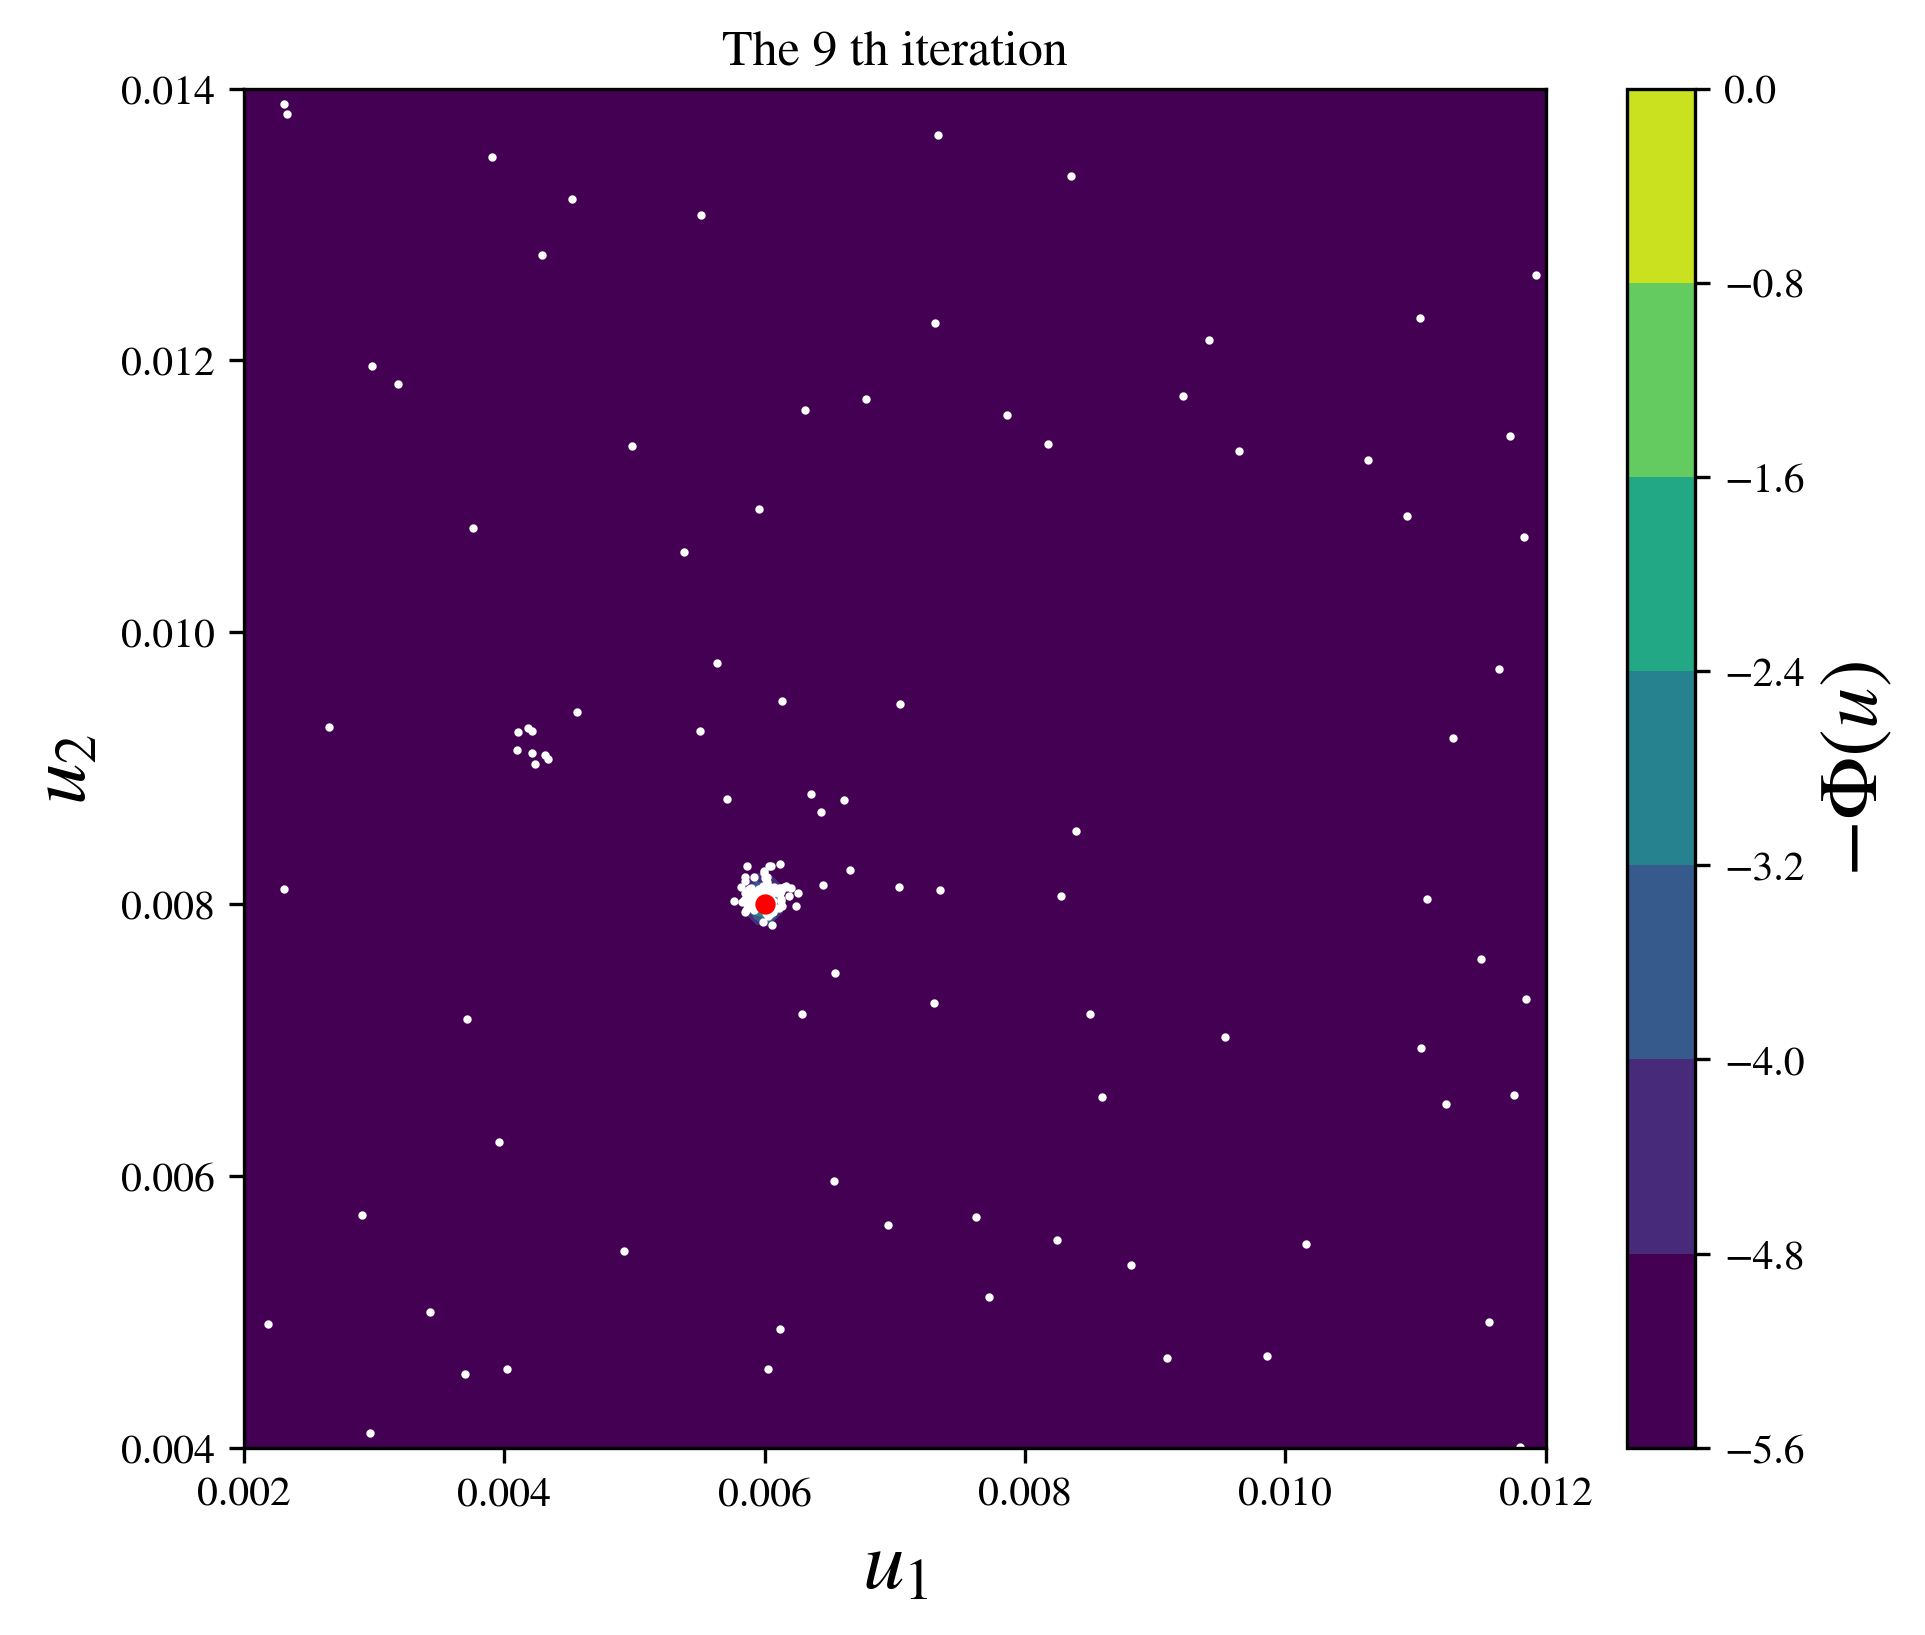

In [644]:
# Load from file
with open(f'./models/myInvA6_B8.pickle', 'rb') as file2:
    myInvA6_B8 = pickle.load(file2)


testCase_idx = 2 # 1 for 4_6, 2 for 6_8
y = testBatch.Observations[testCase_idx]
u = testBatch.input_set[testCase_idx]

myFigs = plotSeries(myInvA6_B8, u, y)

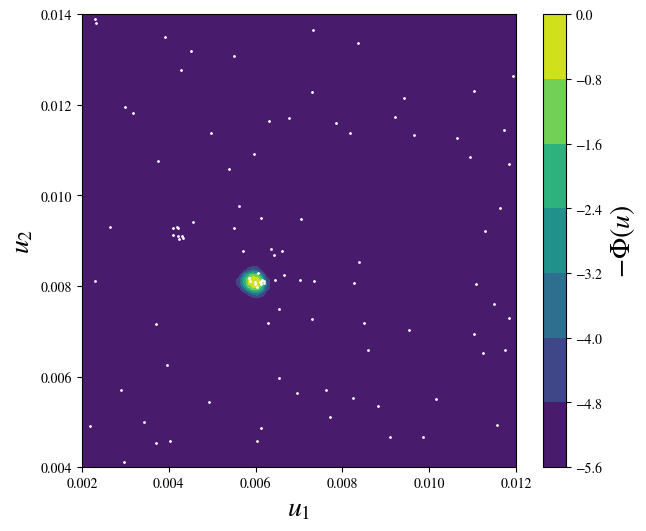

In [557]:
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [513]:
# Calculate U_plot
minU = myInv.u_low
maxU = myInv.u_high
nOfGridPoints = 100
bestIteration = 5

xis = []
for i in range(minU.shape[0]):
    xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

# Generate grid and draw predictions
UPlotGrid = np.meshgrid(xis[0], xis[1])
UPlotGrid = np.stack(UPlotGrid, axis = 2)
UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
# UPlotGridFat_scaled = U_scaler.transform(UPlotGridFat)
YPlotGridFat = log_prob_best(myInv, bestIteration - 1, UPlotGridFat, y)
YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])

True value of $(u_1, u_2)$:  (0.006, 0.008)
Maximum likelihood estimate of $(u_1, u_2)$:  [0.00593939 0.00814141]


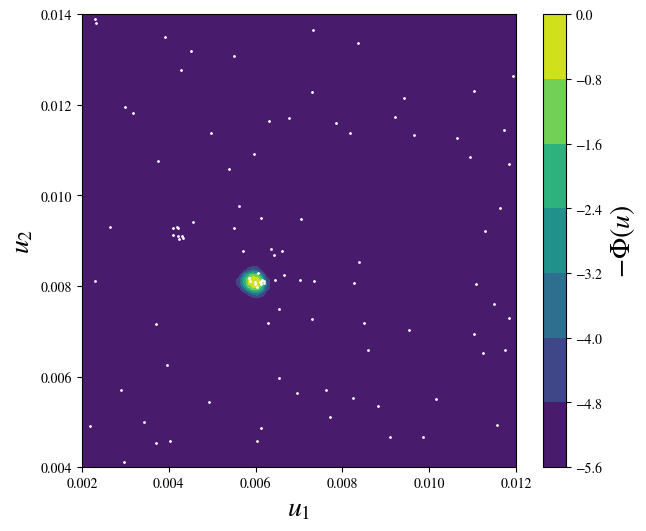

In [514]:
# Plot figure
fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)

# Plot the surface.
# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

cp = ax.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))

# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, rstride=1, cstride=1, cmap=cm.hsv, \
#   edgecolor='darkred', linewidth=0.1)
cbar = fig.colorbar(cp)

ax.scatter(myInv.U[ :bestIteration * myInv.n_samples, 0], 
           myInv.U[ :bestIteration * myInv.n_samples, 1], s = 1, color = 'white')
    
ax.set_xlabel('$u_1$', fontsize = 20)
ax.set_ylabel('$u_2$', fontsize = 20)
cbar.set_label('$-\\Phi(u)$', fontsize = 20)

# ax.set_zlabel('Unnormalized $d\mu(u)$', fontsize = 20)

# plt.scatter(U.reshape([-1]), np.linalg.norm(y - Y, axis = 1) ** 2)

# # Customize z axis
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
ind = np.unravel_index(np.argmax(YPlotGrid, axis=None), YPlotGrid.shape)
print("True value of $(u_1, u_2)$: ", testBatch.input_set[testCase_idx])
print("Maximum likelihood estimate of $(u_1, u_2)$: ", UPlotGrid[ind])

plt.show()

In [236]:
import scipy
from sklearn.utils.optimize import _check_optimize_result
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e06, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

# Gaussian predictor

In [41]:
# Import Gaussian-regression related functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Pre-process the data
from sklearn import preprocessing

# function train_GP
class GP_predictor:
    # Constructor
    def __init__(self, 
                 input_set, 
                 observation_set, 
                 GPkernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)), 
                 n_optimizers = 9):
        # Scale input data
        self.input_set = [list(x) for x in input_set]
        self.observation_set = [list(x) for x in observation_set]
        self.input_dimension = len(self.input_set[0])
        self.observation_dimension = len(self.observation_set[0])
        self.trainset_length = len(self.input_set)
        
        self.input_scaler = preprocessing.StandardScaler()
        self.input_scaler.fit(np.array(self.input_set))
        
        # Scale output data
        self.observation_scaler = preprocessing.StandardScaler()
        self.observation_scaler.fit(np.array(observation_set))
        
        # Fit Gaussian process
        self.GP = GaussianProcessRegressor(kernel = GPkernel, n_restarts_optimizer = n_optimizers)
        # self.GP = MyGPR(kernel = GPkernel, n_restarts_optimizer = n_optimizers, max_iter = max_iterations)
        self.GP.fit(self.input_scaler.transform(np.array(self.input_set)), 
                    self.observation_scaler.transform(np.array(self.observation_set)))
        
    # Predict on a new input set
    def predict(self, new_input_set):
        # Predict new observation
        new_observation = self.observation_scaler.inverse_transform(
            self.GP.predict(
                self.input_scaler.transform(np.array(list(new_input_set)).reshape([-1, self.input_dimension]))
            )
        )
        
        return new_observation
        
    

In [69]:
# Generate a set, run cases, get observations

In [ ]:
myGP = GP_predictor(input_set, )